# INFO F422 - Project : Modeling Earthquake Damage

> Group 17 - Pierre Hosselet & Romain Vandepopeliere


***

# Contents

0. [Preliminaries](#Preliminaries)
1. [Data preprocessing (task 1)](#Data-preprocessing)
    * [Data overview](#Data-overview)
    * [Data cleaning](#Data-Cleaning)
    * [Target encoding](#Target-encoding)
    * [Further feature selction](#Further-feature-selection)
2. [Model selection (task 2)](#Model-selection)
    * [Decision Tree](#Decision-Tree)
    * [Random Forest](#Random-Forest)
    * [Neural network](#Neural-network)
3. [Other model (task 3)](#Other-model-:-XGBoost)
4. [Feature relevance (task 5)](#Feature-relevance-via-entropy)
5. [Conclusion & score](#Final-score-and-conclusion)


***

## Preliminaries

In this section, we import the required libraries

In [1]:
library(rpart)
library(tensorflow)
library(keras)
library(tidyverse)
library(tidymodels)
library(GGally)
library(skimr)
library(recipes)
library(data.table)
library(mltools)
library(factoextra) 
library(scales)
library(png)
library(caTools)
library(xgboost)
library(randomForest)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.3     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()        masks purrr::discard()
✖ dply

ERROR: Error in library(mltools): there is no package called ‘mltools’


We also define the micro averaged F1 score

In [2]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

[back to the contents](#Contents)

***

## Data preprocessing

In this section, we pre-process data. The goal here is to explore, clean and engineer the data, before using it for the machine learning models. Let us firstly import the data from the .csv files.

In [9]:
#Loading the training data
train_values <- read.csv('Data/train_values.csv',header = TRUE,sep = ',',stringsAsFactors = T )
train_labels <- read.csv('Data/train_labels.csv',header = TRUE,sep = ',',stringsAsFactors = T)
rawdataset <- as.data.frame(cbind(train_values,train_labels))           #we put everything in the same dataset
rawdataset <- rawdataset %>% select(-building_id)                       #we get rid on unique identifiers

#Loding the test set 
test_values <- read.csv("Data/test_values.csv", header = TRUE,sep = ',' ,stringsAsFactors = T)

### Data overview

Let us start with a first look a the data

In [6]:
nrow(rawdataset)
ncol(rawdataset)
head(rawdataset)

[1] 260601

[1] 39

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,6,487,12198,2,30,6,5,t,r,n,⋯,0,0,0,0,0,0,0,0,0,3
2,8,900,2812,2,10,8,7,o,r,n,⋯,0,0,0,0,0,0,0,0,0,2
3,21,363,8973,2,10,5,5,t,r,n,⋯,0,0,0,0,0,0,0,0,0,3
4,22,418,10694,2,10,6,5,t,r,n,⋯,0,0,0,0,0,0,0,0,0,2
5,11,131,1488,3,30,8,9,t,r,n,⋯,0,0,0,0,0,0,0,0,0,3
6,8,558,6089,2,10,9,5,t,r,n,⋯,0,0,0,0,0,0,0,0,0,2


We have thus 39-1 = 38 features to train, some of them are categorical; `damage_grade` can take three values 1,2 and 3

First thing first: look for missing values:

In [3]:
print(dim(rawdataset))
print(dim(na.omit(rawdataset)))
apply(is.na(rawdataset),2,any)   #second check

[1] 260601     39
[1] 260601     39


geo_level_1_id                         geo_level_2_id 
                                 FALSE                                  FALSE 
                        geo_level_3_id                    count_floors_pre_eq 
                                 FALSE                                  FALSE 
                                   age                        area_percentage 
                                 FALSE                                  FALSE 
                     height_percentage                 land_surface_condition 
                                 FALSE                                  FALSE 
                       foundation_type                              roof_type 
                                 FALSE                                  FALSE 
                     ground_floor_type                       other_floor_type 
                                 FALSE                                  FALSE 
                              position                     plan_configuration 
                                 FALSE                                  FALSE 
          has_superstructure_adobe_mud    has_superstructure_mud_mortar_stone 
                                 FALSE                                  FALSE 
         has_superstructure_stone_flag has_superstructure_cement_mortar_stone 
                                 FALSE                                  FALSE 
   has_superstructure_mud_mortar_brick has_superstructure_cement_mortar_brick 
                                 FALSE                                  FALSE 
             has_superstructure_timber              has_superstructure_bamboo 
                                 FALSE                                  FALSE 
  has_superstructure_rc_non_engineered       has_superstructure_rc_engineered 
                                 FALSE                                  FALSE 
              has_superstructure_other                 legal_ownership_status 
                                 FALSE                                  FALSE 
                        count_families                      has_secondary_use 
                                 FALSE                                  FALSE 
         has_secondary_use_agriculture                has_secondary_use_hotel 
                                 FALSE                                  FALSE 
              has_secondary_use_rental          has_secondary_use_institution 
                                 FALSE                                  FALSE 
              has_secondary_use_school             has_secondary_use_industry 
                                 FALSE                                  FALSE 
         has_secondary_use_health_post           has_secondary_use_gov_office 
                                 FALSE                                  FALSE 
          has_secondary_use_use_police                has_secondary_use_other 
                                 FALSE                                  FALSE 
                          damage_grade 
                                 FALSE

Great, no missing values to declare ! We can carry on the overview

**Features statistics**

####  Analysis of **geo_level_id**

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     7.0    12.0    13.9    21.0    30.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   350.0   702.0   701.1  1050.0  1427.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    3073    6270    6258    9412   12567 

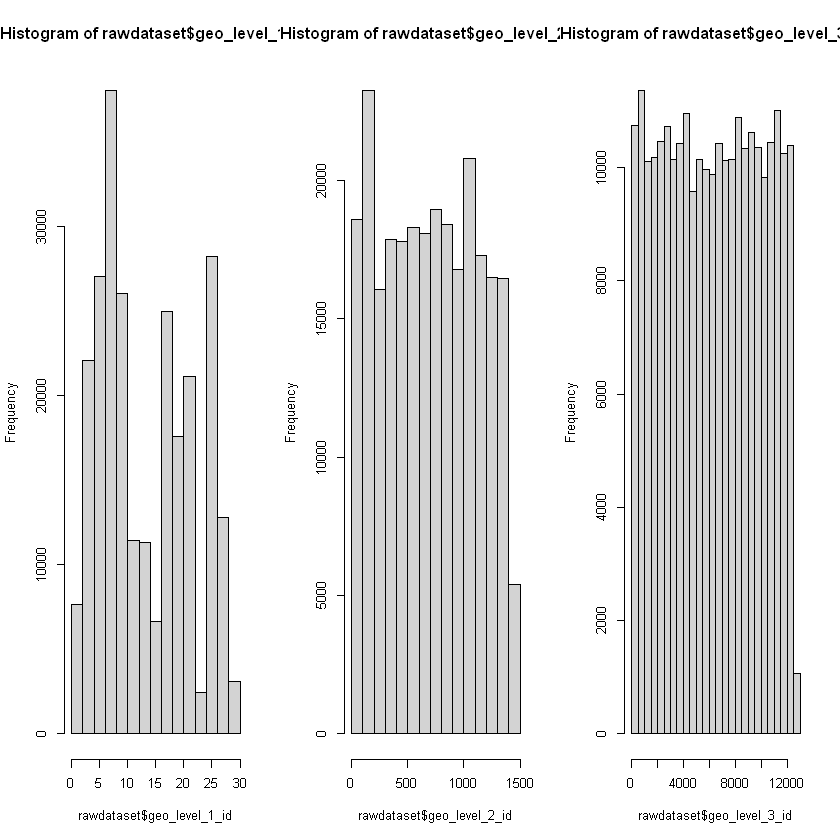

In [10]:
summary(rawdataset$geo_level_1_id)
summary(rawdataset$geo_level_2_id)
summary(rawdataset$geo_level_3_id)

par(mfrow=c(1,3))
hist(rawdataset$geo_level_1_id)
hist(rawdataset$geo_level_2_id)
hist(rawdataset$geo_level_3_id)

For geo_level_1, the data seems a bit disparate depending on the region. Distribution of geo_level_2 and 3 is however much more uniform altough in the end there are fewer instances.

Even if geo_level_id are integers, we have no idea on how the region has been geographically delimitated. Therefore, these three variables will certainly need a suitable encoding rather than the actual one, the underlying ordering may cause misinterpretation of the data by our model. A good example of that is the division "snail-like" into district of Paris:


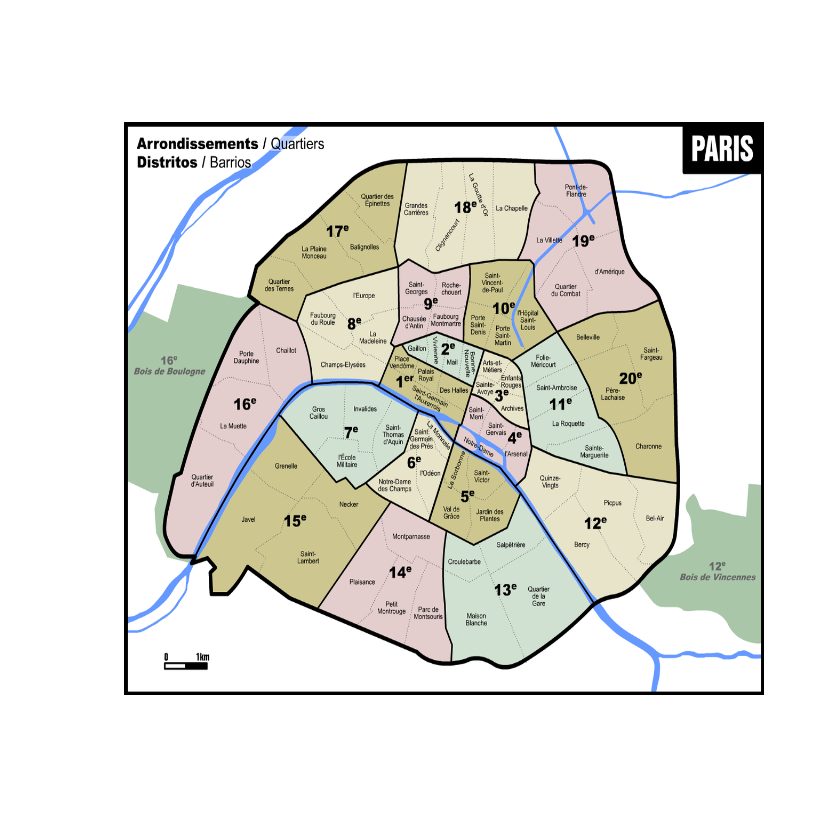

In [17]:
pp <- readPNG("Pictures/Les_quartiers_de_paris.png")
plot.new() 
rasterImage(pp,0,0,1,1,cex=0.3)

In this example, region 7 is geographically closer to region 15 and 16 than region 5, altough this is not the case in terms of number: we will handle this problem later in the data pre-processing, namely during [target encoding](#Target-encoding).

When choosing this encoding we should also be careful that some regions are less represented ! Lets have a look on the average instance for a geo_level_3_id

In [20]:
count_geo_level_3 <- aggregate(rawdataset$geo_level_3_id, by = list(rawdataset$geo_level_3_id),FUN=length)
summary(count_geo_level_3[,2])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    5.00   14.00   22.48   30.00  651.00 

Only 22 instances per geo_level_3_id, the smallest geographical delimitation !

#### Analysis of **count_floors_pre_eq**

(type:int): number of floors in the building before the earthquake

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    2.00    2.13    2.00    9.00 

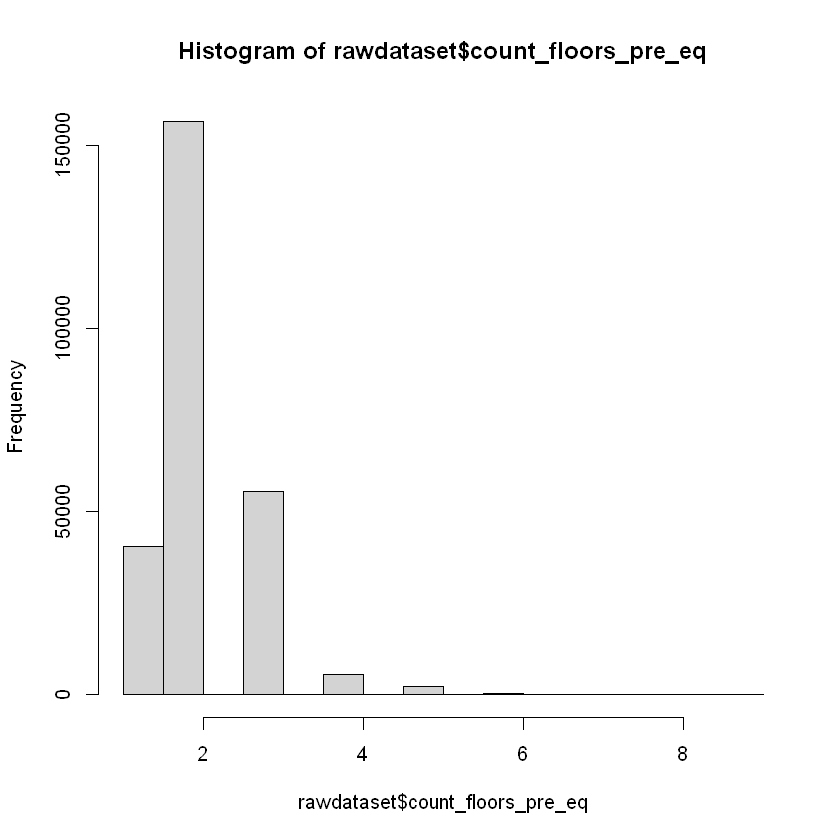

In [40]:
summary(rawdataset$count_floors_pre_eq)
hist(rawdataset$count_floors_pre_eq)

Distribution is higly peaked on 2 but looks good. However, count_floor_eq >=5 seems to be too little and might not be well represented statistically: we propose to replace them by the mean, since in general models do not handle well outliers. We can have a look at the Upper and Lower fences via boxplot, and we see that in fact values different from 2 are considered as "statistical outliers". Of course we won't get rid of all of them, it would be a great loss of information

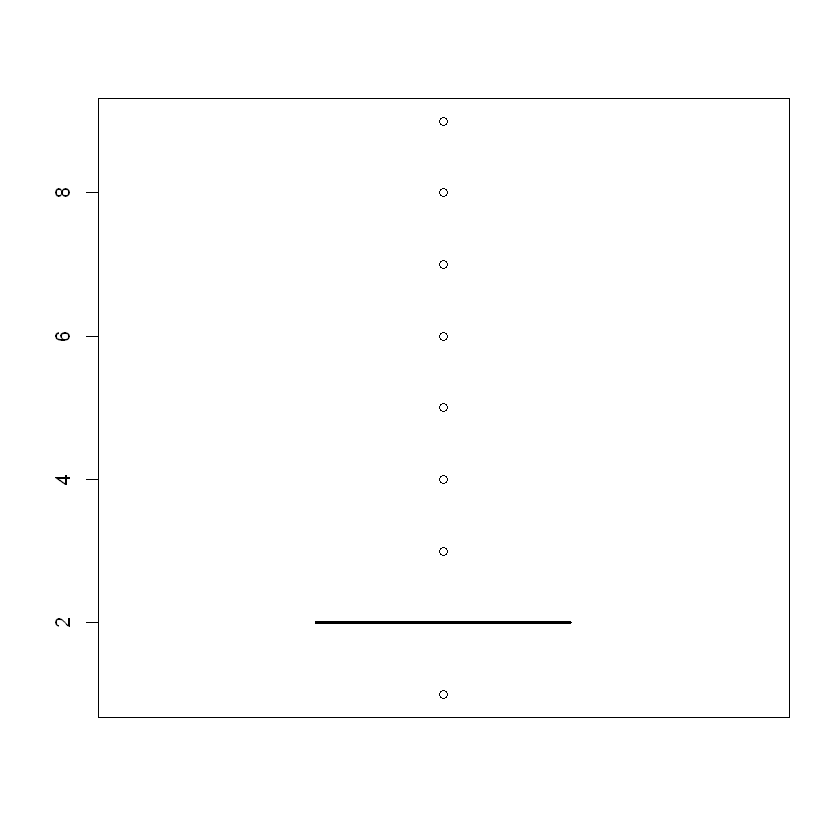

In [28]:
boxplot(rawdataset$count_floors_pre_eq)

In [31]:
#Percentage of row which have more that 4 floors: 0.95%

nrow(rawdataset[rawdataset$count_floors_pre_eq>=5,])/nrow(rawdataset)*100

[1] 0.957786

#### Analysis of **age** 

(type: int): age of the building in years.

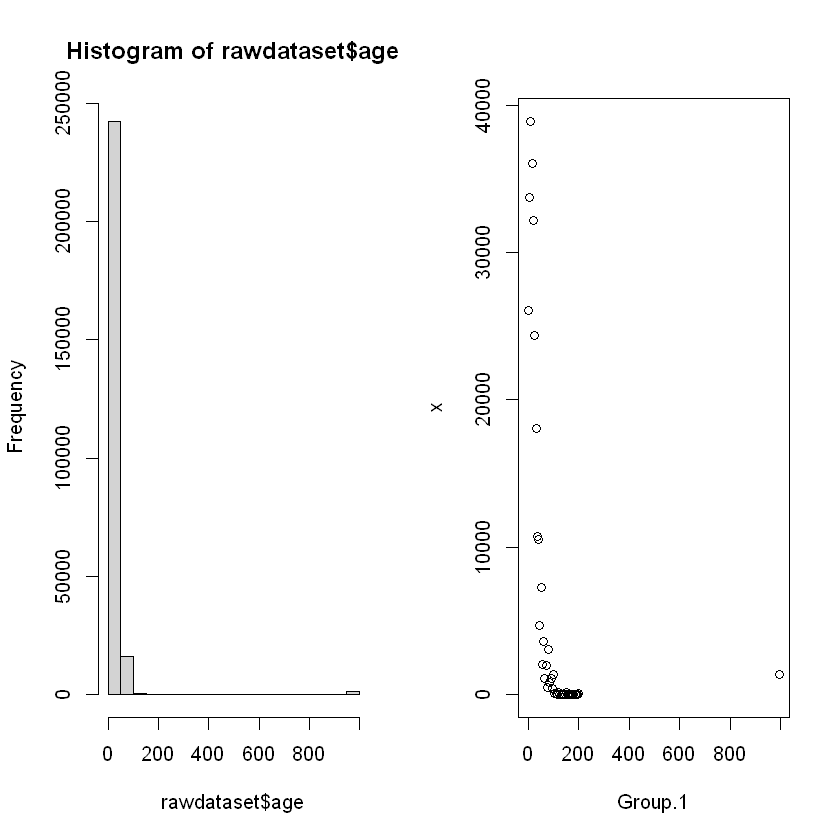

In [34]:
par(mfrow=c(1,2))
hist(rawdataset$age)
count_age <- aggregate(rawdataset$age, by = list(rawdataset$age),FUN=length)
plot(count_age, main ='Count of age')

We see here a outliers at age~1000 ! Again, we don't want them to distur our future model, we propose to replace them by the mean

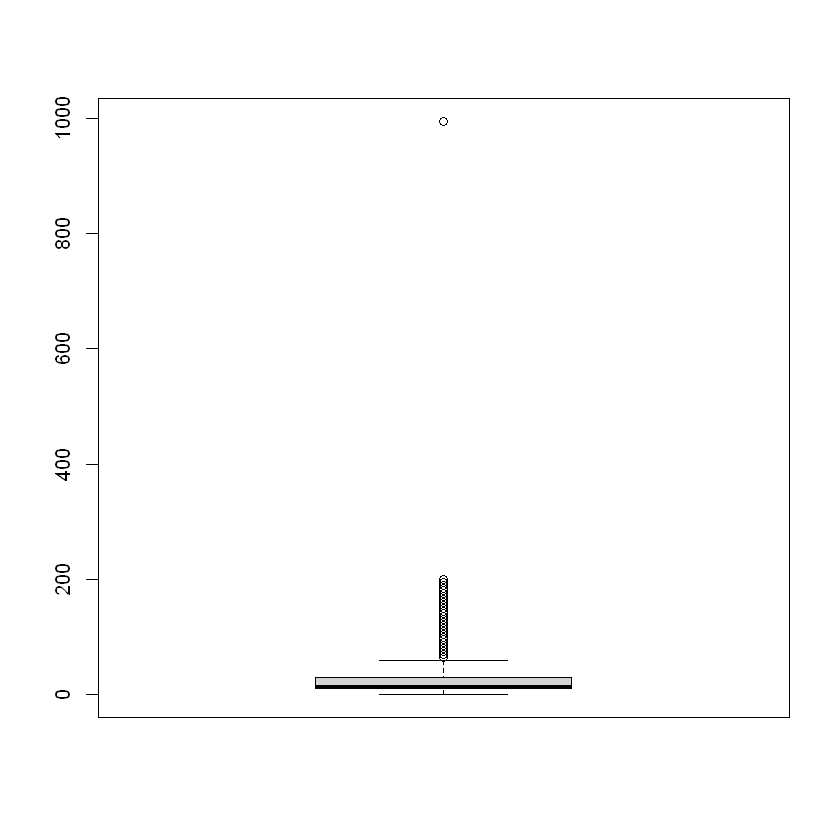

In [33]:
boxplot(rawdataset$age)

In fact many points are considered by Upper and Lower fences as statistical outliers, but building that have ~200 years old is quite reasonable for us. The ones at ~1000 are not, we will replace them by the mean, we can have a look at them 

In [38]:
unique(rawdataset[rawdataset$age>=900,'age'])    #Search for the only values of age >900
length(rawdataset[rawdataset$age>=900,'age'])   #Number of rows that have age>900
head(rawdataset[rawdataset$age>=900,])

[1] 995

[1] 1390

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
387,14,1120,3789,3,995,12,5,t,r,n,⋯,0,0,0,0,0,0,0,0,0,2
717,26,39,1851,2,995,27,6,t,i,x,⋯,0,0,0,0,0,0,0,0,0,1
1236,26,1132,9472,2,995,8,5,t,r,q,⋯,0,0,0,0,0,0,0,0,0,3
1399,26,39,1851,2,995,14,6,t,u,n,⋯,0,0,0,0,0,0,0,0,0,1
1636,24,628,10750,2,995,10,5,t,r,n,⋯,0,0,0,0,0,0,0,0,0,3
2149,27,181,2607,2,995,4,6,t,r,n,⋯,0,0,0,0,0,0,0,0,0,2


Note that all these 1390 outliers share the exact same age, namely 995. We believe this is related to some default encoding (maybe due to missing values? or buildings that don't have a precise age known?). 

#### Analysis of **area_percentage** 

(type: int): normalized area of the building footprint

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   7.000   8.018   9.000 100.000 

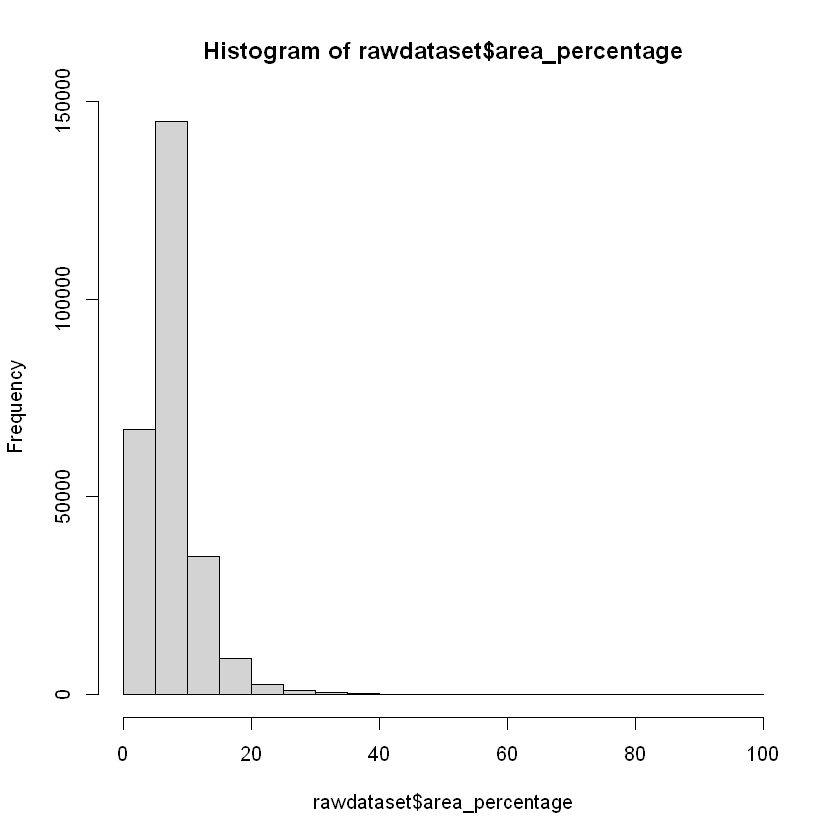

In [39]:
summary(rawdataset$area_percentage)
hist(rawdataset$area_percentage)

Good looking distribution ! At 40 we start having almost very few lines compared to 8: let's see if there are still record >40

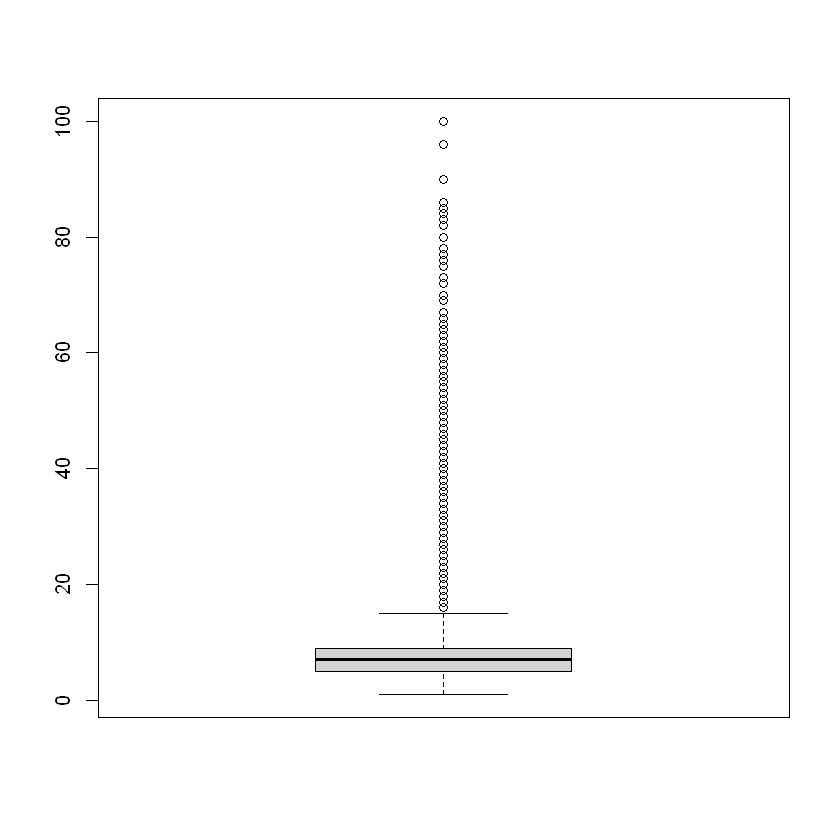

In [41]:
boxplot(rawdataset$area_percentage)

Yes indeed ! As we are looking for efficiency, we would like to smooth the point too far to the upper fence. Starting at 30 seems reasonable for us since we the number of instances appears to be extremly small on the first graphic, and we don't want to loose too much information. We propose to replace them by the mean, to avoid alterate the initial distribution. What is the percentage of rows impacted? 

In [45]:
#Computation of percentage: 0.38%
length(rawdataset[rawdataset$area_percentage >30,'area_percentage'])/nrow(rawdataset)*100   

[1] 0.3806586

#### Analysis of **height_percentage** 

(type: int): normalized height of the building footprint

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   4.000   5.000   5.434   6.000  32.000 

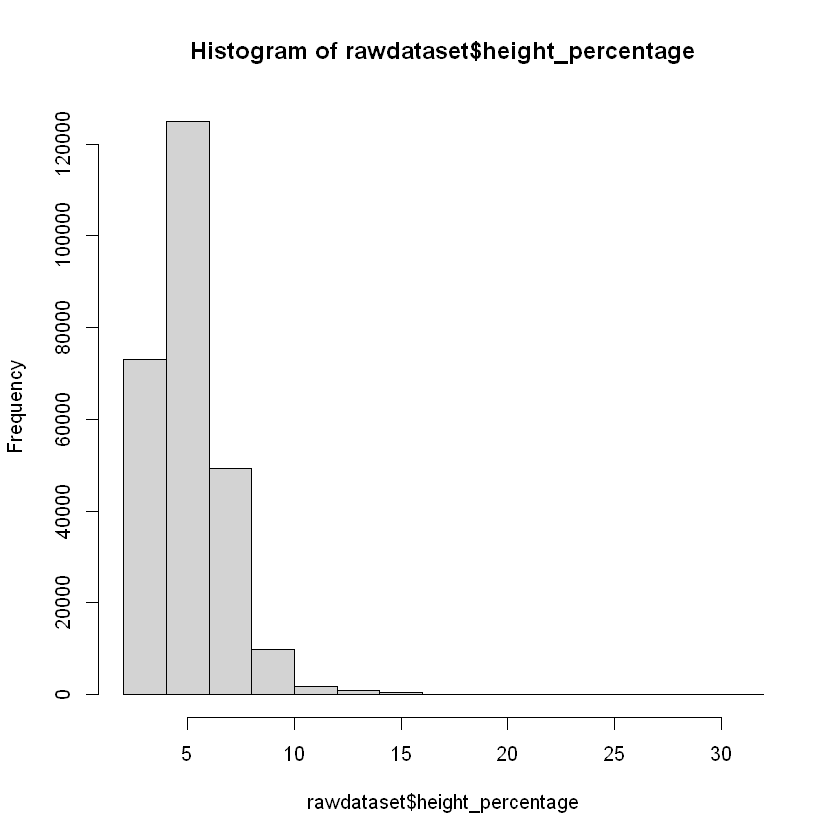

In [46]:
summary(rawdataset$height_percentage)
hist(rawdataset$height_percentage)

The distribution looks good ! However, if there are some points with area_percentage >15 they should be replaced by the mean, with the same reasoning as before. Let's check if it's the case

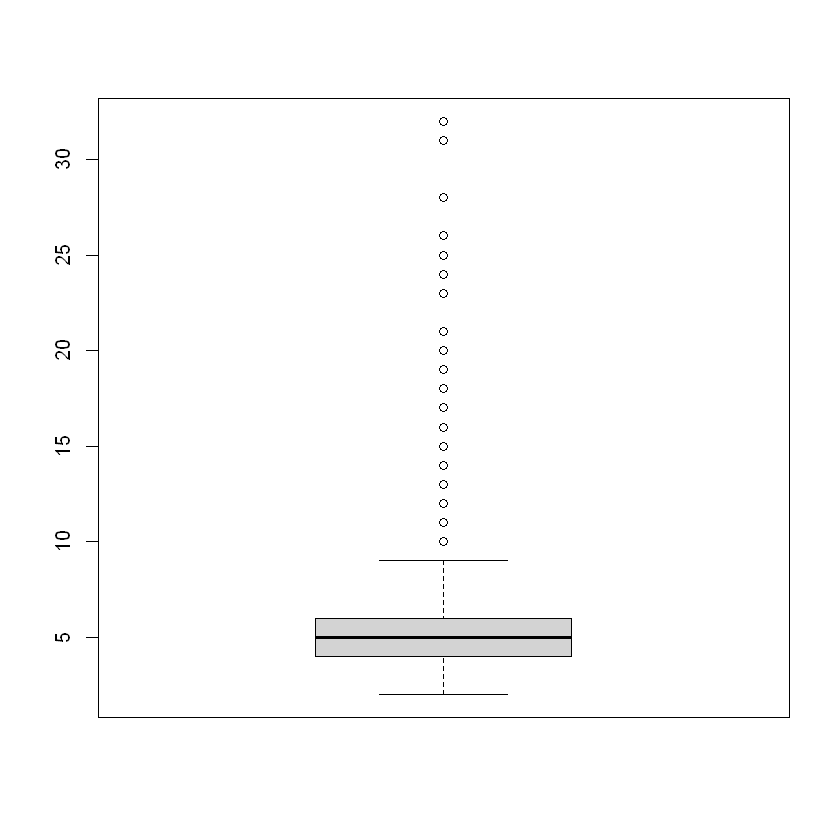

In [47]:
boxplot(rawdataset$height_percentage)

How many rows are impacted ? 

In [50]:
#Computation of percentage : 0.27%
nrow(rawdataset[rawdataset$height_percentage>=15,])/nrow(rawdataset)*100

[1] 0.2693773

#### Analysis of **land_surface_condition** 

(type: categorical): surface condition of the land where the building was built. Possible values: n, o, t

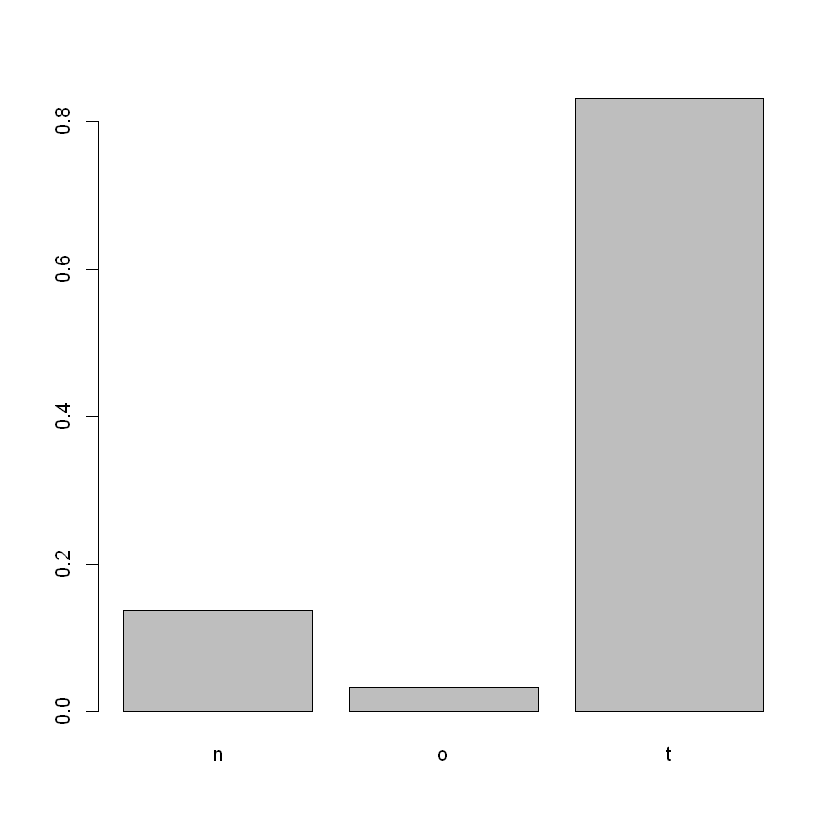

In [51]:
#Proportion of values in land_surface_condition
barplot(prop.table(table(rawdataset$land_surface_condition)))

In [53]:
#Proportion in percentage of 'o'
nrow(rawdataset[rawdataset$land_surface_condition=='o',])/nrow(rawdataset)*100

[1] 3.191085

The proportion of instances for 'o' is small (3%) but we don't think we should replace/delete it, we don't want to loose information, therefore we leave it untouched. We will assume in the following that a proportion of 1% is good treshold under which we can start thinking about replacing outliers.

#### Analysis of **foundation_type** 

(type: categorical): type of foundation used while building. Possible values: h, i, r, u, w. 

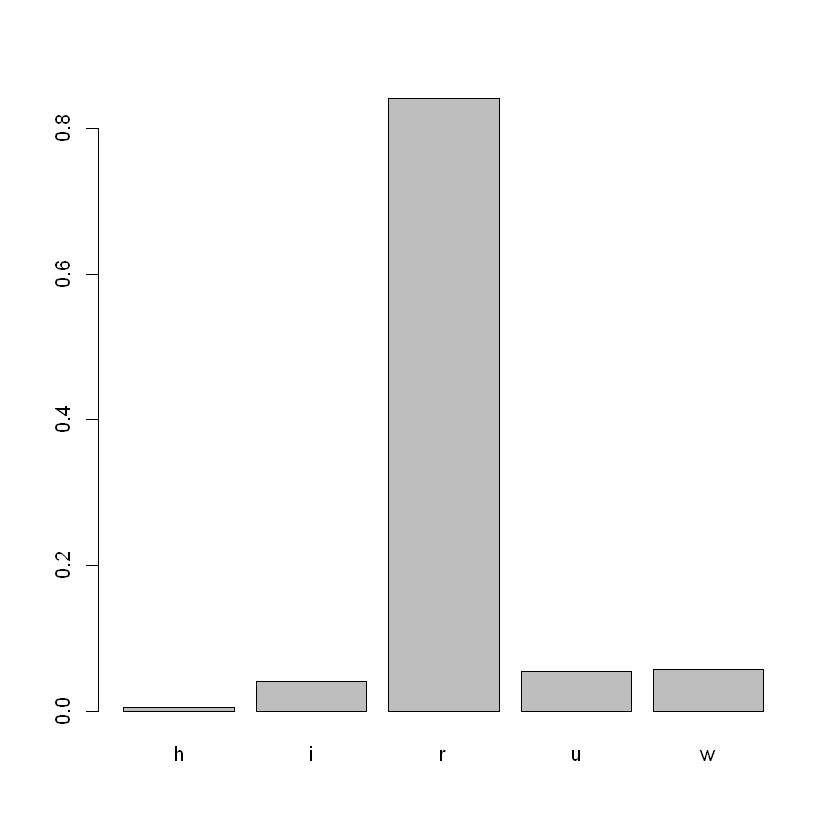

In [55]:
barplot(prop.table(table(rawdataset$foundation_type)))

In this case, we observe that 'h' values are really sub-represented. There exists advanced methods that handle very effectively the problem of unbalanced data: oversampling, that tends to overfitting, and undersampling, that represent a loss of information. A very interesting function for that is the smotenc() function in R, that generate new instances of the minority values using nearest neighbors. However, *“Simplicity is the ultimate sophistication”*, as once said Leonardo da Vinci. We do not believe that such complications are necessary for the moment. We will instead try to assign the small minority to the 4 others, keeping the same distribution. Concretely, we replace each instances with values 'h', to one of the values 'i','r','u','w', with the propabilities corresponding to the proportionnailty of each values in the dataset

$$
n_{\text{tot,-h}}=\# i +\# r +\# u  +\# w\quad\quad\quad
\begin{equation*}
'h' \rightarrow
\begin{cases}
    'i'\quad \text{with prob }= \frac{\# i}{n_{\text{tot,-h}}}\\
    'r'\quad \text{with prob }= \frac{\# r}{n_{\text{tot,-h}}}\\
    'u'\quad \text{with prob }= \frac{\# u}{n_{\text{tot,-h}}}\\
    'w' \quad \text{with prob }= \frac{\# w}{n_{\text{tot,-h}}}\\
\end{cases}
\end{equation*}
$$

This way we avoid these kind of 'outliers' and still keep almost the same distribution. But this not all, our method is also **part of a time-saving dynamic**: in the following, we'll see that some model require numerical encoding. We'll specifically use one-hot encoding for some of the columns, hence getting rid of one value **reduces the dimension of the one-hot encoding** by 1! Of course, to loose 1 dimension is not enough to make the **difference**, but it will be the case if we **keep this reasoning in the future** ! In the following, we'll refer to this section for the method used to handle sub-represented data !

Finally, let's just have a look at the percentage of row impacted 

In [56]:
#Nb row impacted : 0.55%
nrow(rawdataset[rawdataset$foundation_type=='h',])/nrow(rawdataset)*100

[1] 0.5556387

#### Analysis of **roof_type** 

(type: categorical): type of roof used while building. Possible values: n, q, x.

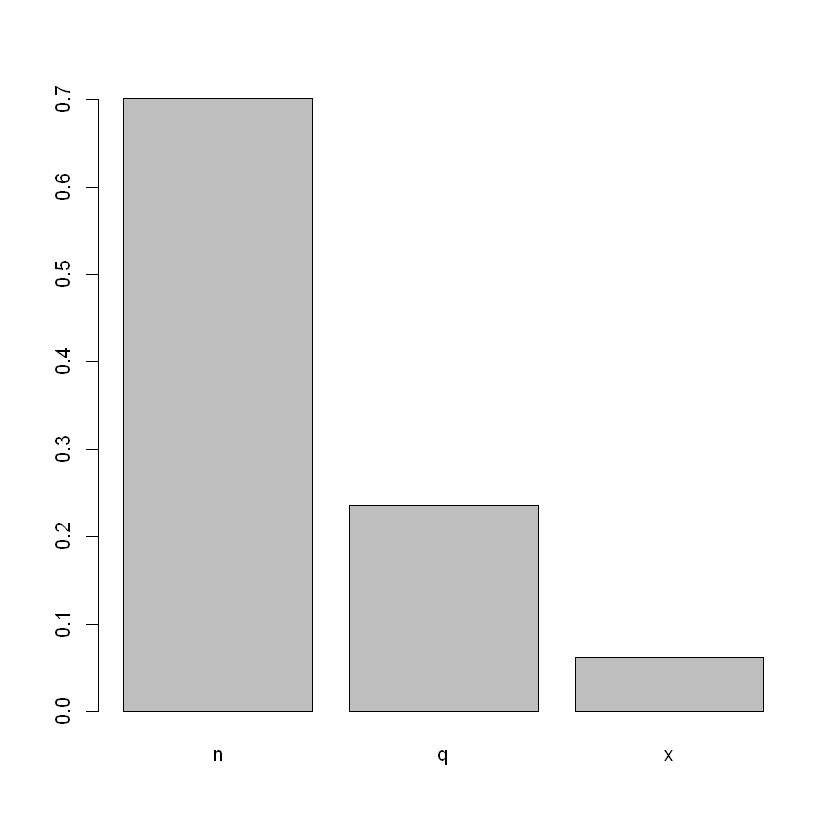

In [4]:
barplot(prop.table(table(rawdataset$roof_type)))

Looks good, nothing to change

#### Analysis of **ground_floor_type** 

(type: categorical): type of the ground floor. Possible values: f, m, v, x, z.

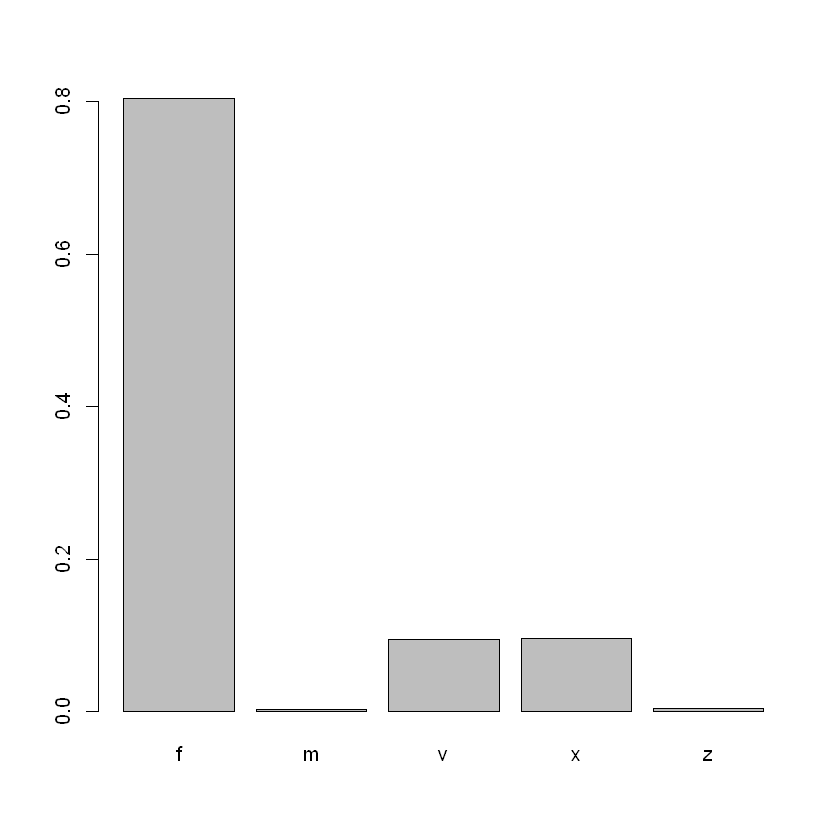

In [57]:
barplot(prop.table(table(rawdataset$ground_floor_type)))

Here we face the same problem as with foundation type, for 'm' and 'z' values. For the processing of theses specific rows, see the details in [Analysis of **foundation_type** ](#Analysis-of-foundation_type).

Let us check the percentage of rows impacted:

In [6]:
nrow(rawdataset[rawdataset$ground_floor_type=='m',])/nrow(rawdataset)*100     #less than 0.2%
nrow(rawdataset[rawdataset$ground_floor_type == 'z',])/nrow(rawdataset)*100     #less than 0.4%

[1] 0.194934

[1] 0.3852633

#### Analysis of **other_floor_type**

(type: categorical): type of constructions used in higher than the ground floors (except of roof). Possible values: j, q, s, x.

   Length     Class      Mode 
   260601 character character 

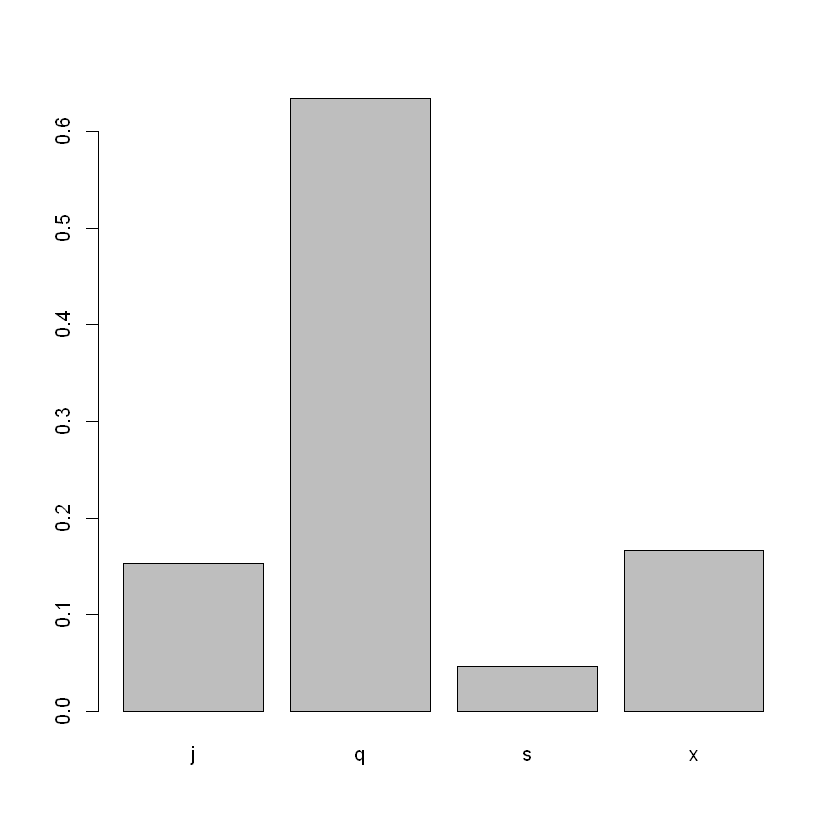

In [8]:
barplot(prop.table(table(rawdataset$other_floor_type)))

The 's' category looks small, let us check in which proportion:

In [10]:
nrow(rawdataset[rawdataset$other_floor_type=='s',])/nrow(rawdataset)*100 #Almost 5% of the data 

[1] 4.615485

It is enough for us, we don't touch the value

#### Analysis of **position**

(type: categorical): position of the building. Possible values: j, o, s, t

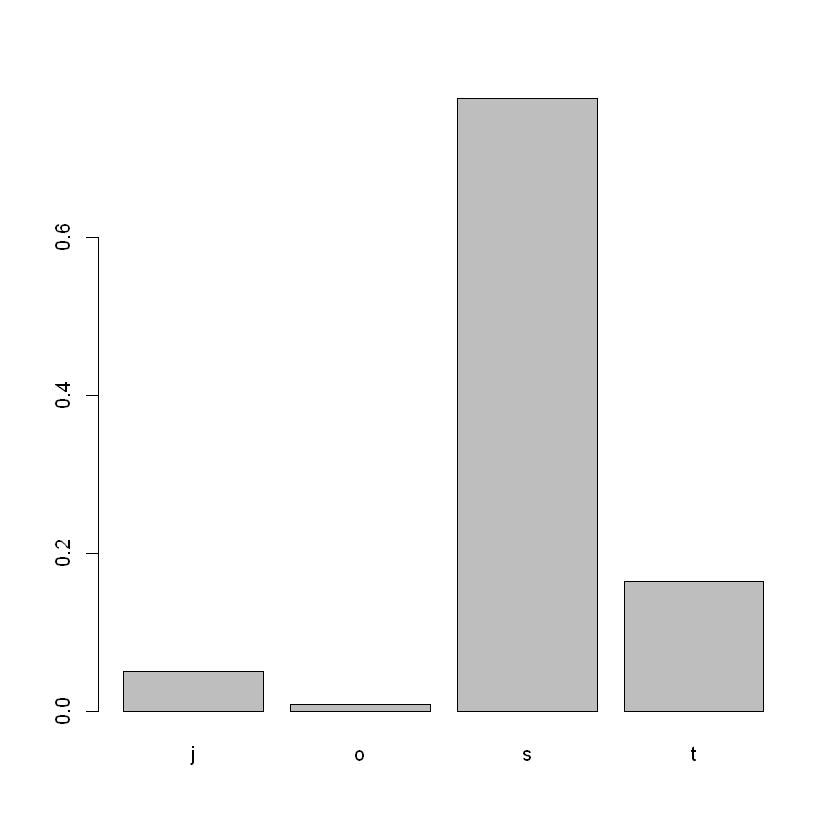

In [11]:
barplot(prop.table(table(rawdataset$position)))

Now it is the 'o' category which is minoritary, let's compute:

In [12]:
nrow(rawdataset[rawdataset$position=='o',])/nrow(rawdataset)*100

[1] 0.8952383

Still less than 1%, we will adopt strategy used in [Analysis of **foundation_type** ](#Analysis-of-foundation_type).

#### Analysis of **plan_configuration**

(type: categorical): building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.

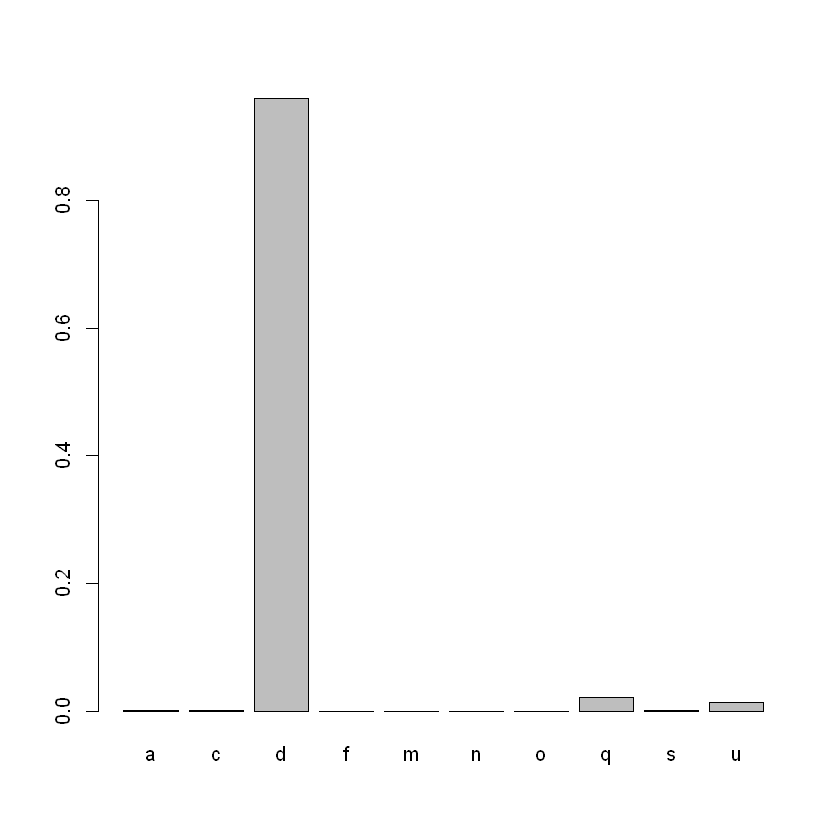

In [13]:
barplot(prop.table(table(rawdataset$plan_configuration)))

We observe for this feature, an extreme majority of the instances is being assigned to 'd'; it constitutes more than 95% of the data :

In [14]:
nrow(rawdataset[rawdataset$plan_configuration=='d',])/nrow(rawdataset)*100

[1] 95.95972

Again, this categorical feature might be subject in the futur to one-hot encoding. If we want to select and contain efficiently the number of dimension of feature space, it would be the good time to replace the values that are way too sub-represented. As only one value ('d') consitutes almost 96% of the data, and the others are scattered around, we find reasonable to assign each value to ('d'), as we would do in the previous reasoning. This means that now the feature *plan_configuration* does not contain any usefull information (now they are all the same) and that we can now suppress it.

Our decision was also **supported by the importance features ranking given by a Random Forest**,
: we observe that *plan_configuration* has **little relevance** in the construction of a RF (see section [Random Forest](#Random-Forest)). This further **legitimises the idea of separating from this column**.

Of course, we're aware that this represent a loss of information. But this is a constant battle bewteen processing time of the model/ accuracy of the model. We do believe that the gain of processing will be much greater than the loss of accuracy; in fact this will be proven later in the Notebook !

#### Analysis of **has_superstructure**

has_superstructure_adobe_mud (type: binary): flag variable that indicates if the superstructure was made of Adobe/Mud.

has_superstructure_mud_mortar_stone (type: binary): flag variable that indicates if the superstructure was made of Mud Mortar - Stone.

has_superstructure_stone_flag (type: binary): flag variable that indicates if the superstructure was made of Stone.

has_superstructure_cement_mortar_stone (type: binary): flag variable that indicates if the superstructure was made of Cement Mortar - Stone.

has_superstructure_mud_mortar_brick (type: binary): flag variable that indicates if the superstructure was made of Mud Mortar - Brick.

has_superstructure_cement_mortar_brick (type: binary): flag variable that indicates if the superstructure was made of Cement Mortar - Brick.

has_superstructure_timber (type: binary): flag variable that indicates if the superstructure was made of Timber.

has_superstructure_bamboo (type: binary): flag variable that indicates if the superstructure was made of Bamboo.

has_superstructure_rc_non_engineered (type: binary): flag variable that indicates if the superstructure was made of non-engineered reinforced concrete.

has_superstructure_rc_engineered (type: binary): flag variable that indicates if the superstructure was made of engineered reinforced concrete.

has_superstructure_other (type: binary): flag variable that indicates if the superstructure was made of any other material.

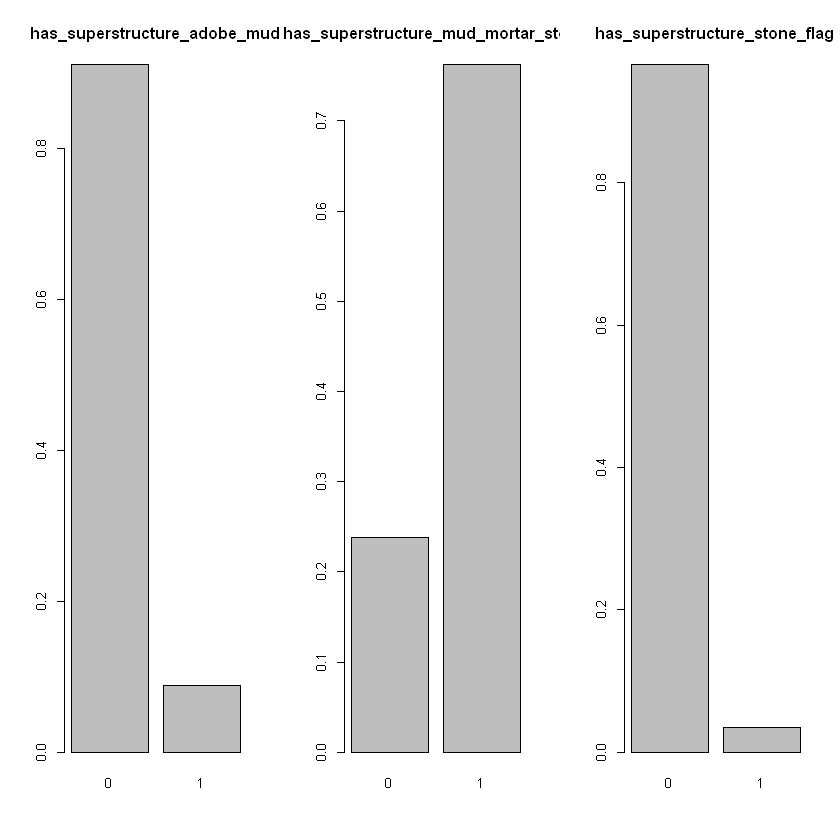

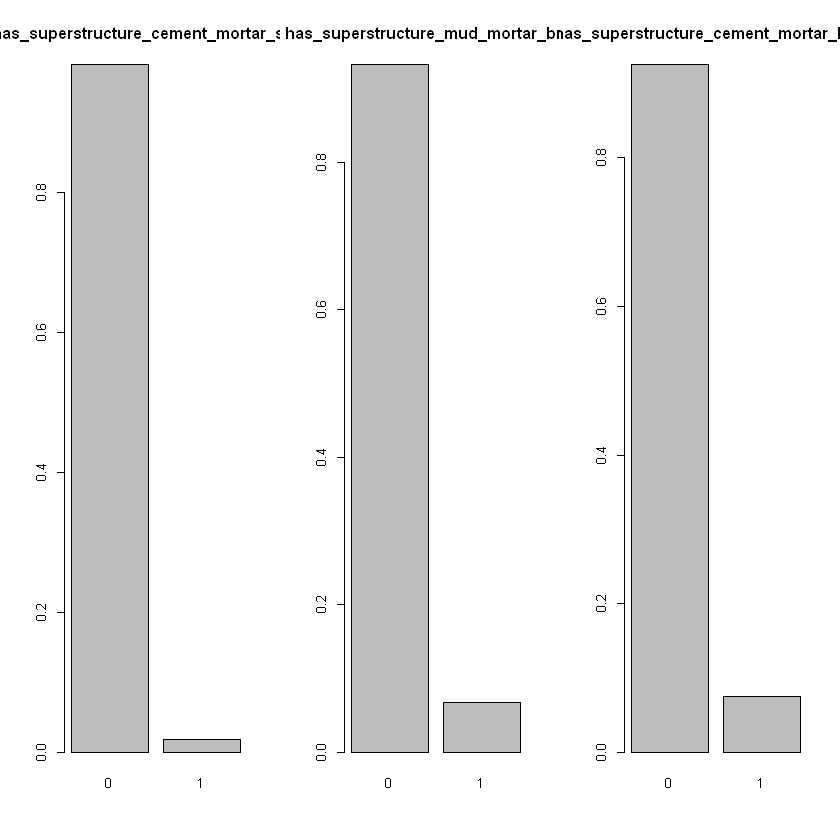

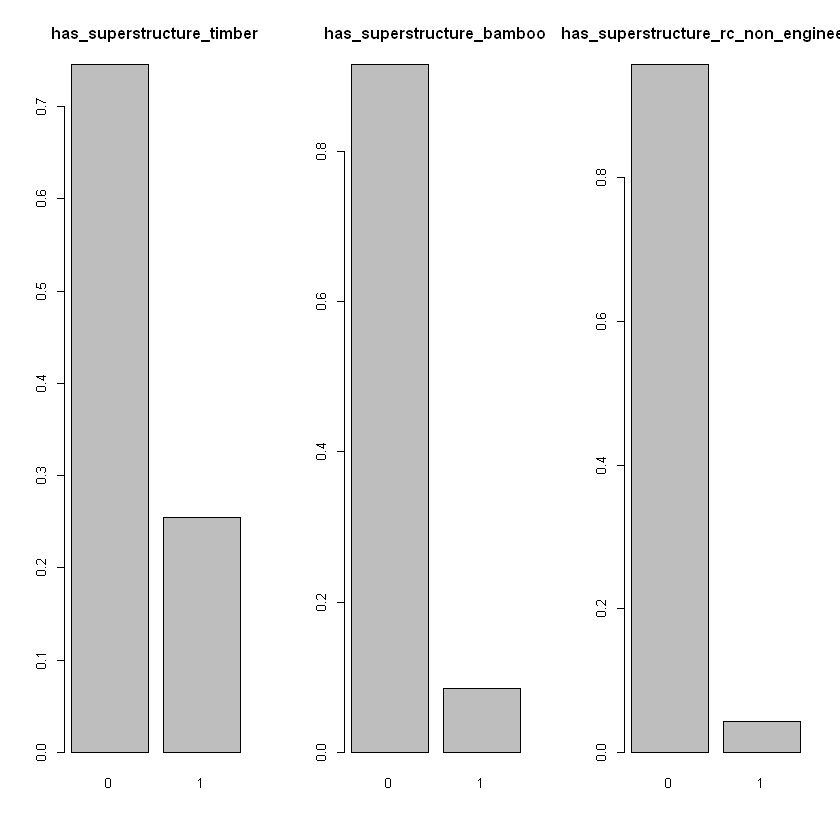

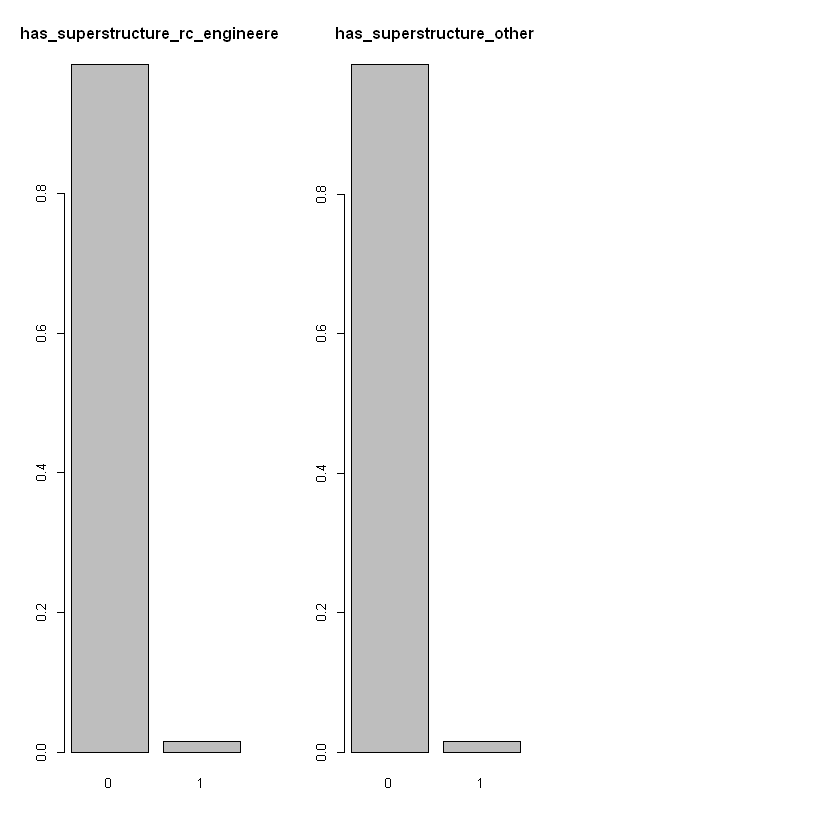

In [16]:
par(mfrow=c(1,3))
barplot(prop.table(table(rawdataset$has_superstructure_adobe_mud)),main = 'has_superstructure_adobe_mud')
barplot(prop.table(table(rawdataset$has_superstructure_mud_mortar_stone)),main = 'has_superstructure_mud_mortar_stone')
barplot(prop.table(table(rawdataset$has_superstructure_stone_flag)),main = 'has_superstructure_stone_flag')
barplot(prop.table(table(rawdataset$has_superstructure_cement_mortar_stone)),main = 'has_superstructure_cement_mortar_stone')
barplot(prop.table(table(rawdataset$has_superstructure_mud_mortar_brick)),main = 'has_superstructure_mud_mortar_brick')
barplot(prop.table(table(rawdataset$has_superstructure_cement_mortar_brick)),main = 'has_superstructure_cement_mortar_brick')
barplot(prop.table(table(rawdataset$has_superstructure_timber)),main = 'has_superstructure_timber')
barplot(prop.table(table(rawdataset$has_superstructure_bamboo)),main = 'has_superstructure_bamboo')
barplot(prop.table(table(rawdataset$has_superstructure_rc_non_engineered)),main = 'has_superstructure_rc_non_engineered')
barplot(prop.table(table(rawdataset$has_superstructure_rc_engineered)),main = 'has_superstructure_rc_engineered')
barplot(prop.table(table(rawdataset$has_superstructure_other)),main = 'has_superstructure_other')

We observe that some features are again too sub-represented, in particular *has_superstructure_cement_mortar_brick*, *has_superstructure_other* and *has_superstructure_rc_engineered*. We propose to replace them by the other values: this is equivalent to delete the column. Lets have a look at the percentage of rows impacted:

In [18]:
nrow(rawdataset[rawdataset$has_superstructure_cement_mortar_stone==1,])/nrow(rawdataset)*100
nrow(rawdataset[rawdataset$has_superstructure_other==1,])/nrow(rawdataset)*100
nrow(rawdataset[rawdataset$has_superstructure_rc_engineered==1,])/nrow(rawdataset)*100

[1] 1.823477

[1] 1.498459

[1] 1.585949

Still the order of 1%, we find it reasonable.

#### Analysis of **legal_ownership_status**

(type: categorical): legal ownership status of the land where building was built. Possible values: a, r, v, w

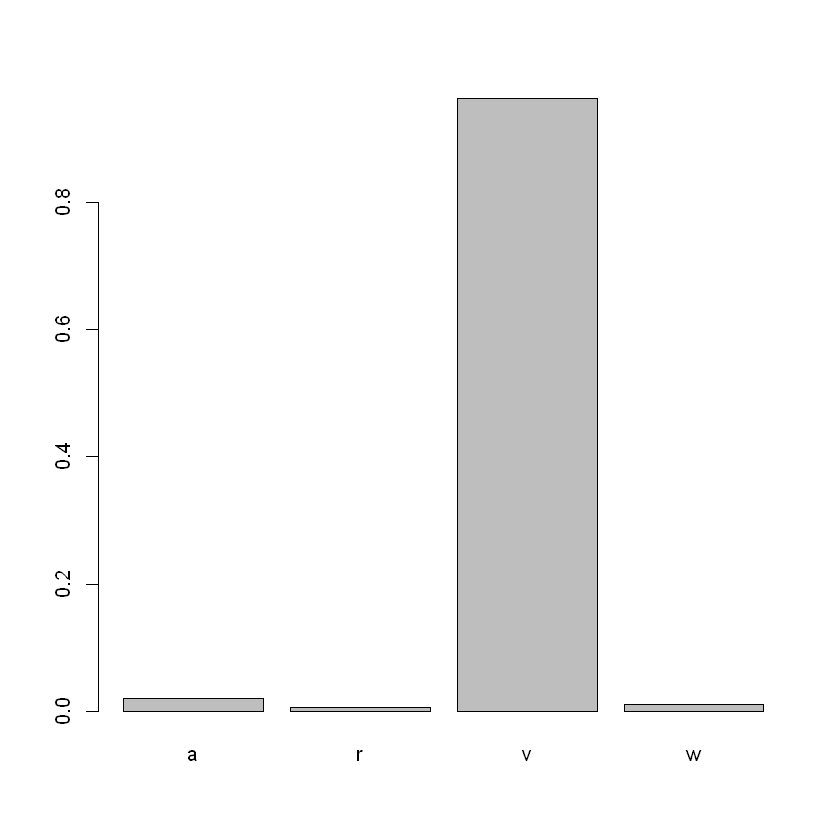

In [19]:
barplot(prop.table(table(rawdataset$legal_ownership_status)))

Same situation as in [Analysis of **plan_configuration**](#Analysis-of-plan_configuration). The over-represented value 'v' represents more than 96% of the data :

In [20]:
nrow(rawdataset[rawdataset$legal_ownership_status=='v',])/nrow(rawdataset)*100

[1] 96.29242

To have a second opinion, we turn again to the ranking given by a RF algorithm given in [Random Forest](#Random-Forest). As a matter of fact, `legal_ownership_status` has little relevance according to the RF: this encourages us once again to assign every values to 'v', and eventually delete this column. If this column had been subject to one-hot encoding, we'd gain 4 dimensions!

#### Analysis of **count_families**

(type: int): number of families that live in the building

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9839  1.0000  9.0000 

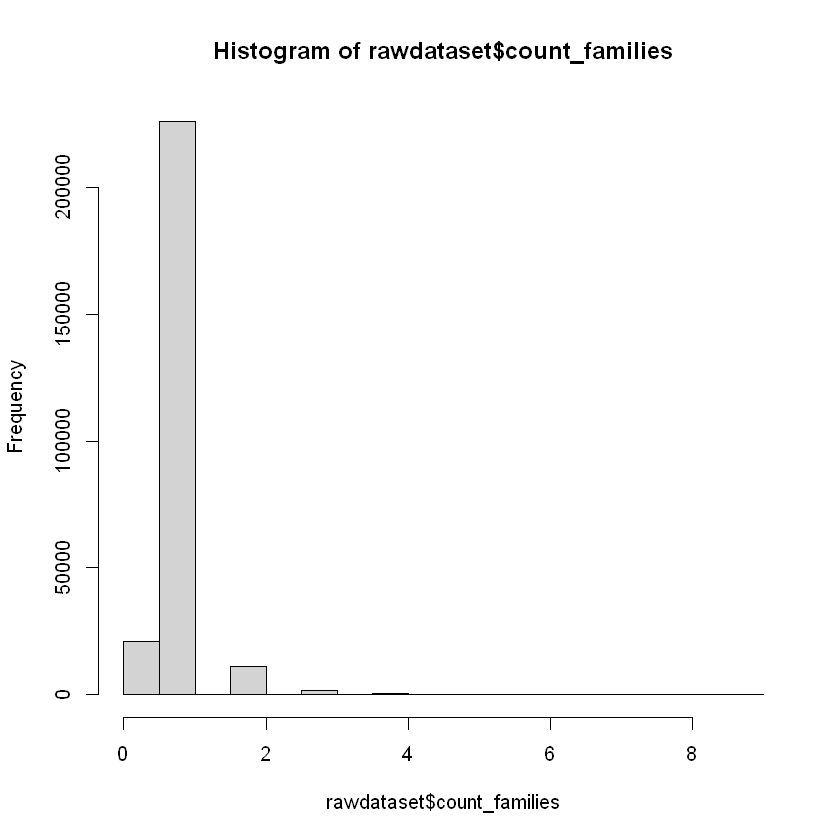

In [21]:
summary(rawdataset$count_families)
hist(rawdataset$count_families)

Let us look for outliers:

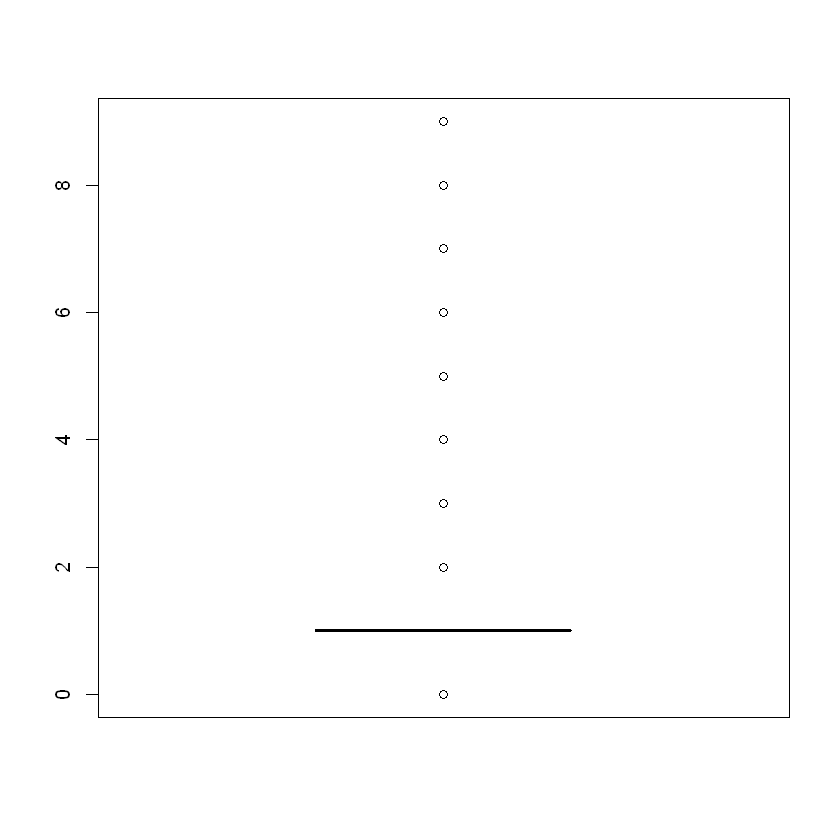

In [22]:
boxplot(rawdataset$count_families)

Again, the distribution is higly peaked at ~1. Looking at graphic #1, we find more than reasonable to replace the outliers at `count_families` > 3 by the mean. Let's have a look at the percentage of row impacted (only 0.2%):

In [27]:
nrow(rawdataset[rawdataset$count_families>3,])/nrow(rawdataset)*100

[1] 0.2026086

#### Analysis of **has_secondary_use** 

(type: binary): flag variable that indicates if the building was used for any secondary purpose.

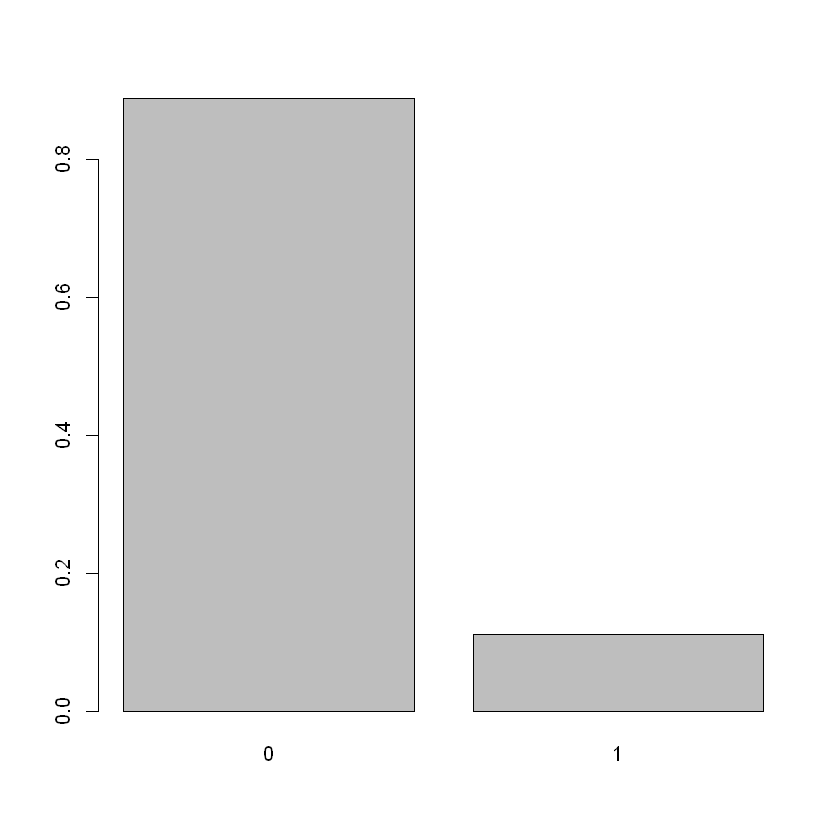

In [28]:
barplot(prop.table(table(rawdataset$has_secondary_use)))

Looks good for us, enough data for '1' value

#### Analysis of **has_secondary_use**-like categories 

has_secondary_use_agriculture (type: binary): flag variable that indicates if the building was used for agricultural purposes.

has_secondary_use_hotel (type: binary): flag variable that indicates if the building was used as a hotel.

has_secondary_use_rental (type: binary): flag variable that indicates if the building was used for rental purposes.

has_secondary_use_institution (type: binary): flag variable that indicates if the building was used as a location of any institution.

has_secondary_use_school (type: binary): flag variable that indicates if the building was used as a school.

has_secondary_use_industry (type: binary): flag variable that indicates if the building was used for industrial purposes.

has_secondary_use_health_post (type: binary): flag variable that indicates if the building was used as a health post.

has_secondary_use_gov_office (type: binary): flag variable that indicates if the building was used fas a government office.

has_secondary_use_use_police (type: binary): flag variable that indicates if the building was used as a police station.

has_secondary_use_other (type: binary): flag variable that indicates if the building was secondarily used for other purposes.

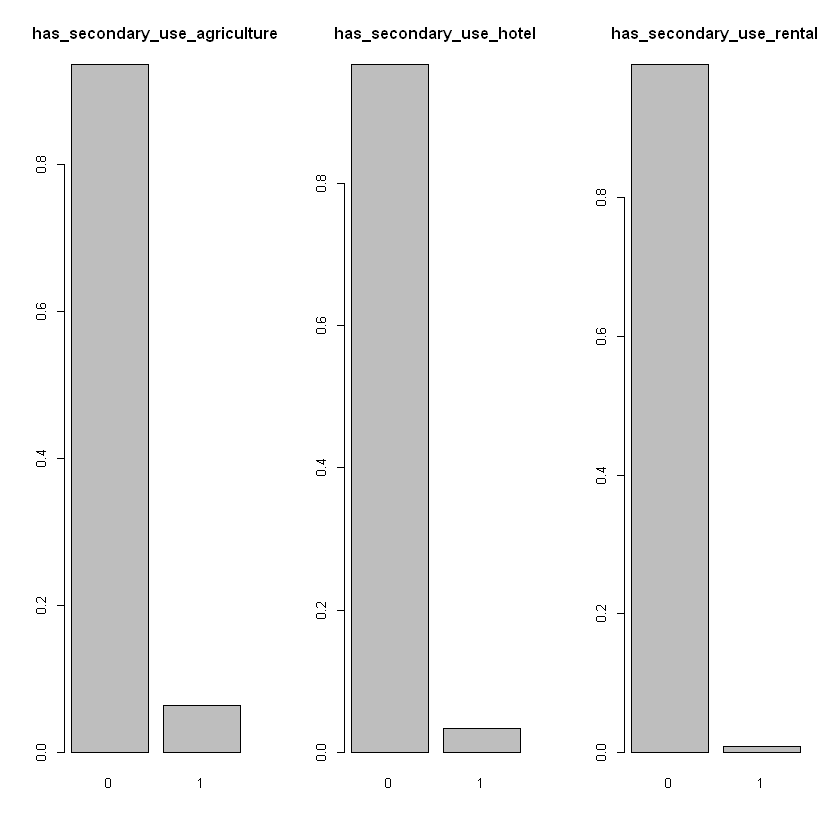

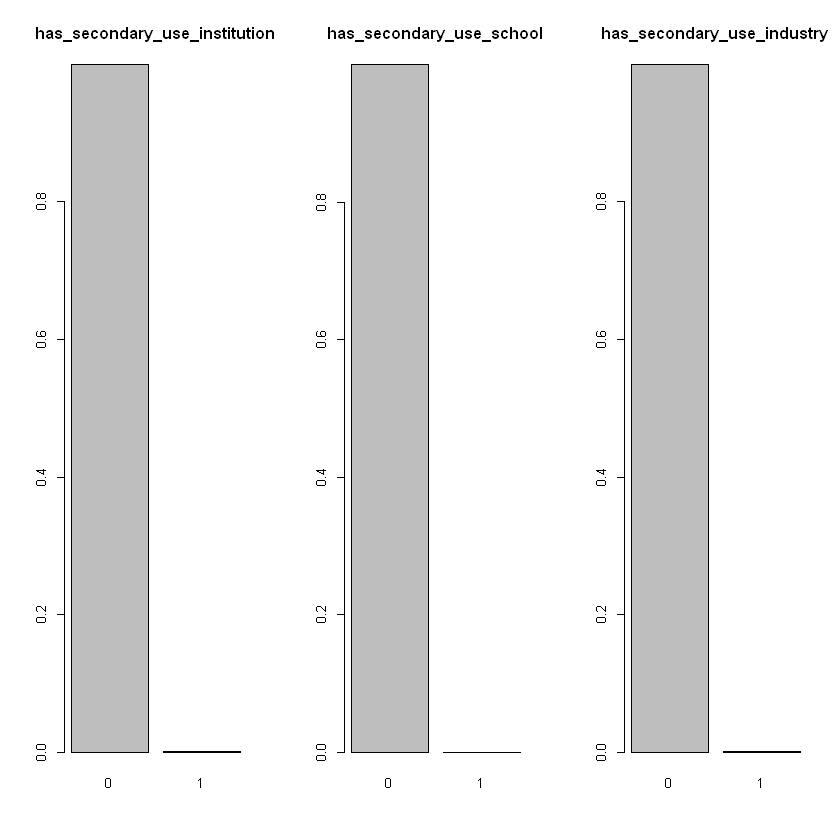

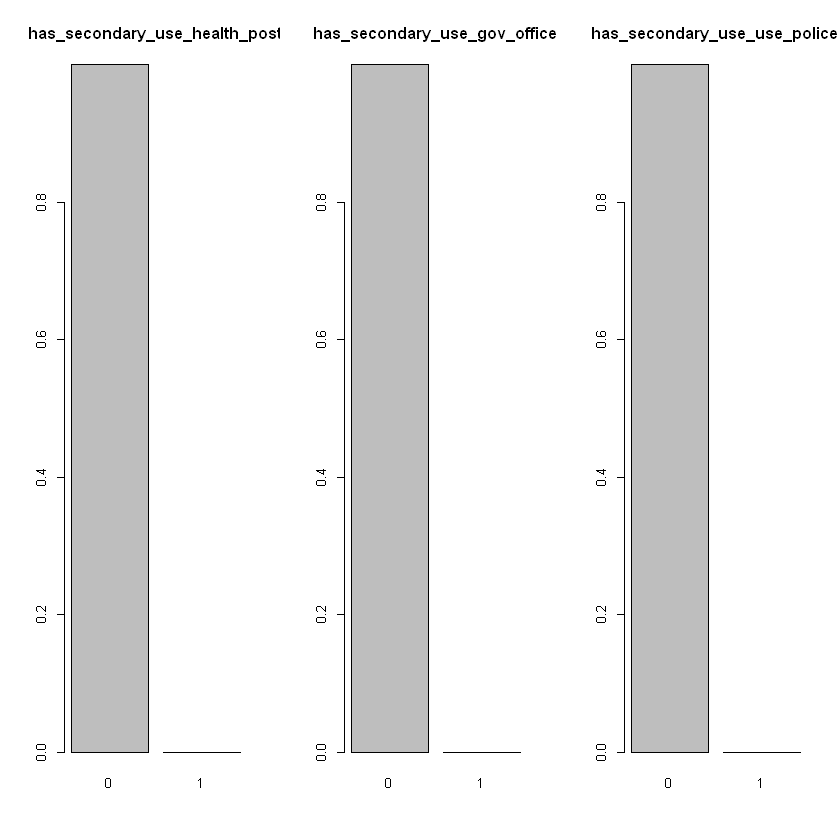

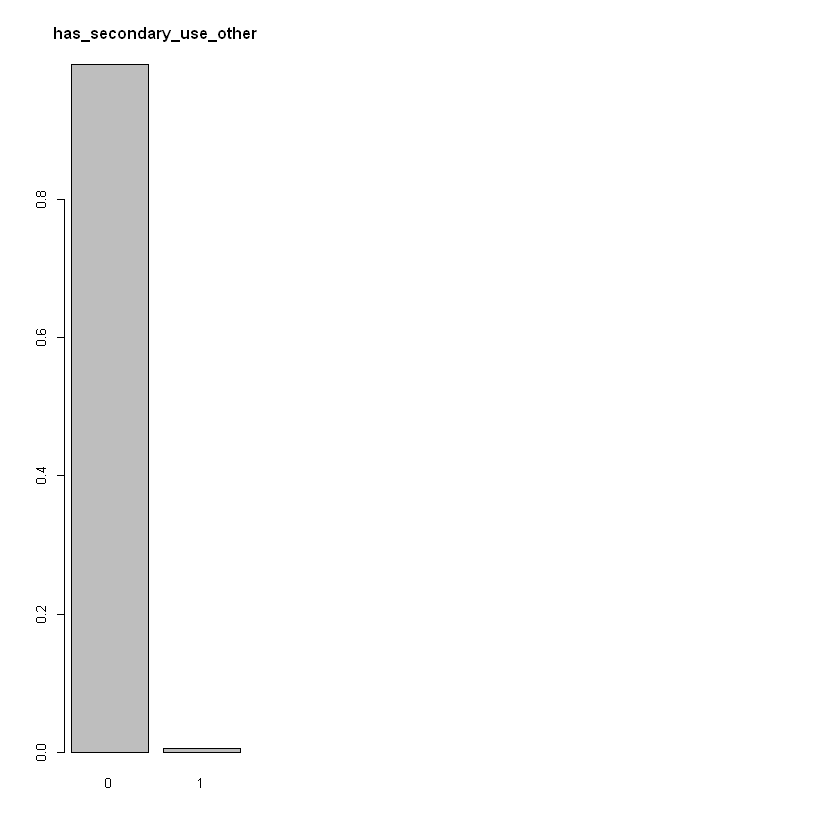

In [29]:
par(mfrow=c(1,3))
barplot(prop.table(table(rawdataset$has_secondary_use_agriculture)),main = 'has_secondary_use_agriculture')
barplot(prop.table(table(rawdataset$has_secondary_use_hotel)),main = 'has_secondary_use_hotel')
barplot(prop.table(table(rawdataset$has_secondary_use_rental)),main = 'has_secondary_use_rental')
barplot(prop.table(table(rawdataset$has_secondary_use_institution)),main = 'has_secondary_use_institution')
barplot(prop.table(table(rawdataset$has_secondary_use_school)),main = 'has_secondary_use_school')
barplot(prop.table(table(rawdataset$has_secondary_use_industry)),main = 'has_secondary_use_industry')
barplot(prop.table(table(rawdataset$has_secondary_use_health_post)),main = 'has_secondary_use_health_post')
barplot(prop.table(table(rawdataset$has_secondary_use_gov_office)),main = 'has_secondary_use_gov_office')
barplot(prop.table(table(rawdataset$has_secondary_use_use_police)),main = 'has_secondary_use_use_police')
barplot(prop.table(table(rawdataset$has_secondary_use_other)),main = 'has_secondary_use_other')

Some features are way too sub-represented here: this is the case for: 
`has_secondary_use_rental`,`has_secondary_use_institution`,`has_secondary_use_school`,
`has_secondary_use_industry`,`has_secondary_use_health_post`,`has_secondary_use_gov_office`,
`has_secondary_use_use_police`,`has_secondary_use_other`

We encounter the same situation as in section [Analysis of **has_superstructure**](#Analysis-of-has_superstructure): for those column, we suggest to replace the tiny minority by the majority, hence deleting this column. The low impact is also guaranteed by the fact that we observe low relevance in the ranking of a RF, see section [Random Forest](#Random-Forest).

### Data Cleaning

In this section, we will implement the strategy and the conclusions that we drew in the previous section.

#### Implementation Code

For the strategy used to clean integer features, see the corresponding analysis in [Data overview](#Data-overview).

For the strategy used to clean categorical features, see e.g. in [Analysis of **plan_configuration**](#Analysis-of-plan_configuration).

In [10]:
initial_size <- nrow(rawdataset)

In [11]:
dataset <- rawdataset

#### Cleaning of integers variable

#Cleaning of count_floors_pre_eq (int)
mean_count_floors_pre_eq <- mean(rawdataset$count_floors_pre_eq)
dataset[rawdataset$count_floors_pre_eq>4,'count_floors_pre_eq'] <- round(mean_count_floors_pre_eq,digits = 6)  #take the closest integer ot the mean
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)   #check that we didn't loose any rows
print(loss)

#Cleaning of age (int)
mean_age <- mean(rawdataset$age)
dataset[dataset$age >200,'age'] <- round(mean_age,digits = 6) 
loss <- signif((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)

#Cleaning of area_percentage (int)
mean_area_percentage <- mean(rawdataset$area_percentage)
dataset[dataset$area_percentage >30,'area_percentage'] <- round(mean_area_percentage,digits = 6) 
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)

#Cleaning of height_percentage (int)
mean_height_percentage <- mean(rawdataset$height_percentage)
dataset[dataset$height_percentage >13,'height_percentage'] <- round(mean_height_percentage,digits = 6) 
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)

#Cleaning of count_families (int)
mean_count_families <- mean(rawdataset$count_families)
dataset[dataset$count_families >3,'height_percentage'] <- round(mean_count_families,digits = 6) 
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)

[1] 0
[1] 0
[1] 0
[1] 0
[1] 0


In [12]:
#### Cleaning of categorical features

#Cleaning of land_surface_condition (minority type: 'o')

#We take the count
count_land_surface_condition <- aggregate(rawdataset$land_surface_condition, by = list(rawdataset$land_surface_condition),FUN=length)
#We count the total number of the majority class n_tot,o = #n + #t
sum_nt <- sum(count_land_surface_condition[count_land_surface_condition$Group.1 %in% c('n','t'),2])
#We count the total number of the minority class #o
sum_o <- sum(count_land_surface_condition[count_land_surface_condition$Group.1 %in% c('o'),2])
#We compute the proportion of each value of maj. class in n_tot,o
percentage <- count_land_surface_condition[count_land_surface_condition$Group.1 %in% c('n','t'),2]/sum_nt
#We replace 'o' to one of the others values, with prob corresponding to the proportion of the value, to keep the same distribution
dataset[dataset$land_surface_condition %in% c('o'),'land_surface_condition'] <- sample(c('n','t'),size = sum_o,prob = percentage,replace = TRUE)
#Check if we didn't loose any row
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)

#Cleaning of foundation_type (minority type: 'h')

#Same commentary as above
count_foundation_type <- aggregate(rawdataset$foundation_type, by = list(rawdataset$foundation_type),FUN=length)
sum_iruw <- sum(count_foundation_type[count_foundation_type$Group.1 %in% c('i','r','u','w'),2])
sum_h <- sum(count_foundation_type[count_foundation_type$Group.1 %in% c('h'),2])
percentage <- count_foundation_type[count_foundation_type$Group.1 %in% c('i','r','u','w'),2]/sum_iruw
dataset[dataset$foundation_type %in% c('h'),'foundation_type'] <- sample(c('i','r','u','w'),size = sum_h,prob = percentage,replace = TRUE)
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)


#Cleaning of ground_floor_type (minority type:  'm' and 'z')

#Same commentary as above
count_ground_floor_type <- aggregate(rawdataset$ground_floor_type, by = list(rawdataset$ground_floor_type),FUN=length)
sum_fvx <- sum(count_ground_floor_type[count_ground_floor_type$Group.1 %in% c('f','v','x'),2])
sum_mz <- sum(count_ground_floor_type[count_ground_floor_type$Group.1 %in% c('m','z'),2])
percentage <- count_ground_floor_type[count_ground_floor_type$Group.1 %in% c('f','v','x'),2]/sum_fvx
dataset[dataset$ground_floor_type %in% c('m','z'),'ground_floor_type'] <- sample(c('f','v','x'),size = sum_mz,prob = percentage,replace = TRUE)
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)

#Cleaning of position (minority type: 'o')

#Same commentary as above
count_position <- aggregate(rawdataset$position, by = list(rawdataset$position),FUN=length)
sum_jst <- sum(count_position[count_position$Group.1 %in% c('j','s','t'),2])
sum_o <- sum(count_position[count_position$Group.1 %in% c('o'),2])
percentage <- count_position[count_position$Group.1 %in% c('j','s','t'),2]/sum_jst
dataset[dataset$position %in% c('o'),'position'] <- sample(c('j','s','t'),size = sum_o,prob = percentage,replace = TRUE)
loss <- round((1-nrow(dataset)/initial_size)*100 ,digits = 6)
print(loss)

[1] 0
[1] 0
[1] 0
[1] 0


In [13]:
#Features to be deleted, considered by both our analysis and the RF ranking as irrelevant

feature_to_delete <- c('plan_config','has_superstructure_cement_mortar_stone','has_superstructure_rc_engineered',
                        'has_superstructure_other','legal_ownership_status','has_secondary_use_rental' ,
                        'has_secondary_use_institution','has_secondary_use_school', 'has_secondary_use_industry',
                        'has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police',
                        'has_secondary_use_other')

dataset <- dataset %>% select(-any_of(feature_to_delete))
print(paste0('The number of features has been reduced from ',as.character(ncol(rawdataset)-1),' to ',ncol(dataset)-1))

[1] "The number of features has been reduced from 38 to 26"


In [7]:
#Write it into a csv file

write.csv(dataset,file = 'Data/training_data_cleaned.csv', row.names=FALSE,fileEncoding = "UTF-8")

#### Cleaning view

It always nice to have a graphic view of what happened ! Let us take for example an integer category first, like `count_floors_pre_eq`, for which we replace outliers at >4 by the round(mean)

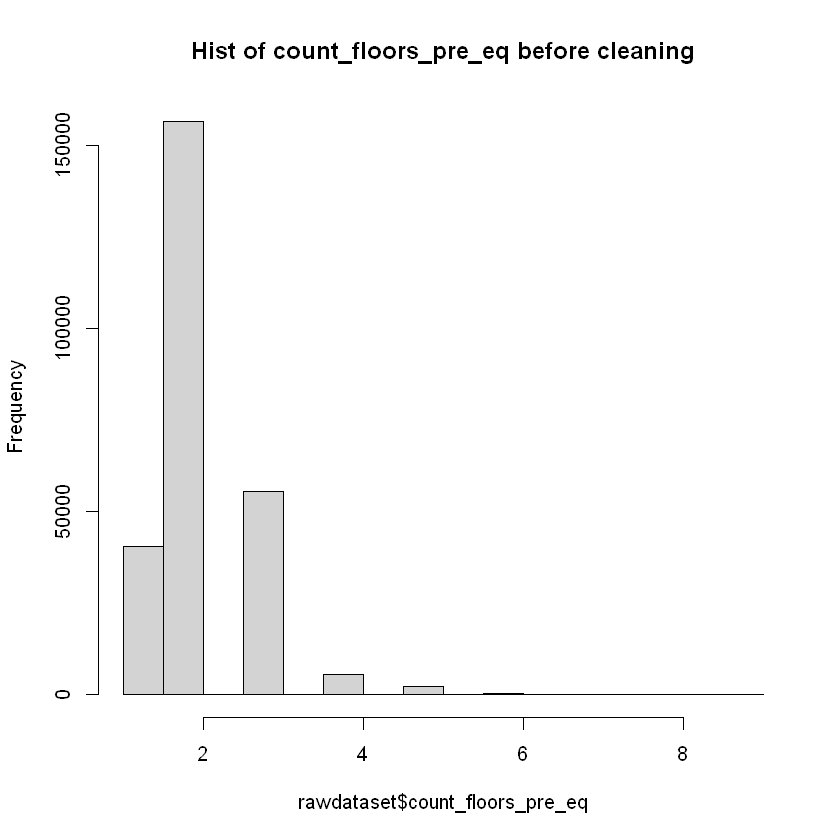

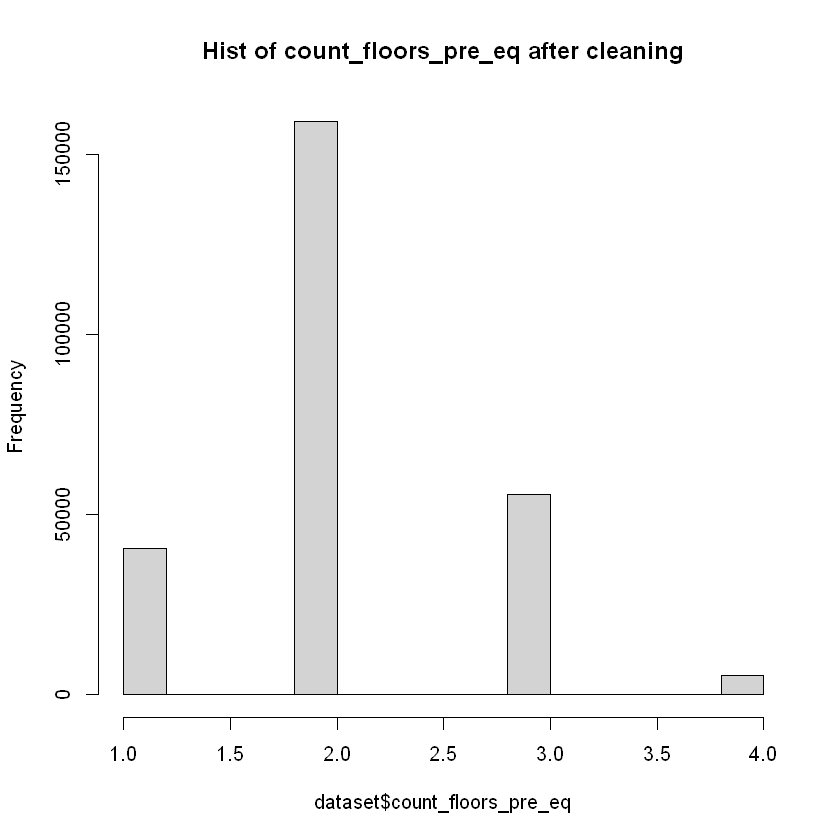

In [40]:
hist(rawdataset$count_floors_pre_eq,main='Hist of count_floors_pre_eq before cleaning')   #rawdataset)
hist(dataset$count_floors_pre_eq,main='Hist of count_floors_pre_eq after cleaning')   #cleaned dataset

We get the same shape of the distribution, without the annoying outliers at 5,6,7,... that have a extremly small count.

Now, for categorical variable, let us take the example of `foundation_type`

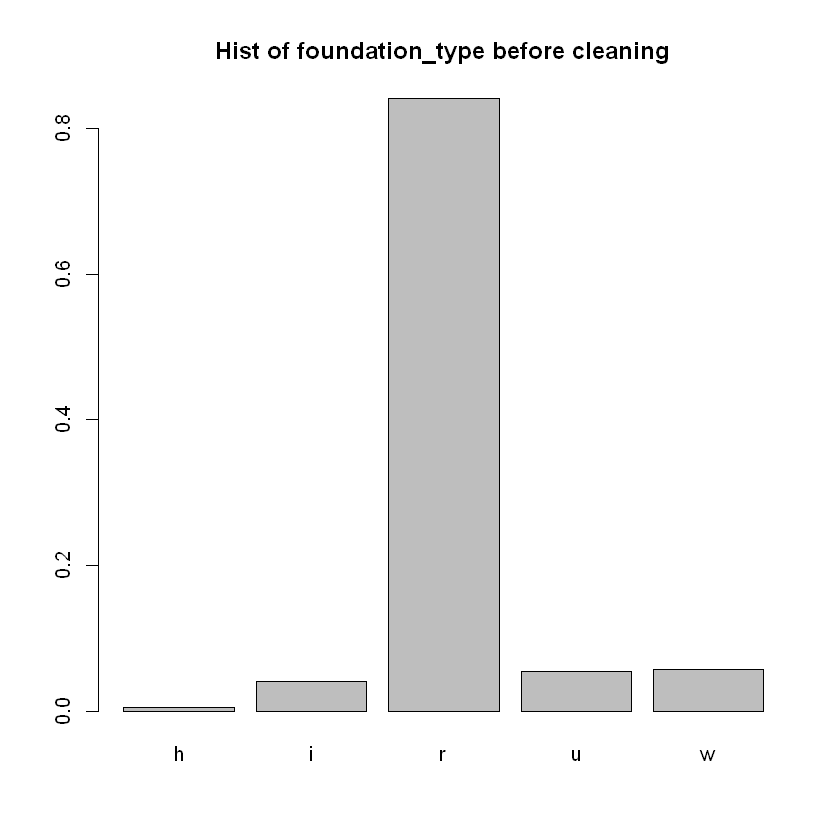

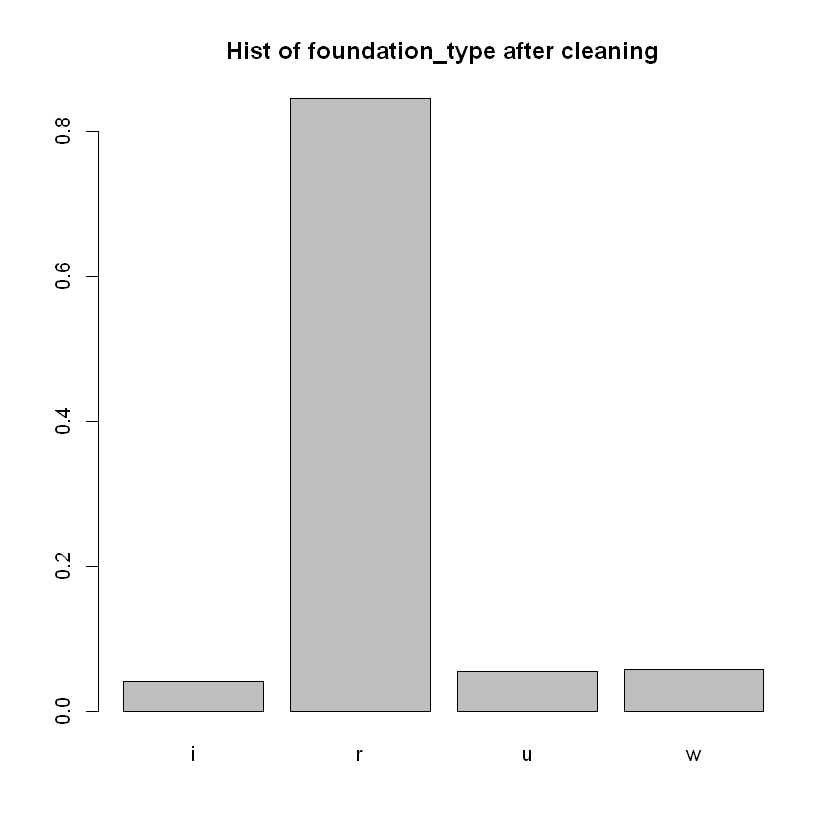

In [41]:
barplot(prop.table(table(rawdataset$foundation_type)),main='Hist of foundation_type before cleaning')    #rawdataset
barplot(prop.table(table(dataset$foundation_type)),main='Hist of foundation_type after cleaning') 

We still have the same distribution for values with enough instances, without loosing any rows, just by replacing !

#### Cleaning the test set

Now that we have cleaned the training data, we will apply the same transformations to the test dataset.

In [3]:
test_values <- read.csv('Data/test_values.csv',header = TRUE,sep = ',')
raw_test_values <- test_values %>% select(-(building_id))
initial_size = nrow(raw_test_values)

In [4]:
test_values_cleaned <- raw_test_values

 

##### Cleaning of integers variable

 

#Cleaning of count_floors_pre_eq (int)

mean_count_floors_pre_eq <- mean(raw_test_values$count_floors_pre_eq)

test_values_cleaned[raw_test_values$count_floors_pre_eq>4,'count_floors_pre_eq'] <- round(mean_count_floors_pre_eq,digits  =6)  #take the closest integer ot the mean

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)   #check that we didn't loose any rows

print(loss)

 

#Cleaning of age (int)

mean_age <- mean(raw_test_values$age)

test_values_cleaned[test_values_cleaned$age >200,'age'] <- round(mean_age,digits  =6)

loss <- signif((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

 

#Cleaning of area_percentage (int)

mean_area_percentage <- mean(raw_test_values$area_percentage)

test_values_cleaned[test_values_cleaned$area_percentage >30,'area_percentage'] <- round(mean_area_percentage,digits  =6)

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

 

#Cleaning of height_percentage (int)

mean_height_percentage <- mean(raw_test_values$height_percentage)

test_values_cleaned[test_values_cleaned$height_percentage >13,'height_percentage'] <- round(mean_height_percentage,digits  =6)

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

 

#Cleaning of count_families (int)

mean_count_families <- mean(raw_test_values$count_families)

test_values_cleaned[test_values_cleaned$count_families >3,'height_percentage'] <- round(mean_count_families,digits  =6)

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

[1] 0
[1] 0
[1] 0
[1] 0
[1] 0


In [5]:
#Cleaning of land_surface_condition (minority type: 'o')

 

#We take the count

count_land_surface_condition <- aggregate(raw_test_values$land_surface_condition, by = list(raw_test_values$land_surface_condition),FUN=length)

#We count the total number of the majority class n_tot,o = #n + #t

sum_nt <- sum(count_land_surface_condition[count_land_surface_condition$Group.1 %in% c('n','t'),2])

#We count the total number of the minority class #o

sum_o <- sum(count_land_surface_condition[count_land_surface_condition$Group.1 %in% c('o'),2])

#We compute the proportion of each value of maj. class in n_tot,o

percentage <- count_land_surface_condition[count_land_surface_condition$Group.1 %in% c('n','t'),2]/sum_nt

#We replace 'o' to one of the others values, with prob corresponding to the proportion of the value, to keep the same distribution

test_values_cleaned[test_values_cleaned$land_surface_condition %in% c('o'),'land_surface_condition'] <- sample(c('n','t'),size = sum_o,prob = percentage,replace = TRUE)

#Check if we didn't loose any row

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

 

#Cleaning of foundation_type (minority type: 'h')

 

#Same commentary as above

count_foundation_type <- aggregate(raw_test_values$foundation_type, by = list(raw_test_values$foundation_type),FUN=length)

sum_iruw <- sum(count_foundation_type[count_foundation_type$Group.1 %in% c('i','r','u','w'),2])

sum_h <- sum(count_foundation_type[count_foundation_type$Group.1 %in% c('h'),2])

percentage <- count_foundation_type[count_foundation_type$Group.1 %in% c('i','r','u','w'),2]/sum_iruw

test_values_cleaned[test_values_cleaned$foundation_type %in% c('h'),'foundation_type'] <- sample(c('i','r','u','w'),size = sum_h,prob = percentage,replace = TRUE)

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

 

 

#Cleaning of ground_floor_type (minority type:  'm' and 'z')

 

#Same commentary as above

count_ground_floor_type <- aggregate(raw_test_values$ground_floor_type, by = list(raw_test_values$ground_floor_type),FUN=length)

sum_fvx <- sum(count_ground_floor_type[count_ground_floor_type$Group.1 %in% c('f','v','x'),2])

sum_mz <- sum(count_ground_floor_type[count_ground_floor_type$Group.1 %in% c('m','z'),2])

percentage <- count_ground_floor_type[count_ground_floor_type$Group.1 %in% c('f','v','x'),2]/sum_fvx

test_values_cleaned[test_values_cleaned$ground_floor_type %in% c('m','z'),'ground_floor_type'] <- sample(c('f','v','x'),size = sum_mz,prob = percentage,replace = TRUE)

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

 

#Cleaning of position (minority type: 'o')

 

#Same commentary as above

count_position <- aggregate(raw_test_values$position, by = list(raw_test_values$position),FUN=length)

sum_jst <- sum(count_position[count_position$Group.1 %in% c('j','s','t'),2])

sum_o <- sum(count_position[count_position$Group.1 %in% c('o'),2])

percentage <- count_position[count_position$Group.1 %in% c('j','s','t'),2]/sum_jst

test_values_cleaned[test_values_cleaned$position %in% c('o'),'position'] <- sample(c('j','s','t'),size = sum_o,prob = percentage,replace = TRUE)

loss <- round((1-nrow(test_values_cleaned)/initial_size)*100 ,digits = 6)

print(loss)

[1] 0
[1] 0
[1] 0
[1] 0


In [6]:
#Features to be deleted, considered by our analysis and RF as irrelevant

 

feature_to_delete <- c('plan_config','has_superstructure_cement_mortar_stone','has_superstructure_rc_engineered',

                        'has_superstructure_other','legal_ownership_status','has_secondary_use_rental' ,

                        'has_secondary_use_institution','has_secondary_use_school', 'has_secondary_use_industry',

                        'has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police',

                        'has_secondary_use_other')

 

test_values_cleaned <- test_values_cleaned %>% select(-any_of(feature_to_delete))

In [ ]:
#write.csv(dataset,file = 'Data/test_values_cleaned.csv', row.names=FALSE,fileEncoding = "UTF-8")

### Target encoding

As we have seen, the `geo_levels` features are categorical, but even if these categories are numerical, they are not ordinal, in the sense that there is no relationship between values. For instance, there is no notion of ranking and the difference between two values is meaningless. One says that these categorical variables are nominal. 

Since these features have no meaning as numbers per se, the models may treat them in a wrong way. This is even more of a problem when one knows that these features are higly correlated to the target. It is also natural to infer that the geographic regions, sub-regions and neighbourhoods can tell a lot about the intensity of the earthquake, and consequently about the building damages.

It is then natural to encode these categorical variables and to transform them to numbers. The simplest way to encode categorical variables is the one-hot encoding, where one generates a new column for each possible category, and put a $1$ in the corresponding category column and $0$ elsewhere. However, it yields a large number of new columns if the cardinality of the category is large. This implies that the dataset becomes very sparse (with a lot of $0$'s) and the number of features grows radically, both making it harder for the models to learn. In our particular problem, the feature `geo_level_3_id` may take value between $0$ and $12567$ and this would obviously result in an enormous number of features and fall into the so-called curse of dimensionality.

**Naive target encoding**

There are a lot of possible encodings that do better than one-hot encoding for numerous categorical values. Here we choose to use the target encoding. Basically, instead of dealing with the name of the category itself, we replace it by an idea of the effect it has on the target value. In practice, if the classification is binary (i.e. the target is $1$ or $0$), the target encoding will compute the mean of the target values that correspond to a category and replace each instance of this category by the mean target value. In other words, it replaces every instance of the category $c_i$ by the probability $p( y = 1 | x = c_i)$, where $y$ is the target value and $x$ is the input. This procedure will not increase the number the feature, since it is a 1-to-1 trade.

However, the "naive" target encoding has two drawbacks:
1. It easily leads to overfitting. Indeed, replacing abstract category names by their effect on the target means that the model will now learn how to predict the target based on data that already contain information about the target. Of course, this will have an excellent training accuracy but may fail to perform well on the test set. This is called *target leakage*.
2. It may happen that a given category is not well represented in the data. For instance, if is appears only once, it will be encoded as $1$ or $0$ (depending on its associated target) and the model will learn from this extreme value, making it complicated to balance afterwards.


**Smoothed target encoding, with $k$-fold**

To face these two main issues, one can modify the target encoding in several ways (confirming the fact that there exists many differents ways to encode categorical variables for machine learning processes). We choose the two following upgrades:
1. In order to decrease the risk of overfitting, we use a $k$-folding of the training set, just as in cross-validation. Practically, we split the data into $k$ sets of equivalent size and, within a given fold, we target encode each category based on the target mean of this category in the complementary subset (made of the other $k-1$ fold). The most extreme case with $k=N$, where $N$ is the size of the training set, is a leave-one-out target encoding. In this case, the category $A$ of the $i^\textrm{th}$ row is replaced with the mean target that is computed from all the other $A$'s in the $N-1$ other rows. Hence there is no trace of the relation between this very $A$ of the $i^\textrm{th}$ row and the target of the $i^\textrm{th}$. The same goes for $k$-fold with $k<n$, but now one has to omit every row of the $i^\textrm{th}$ fold and compute in the other $k-1$ folds the mean target of all the categories of the $i^\textrm{th}$ fold. For our current work, we choose not to do the leave-one-out strategy due to the size of the dataset, since this costs a lot of time. Instead we will do a $10$-fold.
2. Now that we compute the mean target based on a fraction of the data, it is even more likely to find categories that are not well represented, or even worse, are not represented at all. The latter case would yield NA values, which is even more problematic in the machine learning process. The solution is to weight the mean, then one speaks of smoothing of the mean target. The idea is to consider a linear combination of the mean target for the given category with the overall mean (computed accross all categories), in such a way that the fewer the occurences of the given category, the more the overall mean compensates. More specifically, one has $$ \textrm{Weighted mean} = \frac{n \times \textrm{Option mean} + m \times \textrm{Overall mean}}{n+m}  $$ where    
    * $n$ is the number of rows in complementary subset (for a leave-one-out strategy, one typically has $n = N - 1$) that are in the same category
    * $m$ is an integer hyperparameter. It is typically a treshold for the number of rows $n$ under which we want the overall mean to contribute more. If $n \gg m$, the overall mean won't play a big role. However if $n \lesssim m$, the overall mean will contribute a lot and will smooth the option mean
    * The option mean is the target mean for the corresponding category of the complementary subset
    * The overall mean is the target mean for the entire complementary subset
    
    
    In the limit case where there is no repetition of the category in the complementary subset, i.e. $n=0$, this target encoding will assign the overall mean to the category. Of course, the linear combination has to be normalized, so that the weighted mean remains in $[0,1]$ in the case of a binary classification.

**Multiclass classifier**

If the target is multiclass, as it is the case for us, the simplest way to deal with this is to perform a one-hot encoding of the target column. In this way, one can easily compute the probabilities for a class to be associated to a given target (i.e. the mean value of the target in this binary setup). Our target `damage_grade` has 3 categories, so that each one of the 3 `geo_level` columns will be encoded into 3 different features, one for each target category. 

An important thing to notice is that in target encoding there is no need to keep the features associated to all the target categories. If there are $a$ target categories, one only needs the target encoding for $a-1$ target encoding. Indeed, in the binary case (i.e. $1$ or $0$), the mean target is equivalent to the probability $p$ that the target is $1$. Of course one could compute the probability associated to $0$, but it is given by $1-p$. In the multiclass case, it is then obvious that the probability associated to the last category is $p_a = 1- \sum_{i=1}^{a-1} p_i$, hence this column is redundant. It means that for our dataset, the encoding would normally transform the 3 `geo_level` columns into 6 features. However, in practice we noticed a small decrease in predictive accuracy (via a cross-validation) for an efficient model such as [Random Forest](#Random-Forest) when we removed one redundant column. The accuracy decrease was smaller if the removed column is associated to the target category $1$ than is was for the target category $3$. We assume that this is related to the fact that there are less observations of $1$ than $3$ in `damage_grade`. Eventually we choose not to remove these 3 supposedly redundant columns.

**Target encoding of the test set**


When it comes to the test set, there is obviously no associated target values. The idea is to use the mean of the encoded values in the training set. Again, if a category of the test set is not represented in the training set, one takes the overall mean computed accros all the categories of the training set. Note that in the training set different occurences of the category $A$ can be encoded with distinct values due to the $k$-folding, whereas in the test set all the occurences of $A$ will share the same encoding value.


**Coding**

Thus we have to code two functions : the first one to do the target encoding on the training set and the second one to do the target encoding on the test set.

1. Firstly, we create an empty array that will be the new column to add in the dataset X. Then, the first important step is to split the dataset into the $k$ folds, just as in $k$-fold cross-validation. Now, let us focus on what's going on for the $i^{\textrm{th}}$ fold. One defines the complementary subset which is made of the other $k-1$ folds, both for the input dataframe and the target dataframe. For the sake of simplicity, we bind the input and the target together. At this level, one can already compute the overall mean, which is the target mean over the entire complementary subset. Now, in this complementary subset, we group every category of the desired column by aggreagting via the weighted target mean (defined just before as another function). We use sym to convert the string of column names so that it can be used by the dplyr package (i.e. with the %>% procedure). Then, we go back to the $i^{\textrm{th}}$ fold: we want to associate the previously computed weighted means to each category of the fold through a left_join function. Of course, if a category was not present in the complementary subset, we ensure that we replace the NA value by the overall mean. Eventually, we write the encoded values in the new column, at the right positions.

In [8]:
#Definition of the aggregation function, i.e. the weighted mean
#---- inputs : vector x , integer parameter m and double ov_mean
#---- output : double
weighted_mean_agg <- function(x,m,ov_mean) {
  count <- length(x)
  mean <- mean(x) 
  weighted_mean <- (count*mean + m *ov_mean)/(count+m)
}

#Definition of the encoding function
# ---- inputs : X dataframe, name of the column of X to encode, Y target dataframe, name of the column of Y to target
# ----------- : k = number of folds, m = integer parameter to smooth the mean
weighted_target_enc <- function(X, enc_col, Y, tar_col, k,m){
    
    #Creating the new column
    new_col <- array(0,nrow(X))
    
    #Generating the k splittings
    rand_ind <- sample(1:nrow(X))
    max <- ceiling(nrow(X)/k)
    splits <- split(rand_ind, ceiling(seq_along(rand_ind)/max)) 
    
    #Loop over the k different folds
    for (i in 1:k){
        
        #the i^th fold. No need for the target values here (discard it)
        fold_X <- X[splits[[i]],] 
      
        #the other folds
        compl_fold_Y <- Y[-splits[[i]],]                    
        compl_fold_X <- X[-splits[[i]],]
        compl_fold <- compl_fold_X %>% cbind(compl_fold_Y)
        
        #Compute the overal mean
        overall_mean <- mean(compl_fold[[tar_col]])
        
        #encoding : 1) grouping the complementary folds of X by the categories of enc_col
        df1 <- compl_fold %>% group_by(!!sym(enc_col)) %>% summarize(weighted_tar_mean = weighted_mean_agg(!!sym(tar_col),m,overall_mean))
        
        #encoding : 2) to each row of the i^th fold of X, associate its encoding
        df2 <- left_join(fold_X, df1, by = enc_col)
        
        #endocing : 3) associate the overall mean to the NA values 
        df2$weighted_tar_mean[is.na(df2$weighted_tar_mean)] <- overall_mean
        
        #writing the results in the new column of X for the rows corresponding to this i^th fold
        new_col[splits[[i]]] <- df2$weighted_tar_mean
        }

    #Adding the new_column to the dataframe X
    colname <- paste0("enc_", enc_col,"_tar_",tar_col)
    new_X <- X
    new_X[[colname]] <- new_col
    
    return(new_X)
}

2. Firstly, we can compute the overall mean of the encodings in the training set. Then, we compute the encoding means for all the categories of the training set, by using a group_by and a simple mean as an aggregating function. Back to the test set, we associate to each category the mean of all the encodings that this category had in the training set. This is again performed through a left_join function. Finally, we make sure that the NA values are replaced by the overall mean, and we rename the new column.

In [14]:
#Definition of the target encoding function for the test set
#--- input : enc_col is a commun column of both the training set and the testing set
#-------   : train_enc_col is the corresponding column which is already encoded in the training set
testset_target_enc <- function(test, enc_col, train, train_enc_col ){
    
    #Computing the overall mean
    overall_mean <- mean(train[[train_enc_col]])
    
    #Computing the means for all the categories
    categ_means <- train %>% group_by(!!sym(enc_col)) %>% summarize(mean_agg = mean(!!sym(train_enc_col)))
    
    #Assosicating these means to the categories of test$tar_col
    new_test <- left_join(test, categ_means, by = enc_col)
    
    #Associating the overall mean to the categories of the testing set that are possibly not represented in the training set
    new_test$mean_agg[is.na(new_test$mean_agg)] <- overall_mean
    
    #Renaming the column
    names(new_test)[names(new_test) == 'mean_agg'] <- train_enc_col
    
    
    return(new_test)
}

**Application to our dataset**

Let us stress that we will use the target encoding for the `geo_level` features only. The other categorical variables have a small cardinality, so it is easier to one-hot encode them. As we have seen, there are also less relevant in predicting the target, hence we allow ourselves to treat them less carefully.

The number of folds $k$ and the weight of the overall mean $m$ are now new hyperparameters. One should normally try the train our machine learning models on severall values for $k$ and $m$. However, the list of hyperparameters will already be quite long, so that we made the choice to assign them fixed reasonable values. We take $k=10$, as it is often the case in $k$-folding and we will tune $m$ case by case, depending on the frequencies of the least represented categories in the column to encode.

For `geo_level_1_id`, each one of the 30 possible categories are well represented. We can compute the frequencies of each category by using the table function. Let us define a function for the sake of clarity. The table function tells us how many times each category appears in the desired column. The only thing left to do is to group by frequencies with a count aggregation (the n() function here).

In [15]:
#definition of the function
#--- input : n = number of frequencies we want to observe
least_frequent_categories <- function(data, col_name, n){
    frequencies <- data.frame(table(data[,col_name])) %>% arrange(Freq) 
    df <- frequencies %>% group_by(Freq) %>% summarize(Number_of_categories = n()) %>% as.data.frame()
    return(df[1:n,])
    }

In [16]:
X <- dataset %>% select(-damage_grade)

#Let us exhibit the top 5 number of categories that appear the least each geo_level column
print("geo_level_1_id :")
least_frequent_categories(X,"geo_level_1_id",5)
print("geo_level_2_id :")
least_frequent_categories(X,"geo_level_2_id",5)
print("geo_level_3_id :")
least_frequent_categories(X,"geo_level_3_id",5)

[1] "geo_level_1_id :"


,Freq,Number_of_categories
,<int>,<int>
1,265,1
2,372,1
3,396,1
4,931,1
5,1121,1


[1] "geo_level_2_id :"


,Freq,Number_of_categories
,<int>,<int>
1,1,30
2,2,14
3,3,18
4,4,18
5,5,14


[1] "geo_level_3_id :"


,Freq,Number_of_categories
,<int>,<int>
1,1,940
2,2,774
3,3,627
4,4,442
5,5,414


This means the least represented category of `geo_level_1_id` has 265 repetitions. There are also 26 categories that have more than 1000 repetitions. Since we are randomly dividing the dataset into 10 folds, we expect in average to have $\sim 25$ repetitions of the least represented category in each fold (of course it can be possible that a fold doesn't contain any of these 256 repetitions). Let us put $m = 25$ so that the overall mean will rebalance the situation if there are less than 25 repetitions in a given fold.

For `geo_level_2_id`, there are already 30 categories that appear in the dataset only once and 14 categories that appear twice. The parameter $m$ should now be quite small. We set $m=5$. 


For `geo_level_3_id`, there are nearly 1000 categories that have a single repetition, so we take one of the smallest possible $m$, namely $m=2$.


Note that we tried $ m =4,3,2$ for `geo_level_1_id`,  `geo_level_2_id` and `geo_level_3_id` respectively and it decreased the prediction accuracy. We assumed that taking $m$ too large is safer than taking $m$ too small.


Recall that one has to one-hot encode the target Y since we are dealing with a multiclass classifier.

In [17]:
Y <- dataset %>% select(damage_grade)

#One hot encoding of the target Y
Y[,'damage_grade'] <- factor(Y[,'damage_grade'] )
ohe_Y <- recipe(Y) %>%
  step_dummy(damage_grade, one_hot = TRUE) %>%
  prep() %>%
  bake(new_data = NULL)

set.seed(42) 
#For the geo level 1
enc_X <- weighted_target_enc(X, enc_col = "geo_level_1_id", ohe_Y , tar_col="damage_grade_X1" ,10, 25)
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_1_id", ohe_Y , tar_col="damage_grade_X2" ,10, 25)
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_1_id", ohe_Y , tar_col="damage_grade_X3" ,10, 25)

#For the geo level 2
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_2_id", ohe_Y , tar_col="damage_grade_X1" ,10, 5)
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_2_id", ohe_Y , tar_col="damage_grade_X2" ,10, 5)
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_2_id", ohe_Y , tar_col="damage_grade_X3" ,10, 5)

#For the geo level 3
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_3_id", ohe_Y , tar_col="damage_grade_X1" ,10, 2)
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_3_id", ohe_Y , tar_col="damage_grade_X2" ,10, 2)
enc_X <- weighted_target_enc(enc_X, enc_col = "geo_level_3_id", ohe_Y , tar_col="damage_grade_X3" ,10, 2)

In [18]:
#Get an overview of the dataframe
head(enc_X)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,⋯,has_secondary_use_hotel,enc_geo_level_1_id_tar_damage_grade_X1,enc_geo_level_1_id_tar_damage_grade_X2,enc_geo_level_1_id_tar_damage_grade_X3,enc_geo_level_2_id_tar_damage_grade_X1,enc_geo_level_2_id_tar_damage_grade_X2,enc_geo_level_2_id_tar_damage_grade_X3,enc_geo_level_3_id_tar_damage_grade_X1,enc_geo_level_3_id_tar_damage_grade_X2,enc_geo_level_3_id_tar_damage_grade_X3
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,⋯,<int>,<dbl[1d]>,<dbl[1d]>,<dbl[1d]>,<dbl[1d]>,<dbl[1d]>,<dbl[1d]>,<dbl[1d]>,<dbl[1d]>,<dbl[1d]>
1,6,487,12198,2,30,6,5,t,r,n,⋯,0,0.08770615,0.6664802,0.2482422,0.005923254,0.2545910,0.7346953,0.005359901,0.1511136,0.8021662
2,8,900,2812,2,10,8,7,t,r,n,⋯,0,0.03403069,0.4474151,0.5180828,0.013484999,0.4769061,0.5037492,0.074519805,0.7425582,0.1570192
3,21,363,8973,2,10,5,5,t,r,n,⋯,0,0.02124233,0.3909818,0.5849382,0.086522176,0.3211528,0.5962523,0.032502547,0.3541014,0.5826766
4,22,418,10694,2,10,6,5,t,r,n,⋯,0,0.12892832,0.7366667,0.1303372,0.018931252,0.8398181,0.1348219,0.042593750,0.8263172,0.1310410
5,11,131,1488,3,30,8,9,t,r,n,⋯,0,0.04726193,0.5667187,0.3859267,0.029141902,0.5940504,0.3709277,0.010843430,0.6216497,0.3844067
6,8,558,6089,2,10,9,5,t,r,n,⋯,0,0.03455664,0.4461893,0.5183480,0.011760665,0.4387493,0.5400365,0.005356348,0.6405475,0.3797033


In [19]:
#Check that there is no NA value
print(dim(X))
print(dim(enc_X))

[1] 260601     26
[1] 260601     35


In [20]:
#Remove the columns that have been encoded
Final_enc_X <- enc_X %>% select(-geo_level_1_id) %>% select(-geo_level_2_id) %>% select(-geo_level_3_id)

In [21]:
#Save the dataset in a .csv file
#write.csv(Final_enc_X, "Data/training_values_cleaned_encoded.csv", row.names=FALSE, fileEncoding = "UTF-8")

Now what is left is the encoding of the test set. Here, there is nothing particular to comment, except that one needs to use the version of the training set in which the `geo_levels` columns are still there in order to compute the means and to match with the categories of the test set. Let us now apply the function ! 

In [22]:
#If needed
#test_values_cleaned <- read.csv("Data/test_values_cleaned.csv", stringsAsFactors = T)

X_test <- test_values_cleaned

enc_Xtest <- testset_target_enc(X_test, 'geo_level_1_id', enc_X, 'enc_geo_level_1_id_tar_damage_grade_X1')
enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_1_id', enc_X, 'enc_geo_level_1_id_tar_damage_grade_X2')
enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_1_id', enc_X, 'enc_geo_level_1_id_tar_damage_grade_X3')

enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_2_id', enc_X, 'enc_geo_level_2_id_tar_damage_grade_X1')
enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_2_id', enc_X, 'enc_geo_level_2_id_tar_damage_grade_X2')
enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_2_id', enc_X, 'enc_geo_level_2_id_tar_damage_grade_X3')

enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_3_id', enc_X, 'enc_geo_level_3_id_tar_damage_grade_X1')
enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_3_id', enc_X, 'enc_geo_level_3_id_tar_damage_grade_X2')
enc_Xtest <- testset_target_enc(enc_Xtest, 'geo_level_3_id', enc_X, 'enc_geo_level_3_id_tar_damage_grade_X3')

In [23]:
#Get an overview of the dataframe
head(enc_Xtest)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,⋯,has_secondary_use_hotel,enc_geo_level_1_id_tar_damage_grade_X1,enc_geo_level_1_id_tar_damage_grade_X2,enc_geo_level_1_id_tar_damage_grade_X3,enc_geo_level_2_id_tar_damage_grade_X1,enc_geo_level_2_id_tar_damage_grade_X2,enc_geo_level_2_id_tar_damage_grade_X3,enc_geo_level_3_id_tar_damage_grade_X1,enc_geo_level_3_id_tar_damage_grade_X2,enc_geo_level_3_id_tar_damage_grade_X3
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,596,11307,3,20,7,6,t,r,n,⋯,0,0.01317194,0.1798829,0.80694601,0.010582536,0.2913071,0.69744642,0.05822694,0.2963902,0.66041402
2,6,141,11987,2,25,13,5,t,r,n,⋯,0,0.08647700,0.6652380,0.24829452,0.002780591,0.8122860,0.18514156,0.01975750,0.9044757,0.07190183
3,22,19,10044,2,5,4,5,t,r,n,⋯,0,0.12958309,0.7388289,0.13161331,0.012001422,0.7960756,0.19819718,0.06428896,0.5684404,0.55641254
4,26,39,633,1,0,19,3,t,r,x,⋯,0,0.35467731,0.5591652,0.08617299,0.506859637,0.4531160,0.04003442,0.56968148,0.4195624,0.01025332
5,17,289,7970,3,15,8,7,t,r,q,⋯,0,0.01317194,0.1798829,0.80694601,0.007617918,0.3081896,0.68379164,0.01147493,0.1979316,0.75947111
6,22,170,4029,1,55,4,3,t,r,q,⋯,0,0.12958309,0.7388289,0.13161331,0.235179815,0.6869864,0.07828374,0.01348942,0.8815731,0.11395074


In [24]:
#Check that there is no NA value
print(dim(X_test))
print(dim(enc_Xtest))

[1] 86868    26
[1] 86868    35


In [25]:
#Remove the columns that have been encoded
Final_enc_Xtest <- enc_Xtest %>% select(-geo_level_1_id) %>% select(-geo_level_2_id) %>% select(-geo_level_3_id)

In [26]:
#Save the dataset in a .csv file
#write.csv(Final_enc_Xtest, "Data/test_values_cleaned_encoded.csv", row.names=FALSE, fileEncoding = "UTF-8")

### Further feature selection

We have already did some feature selection based on the [data overview](#Data-overview) and an anticipation of the variable importance given by [Random Forest](#Random-Forest). However, we can go further into this by applying some usual feature selection methods. In order not to increase too much the number of models to train, we will limit ourselves to filter methods. Moreover, we won't compute the optimal number of features/components to retain by doing cross-validation for a given model. The goal here is to have an idea of some relevance-based ranking for the features.

#### mRMR

We can compute naive correlation between the inputs and the output, or we can use the minimum redundancy maximum relevance (mRMR) method. This method ranks the features based on a balance between their correlation with the output and the redundancy between them. Note that in order to compute the correlation, all the features should be numerical. Thus, we do the one-hot encoding for the remaining categorical features.
The following code of mRMR comes from the practical sessions of the course.

In [27]:
X <- read.csv('Data/training_values_cleaned_encoded.csv',stringsAsFactors = T)
Y <- read.csv('Data/training_data_cleaned.csv', stringsAsFactors = T) %>% select(damage_grade)

In [28]:
# One-hot encoding of the remaining categorical features
Xohe <- recipe(X) %>%
  step_dummy(land_surface_condition, foundation_type , roof_type, ground_floor_type,
             other_floor_type,position, plan_configuration, one_hot = TRUE) %>%
  prep() %>%
  bake(new_data = NULL)


# mRMR computation
n<-ncol(Xohe)                     
    
# Computing the correlation between input variables and output variable on the training set
correlation<-abs(cor(Xohe,Y))
    
# Initialization : No variables are selected and all the variables are candidates
selected<-c()
candidates<-1:n
    
#mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
for (j in 1:n) {
    redundancy_score<-numeric(length(candidates))
        
    if (length(selected)>0) {
        # Compute the correlation between the selected variables and the candidates on the training set
        cor_selected_candidates<-cor(Xohe[,selected,drop=F],Xohe[,candidates,drop=F])
        # Compute the mean correlation for each candidate variable, across the selected variables
        redundancy_score<-apply(cor_selected_candidates,2,mean)
    }
        
    # mRMR: minimum Redundancy Maximum Relevancy
    mRMR_score<-correlation[candidates]-redundancy_score
        
    # Select the candidate variable that maximises the mRMR score
    selected_current<-candidates[which.max(mRMR_score)]
    selected<-c(selected,selected_current)
        
    # Remove the selected variables from the candidates
    candidates<-setdiff(candidates,selected_current)
}
    
ranking <- selected

#Print the first 40 features of the mRMR ranking
print(colnames(Xohe)[ranking[1:40]])

 [1] "enc_geo_level_3_id_tar_damage_grade_X3"
 [2] "enc_geo_level_3_id_tar_damage_grade_X2"
 [3] "enc_geo_level_3_id_tar_damage_grade_X1"
 [4] "enc_geo_level_2_id_tar_damage_grade_X3"
 [5] "enc_geo_level_2_id_tar_damage_grade_X2"
 [6] "enc_geo_level_2_id_tar_damage_grade_X1"
 [7] "enc_geo_level_1_id_tar_damage_grade_X3"
 [8] "enc_geo_level_1_id_tar_damage_grade_X2"
 [9] "foundation_type_r"                     
[10] "enc_geo_level_1_id_tar_damage_grade_X1"
[11] "ground_floor_type_v"                   
[12] "has_superstructure_mud_mortar_stone"   
[13] "roof_type_x"                           
[14] "ground_floor_type_f"                   
[15] "has_superstructure_cement_mortar_brick"
[16] "foundation_type_i"                     
[17] "other_floor_type_q"                    
[18] "foundation_type_w"                     
[19] "other_floor_type_s"                    
[20] "age"                                   
[21] "other_floor_type_j"                    
[22] "count_floors_pre_eq"        

Again, one sees that that geographical zones are the most relevant features. Then, there are instances of the one-hot encoded categorical variables appearing at the top of the ranking. It's not trivial to compare the categorical feature as a whole (e.g. in the Random Forest variable importance) and the relevance of each possible category for this categorical feature (e.g. in this mRMR computation). However, a main difference concerns the binary variables (that typically begins with 'has_'); they are not very useful for a Random Forest to predict the target whereas some of them are highly ranked for mRMR. Hence, we see mRMR as a good first approximation but we will not explicitly use this ranking.

#### PCA 

In this section we have a quick look at the outcome of a PCA analysis on the data we cleaned and target encoded. PCA is in theory a powerfull statistic tool to study the relevance of features, by rotating the dataset in the space of features to highlight the most relevant combination of them, in terms of contribution to the variance. However, from the pratictal side, PCA is sometimes counter-productive because we precisely loose the the interpretation of the features, and we are left with linear-combination of them that is no more easy to intuitively understand. This makes difficult a proprer features selection if we don't really know what the principal component correspond to.

That said, we still want to carry a deep and complete feature analysis/selection. A brief review seemed relevant, if only to prove that PCA did not lead to conclusive results.

In [29]:
X_train <- Xohe
X_train<-as.data.frame(scale(X_train))                      #We normalize the data before PCA

In [30]:
training.pca <- prcomp(X_train)    #PCA on training_set
res.var <- get_pca_var(training.pca)        
eigen_val <- get_eigenvalue(training.pca)    #ith Eigenvalues = percentage of variance explained by the ith PC
cumulative_var <- eigen_val[,'cumulative.variance.percent']     #sum of the i first greatest 
contribution_PC_df <- res.var$contrib

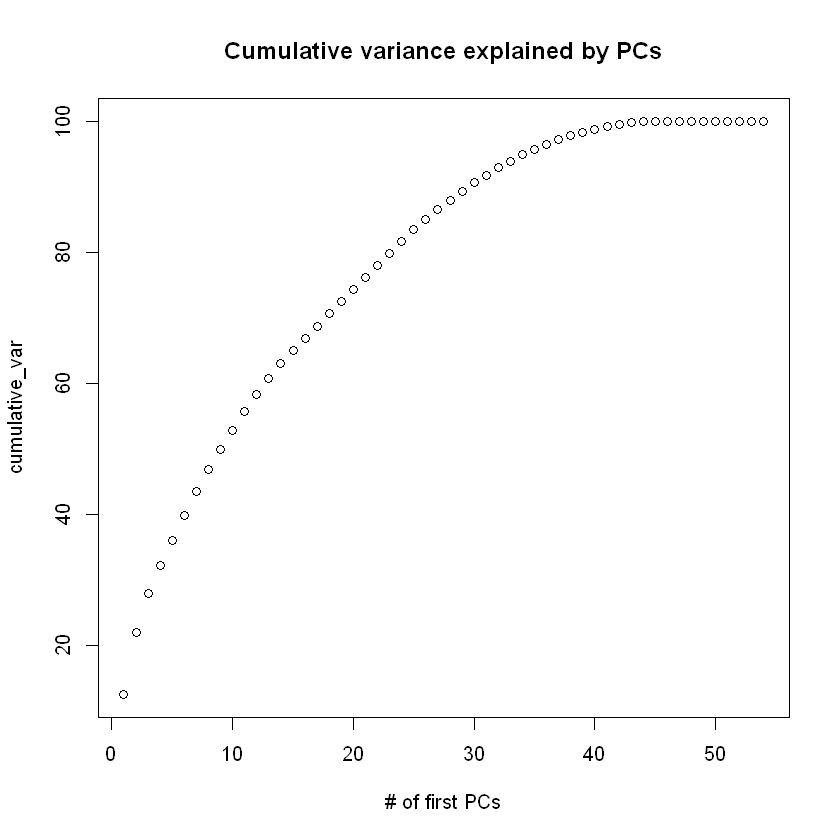

In [39]:
plot(cumulative_var,main='Cumulative variance explained by PCs',xlab ='# of first PCs')

Usually, one set a statistic treshold at ~95% or ~99% to determine the ith most relevant PC. Here we observe the cumulative variance increasing very slowy, almost linearly over certain segments. Usually (in theory) we expect PCA to rapidly increase and hit 95% or 99% after 4,5,6 PCs and stagnate right below 100% after. In our case we reach 99% after taking into account >40th first PC, and these are only linear combination !

In [35]:
length(cumulative_var[cumulative_var<99])

[1] 40

For the sake of curiosity, we can check what are the (absolute, cumulative) contribution of the features to these first 40 PCs, to see if a pattern appears and see if that determines a ranking. For that we use the dataframe with PC contribution for every feature:

In [32]:
head(contribution_PC_df)

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,⋯,Dim.45,Dim.46,Dim.47,Dim.48,Dim.49,Dim.50,Dim.51,Dim.52,Dim.53,Dim.54
count_floors_pre_eq,1.45918161,1.39290455,13.41741208,4.10409071,0.9649349,0.30229668,1.087969e-02,6.501771e-02,4.2027445331,0.37765869,⋯,3.224069e-07,1.468746e-07,2.395727e-08,1.013004e-22,3.135670e-25,2.326167e-25,1.947675e-26,6.947160e-26,1.741505e-27,4.222656e-29
age,0.82291522,0.01723636,4.79501260,0.82562066,3.1016399,0.04107975,2.376878e-03,5.501741e-01,0.0003999935,0.05744640,⋯,1.292478e-05,3.414310e-08,5.382332e-08,1.081838e-24,2.454630e-24,3.232949e-25,2.687609e-26,1.587476e-27,9.668933e-29,1.190232e-29
area_percentage,1.22086858,1.87842384,1.09603898,0.01014482,0.1907564,0.07706089,4.346267e-01,2.914436e-07,2.1751614080,0.21402852,⋯,5.238259e-07,8.036146e-08,5.822744e-08,6.348203e-27,4.521509e-25,1.838326e-27,9.367547e-26,2.642778e-26,3.916587e-26,2.505781e-28
height_percentage,0.23666140,1.86422995,13.43211925,3.00903371,0.3851056,0.57236389,3.957177e-05,1.771280e-01,4.7439122747,0.03059203,⋯,1.246722e-06,1.216244e-06,9.953179e-09,1.273341e-25,6.349584e-30,6.044369e-26,3.007909e-26,1.497055e-26,4.415889e-28,4.419187e-30
land_surface_condition_n,0.02716244,0.17635271,0.07455161,2.69277695,0.1502522,36.60717084,6.804695e-01,4.680671e+00,0.0249254272,3.11607231,⋯,4.934462e-07,9.803618e-09,1.399582e-11,6.600358e-08,6.219998e-06,3.763583e-04,2.220042e-04,4.672605e-05,8.128764e-02,4.991806e+01
land_surface_condition_t,0.02716244,0.17635271,0.07455161,2.69277695,0.1502522,36.60717084,6.804695e-01,4.680671e+00,0.0249254272,3.11607231,⋯,4.934462e-07,9.803618e-09,1.399582e-11,6.600358e-08,6.219998e-06,3.763583e-04,2.220042e-04,4.672605e-05,8.128764e-02,4.991806e+01


Let us now take the sum over the first 40 PCs and sort the result:

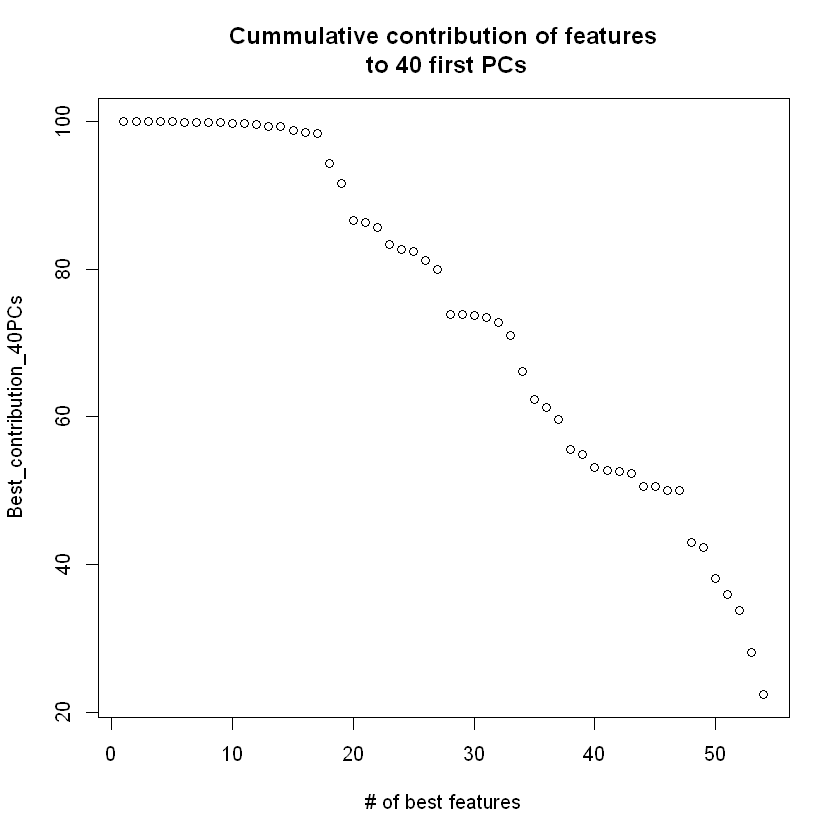

In [42]:
Best_contribution_40PCs <- sort(rowSums(contribution_PC_df[,1:40],na.rm = TRUE),decreasing = TRUE) 
plot(Best_contribution_40PCs,main='Cummulative contribution of features\n to 40 first PCs',xlab='# of best features')

This is the worst case scenario: in fact almost every feature does contributes significantly to these 40 first PCs; there is no real hope to safely select features looking at this.  This goes back to what we said in the introduction of this section: PCA is sometimes not very efficient for real-life ML problems, and it usually does **not** help the data cleaning procedure as it alters the interpretation of the columns.

#### Conclusion

At the end, we will not remove any more feature than we had before in order to train our models. Indeed, reducing the dimensionality is so important when the number of features is very high (and this is even more the case if the size of the dataset is not that large) that an estimator may perform better after than before the dimensionality reduction and taking more features than the optimal number of features can decrease the quality of the estimator. However, in our case the number of features is not very large (and is quite small compared to the number of rows) and we realized that removing any additional features was doing nothing but decreasing the prediction accuracy. 

In conclusion, apart from the features that we removed from [data overview](#Data-overview) reasoning, we chose not to remove any additional feature since removing features :
* does not allow us to improve the quality of our classifiers (in the sense that it decreases the prediction accuracy), due to the number of features not being large enough
* does not change much in the computation time of the models 


As a final remark, we will not try to generate more training sets through bootstrap, as we assume that we already have enough data for the scope of this work. Of course, some bootstrap will be implicitly used in Random Forest for instance.

[back to the contents](#Contents)

## Model selection

In this section, we will introduce 3 models for the classification task. We will train them and try to find the best hyperparameters that give us the largest prediction score (the micro F1 score in this case).

### Decision Tree

Let us begin with one of the most simple models for classification : a single decision tree. Note that to assess the quality of the splits, to decision tree is doing cross-validation by itself. Hence we will not use a lot of cross-validation verifications in this section.

**Naive tree**

We can begin by a naive decision tree, where the hyperparameters are set to default. 

In [29]:
X <- read.csv('Data/training_values_cleaned_encoded.csv',stringsAsFactors = T)
Y <- read.csv('Data/training_data_cleaned.csv', stringsAsFactors = T) %>% select(damage_grade)

In [17]:
model <- rpart(Y[,] ~ ., method="class",data=X)


Classification tree:
rpart(formula = Y[, ] ~ ., data = X, method = "class")

Variables actually used in tree construction:
[1] enc_geo_level_3_id_tar_damage_grade_X1
[2] enc_geo_level_3_id_tar_damage_grade_X3
[3] foundation_type                       

Root node error: 112342/260601 = 0.43109

n= 260601 

        CP nsplit rel error  xerror      xstd
1 0.310685      0   1.00000 1.00000 0.0022504
2 0.015582      1   0.68931 0.69073 0.0020779
3 0.011064      3   0.65815 0.65971 0.0020499
4 0.010000      4   0.64709 0.64864 0.0020394


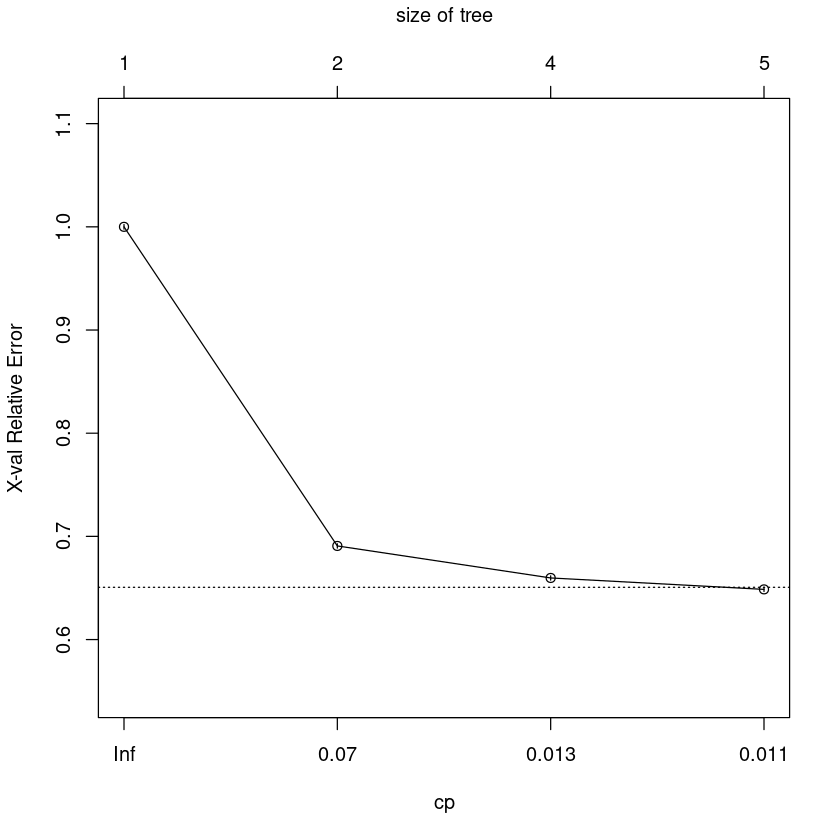

In [22]:
printcp(model)
plotcp(model)

In this case, the complexity parameter $cp$ is set by default to $cp = 0.01$, meaning that an improvement of the relative error of at least 1%  is required to perform a cut. This requirement is bit too strong for our dataset, since the growing of the tree stopped quickly, after only 4 splits. Moreover, only 3 variables have been used in the tree construction. All of this can be seen in the following plot of the tree :

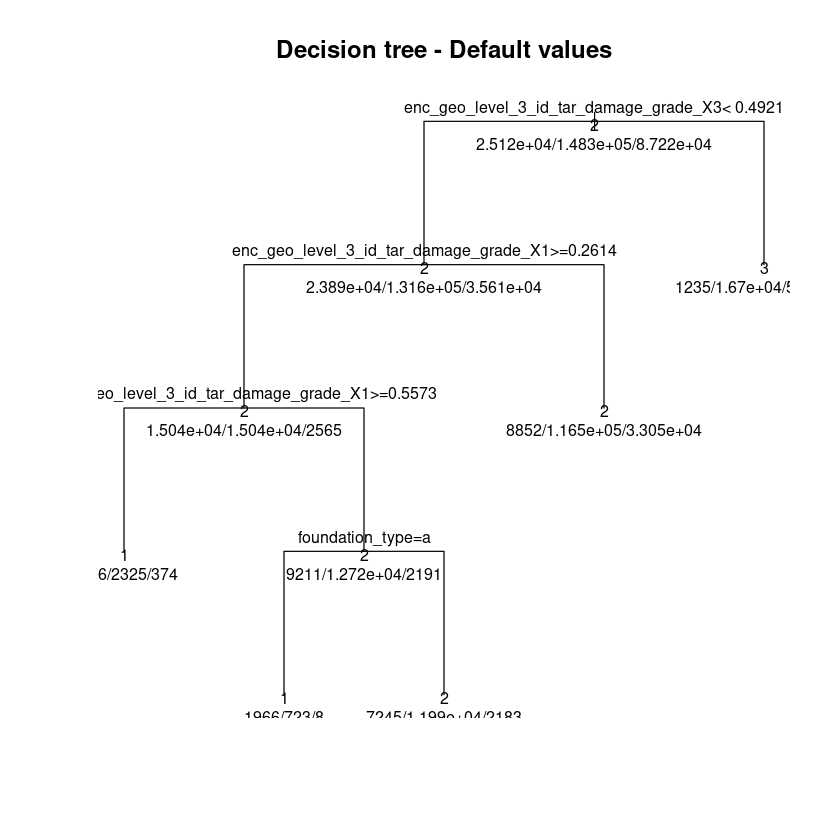

In [30]:
# plot tree of model
plot(model, uniform=TRUE, main="Decision tree - Default values")
text(model, use.n=TRUE, all=TRUE, cex=.8)

Let us however compute the training accuracy of this simple tree by comparing the predicted target with the true target.  Setting `type ='class'` in the parameters of rpart.predict is equivalent to taking the largest probability as a guess for a prediction.

In [32]:
Yhat <- predict(model,X, type='class')
F1_Score_micro(Y[,], Yhat, labels=NULL)

[1] 0.7210487

This is quite ok, but it's only the micro F1 score on the training set, not even on a validation set.

**Too deep tree**


Now let us try to do better by relaxing to stop condition of the complexity parameter, but setting a constraint on the maxium depth of the tree in order to have a stop condition.

In [4]:
model <- rpart(Y[,] ~ ., method="class",data=X, cp = 0, maxdepth=15)


Classification tree:
rpart(formula = Y[, ] ~ ., data = X, method = "class", cp = 0, 
    maxdepth = 15)

Variables actually used in tree construction:
 [1] age                                   
 [2] area_percentage                       
 [3] count_families                        
 [4] count_floors_pre_eq                   
 [5] enc_geo_level_1_id_tar_damage_grade_X1
 [6] enc_geo_level_1_id_tar_damage_grade_X2
 [7] enc_geo_level_1_id_tar_damage_grade_X3
 [8] enc_geo_level_2_id_tar_damage_grade_X1
 [9] enc_geo_level_2_id_tar_damage_grade_X2
[10] enc_geo_level_2_id_tar_damage_grade_X3
[11] enc_geo_level_3_id_tar_damage_grade_X1
[12] enc_geo_level_3_id_tar_damage_grade_X2
[13] enc_geo_level_3_id_tar_damage_grade_X3
[14] foundation_type                       
[15] ground_floor_type                     
[16] has_secondary_use                     
[17] has_secondary_use_agriculture         
[18] has_secondary_use_hotel               
[19] has_superstructure_adobe_mud          
[20] has_sup

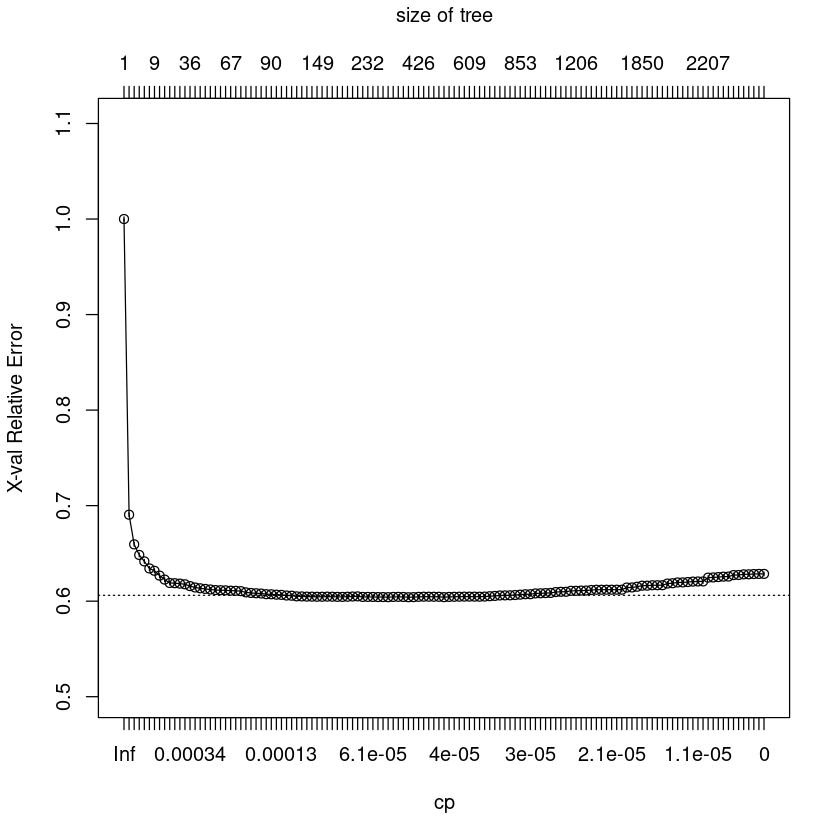

In [5]:
printcp(model)
plotcp(model)

Of course the final tree is too deep (we won't plot it since nothing would be visible) and is overfitting. It performs well on the dataset on which it has been trained :

In [7]:
Yhat <- predict(model,X, type='class')
F1_Score_micro(Y[,], Yhat, labels=NULL)

[1] 0.7753385

But with a $5$-fold cross-validation : 

In [8]:
#Running time ~ 10min

set.seed(42)
k = 5
scores_vec <- array(0,k)
complexity <- 0

# Splitting into k folds
rand_ind <- sample(1:nrow(X))
max <- ceiling(nrow(X)/k)
splits <- split(rand_ind, ceiling(seq_along(rand_ind)/max))


for (i in 1:k){
    # Validation set
    validation_target <- Y[splits[[i]],]
    validation_features <- X[splits[[i]],]
    
    # Training set
    train_target <- Y[-splits[[i]],]
    train_features <- X[-splits[[i]],]
    
    # Model training and prediction on the validation set
    model <- rpart(train_target ~ ., method="class",data=train_features, cp = complexity, maxdepth = 15)
    validation_pred <- predict(model,validation_features, type='class')
    
    # Computing the micro F1 score
    scores_vec[i] = F1_Score_micro(validation_target, validation_pred, labels=NULL)
    print(paste("[INFO] - F1 score -",i,"fold:",scores_vec[i]))
}

print(paste("[INFO] - Mean F1 score :", mean(scores_vec)))


[1] "[INFO] - F1 score - 1 fold: 0.727921567122657"
[1] "[INFO] - F1 score - 2 fold: 0.725158765181021"
[1] "[INFO] - F1 score - 3 fold: 0.727787264250494"
[1] "[INFO] - F1 score - 4 fold: 0.725312254177779"
[1] "[INFO] - F1 score - 5 fold: 0.726404052420515"
[1] "[INFO] - Mean F1 score : 0.726516780630493"


One sees that the prediction score is lower. It is however larger than the training accuracy that we had from the naive decision tree with $cp=0.01$. It is now time the tune $cp$ parameter, somewhere between $0$ and $0.001$.

**Optimal tree**

To find the best value for the complexity parameter, we choose in the cptable the largest $cp$ such that its associated $x_{error}$ is in  $[x_{error}^{min} - x_{std}, x_{error}^{min} + x_{std}]$. We find 1.2017e-04 for this $cp$. Now we can prune the tree to this value.

In [9]:
model2 <- prune(model, cp = 1.2017e-04)


Classification tree:
rpart(formula = train_target ~ ., data = train_features, method = "class", 
    cp = complexity, maxdepth = 15)

Variables actually used in tree construction:
 [1] age                                   
 [2] area_percentage                       
 [3] count_families                        
 [4] count_floors_pre_eq                   
 [5] enc_geo_level_1_id_tar_damage_grade_X1
 [6] enc_geo_level_1_id_tar_damage_grade_X2
 [7] enc_geo_level_1_id_tar_damage_grade_X3
 [8] enc_geo_level_2_id_tar_damage_grade_X1
 [9] enc_geo_level_2_id_tar_damage_grade_X2
[10] enc_geo_level_2_id_tar_damage_grade_X3
[11] enc_geo_level_3_id_tar_damage_grade_X1
[12] enc_geo_level_3_id_tar_damage_grade_X2
[13] enc_geo_level_3_id_tar_damage_grade_X3
[14] foundation_type                       
[15] ground_floor_type                     
[16] has_secondary_use                     
[17] has_secondary_use_agriculture         
[18] has_superstructure_cement_mortar_brick
[19] has_superstructure_mud

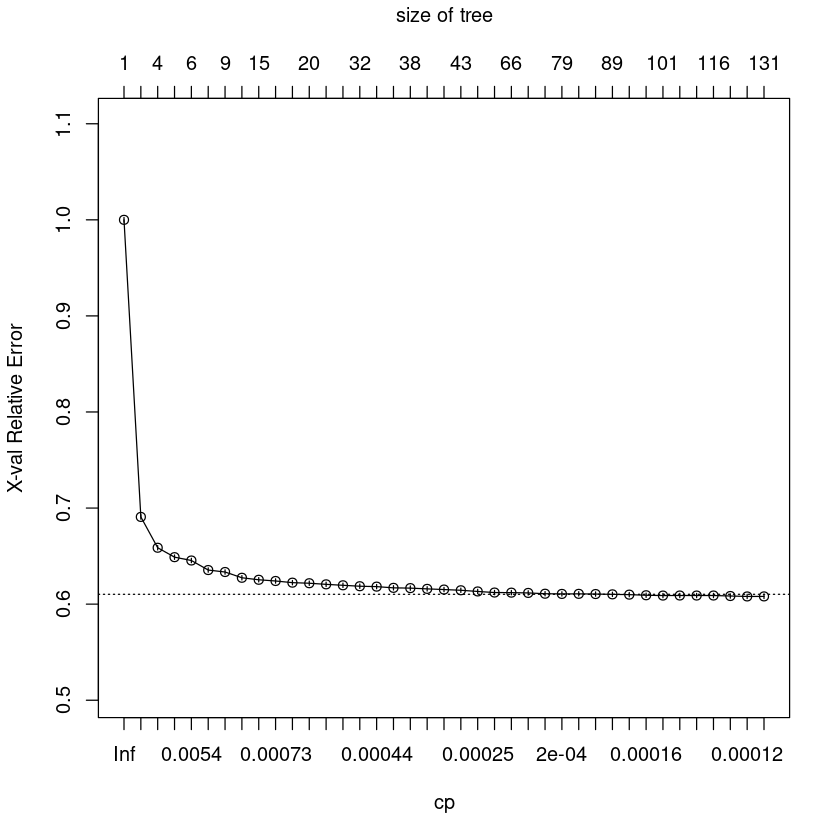

In [13]:
plotcp(model2)
printcp(model2)

This looks more promising ! Let us train again from scratch a decision tree with this value for $cp$ (since pruning a deep tree and growing a tree, both with the same $cp$ parameter, don't result in exactly the same tree), and compute its training accuracy and its accuracy through a $5$-fold cross-validation:

In [16]:
model <- rpart(Y[,] ~ ., method="class",data=X, cp = 1.2017e-04) #we can relax the maxdepth constraint now

In [20]:
Yhat <- predict(model,X, type='class')
F1_Score_micro(Y[,], Yhat, labels=NULL)

[1] 0.7423494

In [21]:
#Running time ~ 10min

set.seed(42)
k = 5
scores_vec <- array(0,k)
complexity <- 0

# Splitting into k folds
rand_ind <- sample(1:nrow(X))
max <- ceiling(nrow(X)/k)
splits <- split(rand_ind, ceiling(seq_along(rand_ind)/max))


for (i in 1:k){
    # Validation set
    validation_target <- Y[splits[[i]],]
    validation_features <- X[splits[[i]],]
    
    # Training set
    train_target <- Y[-splits[[i]],]
    train_features <- X[-splits[[i]],]
    
    # Model training and prediction on the validation set
    model <- rpart(train_target ~ ., method="class",data=train_features, cp = 1.2017e-04)
    validation_pred <- predict(model,validation_features, type='class')
    
    # Computing the micro F1 score
    scores_vec[i] = F1_Score_micro(validation_target, validation_pred, labels=NULL)
    print(paste("[INFO] - F1 score -",i,"fold:",scores_vec[i]))
}

print(paste("[INFO] - Mean F1 score :", mean(scores_vec)))


[1] "[INFO] - F1 score - 1 fold: 0.739107077761363"
[1] "[INFO] - F1 score - 2 fold: 0.737169279177299"
[1] "[INFO] - F1 score - 3 fold: 0.739989639492719"
[1] "[INFO] - F1 score - 4 fold: 0.739375683505689"
[1] "[INFO] - F1 score - 5 fold: 0.736247289751904"
[1] "[INFO] - Mean F1 score : 0.738377793937795"


As we can see, this is the best cross-validation F1 score that we've got so far. The model is still a bit overfitting, but we find this quite reasonable. Hence we choose $cp = 0.00012017$ as our optimal hyperparameter value for this decision tree subsection. Note that this accuracy for a single decision tree is promising as we plan to intensely use tree-based models later on in this work.

**Variable importance**

The decision tree can rank the features in terms of their importance and how much it depends on them. Again, one sees that the geographical zones are very relevant for the prediction, as expected. 



In [25]:
data.frame(model$variable.importance)

,model.variable.importance
,<dbl>
enc_geo_level_3_id_tar_damage_grade_X3,2.664061e+04
enc_geo_level_3_id_tar_damage_grade_X2,2.099490e+04
enc_geo_level_2_id_tar_damage_grade_X3,1.639798e+04
enc_geo_level_2_id_tar_damage_grade_X2,1.337958e+04
enc_geo_level_1_id_tar_damage_grade_X3,9.838943e+03
enc_geo_level_1_id_tar_damage_grade_X2,9.137863e+03
enc_geo_level_3_id_tar_damage_grade_X1,7.096353e+03
enc_geo_level_2_id_tar_damage_grade_X1,2.959804e+03
foundation_type,1.896773e+03


One could also run a decision tree on the entire raw dataset and justify why we were confident to remove some variables.
It is however important to note that to take this variable hierarchy as granted is not a good idea, since it comes from a single classifier. That's the reason why we have put more trust in the ranking of [Random Forest](#Random-Forest).

**Remark**

One can have an idea of how important was the data preprocessing by comparing what we just had with the performance of a decision tree of the same type, but trained on the raw dataset.

In [9]:
X <- read.csv('Data/train_values.csv',stringsAsFactors = T) %>% select(-building_id)
Y <- read.csv('Data/train_labels.csv', stringsAsFactors = T) %>% select(-building_id)

In [14]:
model <- rpart(Y[,] ~ ., method="class",data=X, cp = 1.2017e-04)
Yhat <- predict(model,X, type='class')
F1_Score_micro(Y[,], Yhat, labels=NULL)

[1] 0.7169619

As we notice, the preprocessing allows us to gain nearly 3% of training accuracy, which is not negligeable! Also, it saves us processing time, which will make our life easier later on.

### Random Forest

Now we use the Random Forest algorithm, which is an ensembling of non-pruned decision trees that are generated from random selections of the input varibles. In this way, it combines estimators that have low bias (since they are non-pruned decision trees) and that are independent (since they are grown via random selection of variables and random selection of observations), so that the resulting model will have a small variance, as we know from model ensembling. It is based on trees so it can handle categorical input variables, hence there is still no need to encode the categorical features apart from the `geo_level` ones.

In addition to the hyperparameters of the single decision trees, the two main other ones are the number of trees to grow, $ntree$, and $mtry$, which is the size of the random feature subset. In other words, $mtry$ is the maximum number of variables that are randomly sampled as candidates at each split. 
* Typically, $ntree$ should not be too small, to ensure that every input row gets predicted at least a few times. $ntree=30$ is a good place to start and we can increase it as much as we want, since adding more trees does not increase generalization error as we know from ensembling. However the Random Forest model on itself can overfit, but this is more related to choices that are made on the single trees hyperparameters; for instance if one prunes them. That's the reason why the only hyperparameters that we will try to tune here are $ntree$ and $mtry$. In this way, we are not preventing any of the single decision trees from growing as long as it can (for instance, one could fix $maxnodes$ to limit the maximum number of terminal nodes trees but this would lead to overfitting). Note however that the predicting accuracy as a fonction of $ntree$ will reach a plateau, in the sense that at a given point adding hundreds of trees will improve the classifier in a very small way. As usual, it is then a tradeoff between the accuracy and logistic parameters (such as time and computational power). 
* $mtry$ can take value anywhere in the range $[1, N_{f}]$, where $N_f$ is the number of input features. However we will limit ourselves to the three commonly used values : 
    1. $mtry = \log_2(N_f)$
    2. $mtry = \sqrt{N_f}$
    3. $mtry = \frac{N_f}{3}$
    
We will explore the combinations of these two hyperparameters via a $5$-fold cross-validation on the training set.


_Remark : I had a lot kernel crashing issues because of Random Forest clogging my RAM as soon as the number of trees was above $\sim 180$. Hence I used Google Colab to have 12 GB of RAM available. This is the reason why the outputs displayed in this section are not the genuine outputs of the cells. They are copied-pasted or saved from my Google Colab notebook but I'll make this notebook available in the Github repository. Note also that 350 trees was the upper bound, as it completely filled the RAM of the Google Colab session. We reached the maximum of our Random Forest analysis due to technical limitations._

In [30]:
X <- read.csv('Data/training_values_cleaned_encoded.csv',stringsAsFactors = T)
Y <- read.csv('Data/training_data_cleaned.csv', stringsAsFactors = T) %>% select(damage_grade)

**Searching for the best $mtry$**

One has 32 columns of features, hence our three selected values are $mtry \in \{ \log_2 (32) = 5,\sqrt{32} = 5.657 , \frac{32}{3} = 10.667 \}$ and we will test them for a fixed number of trees. To make sure that we are not missing something, we will take a small number of trees (30) and then a more relevant number (100). We will notice that the largest value of $mtry$ is the best in both cases. We want to ensure the fact that this will remain true for a largest number of trees (since we will increase $ntree$ up to 300), so we will try to confirm this behaviour for a large -but reasonable- number of trees (180).

In [ ]:
#For 30 trees
#Running time ~ 10min

set.seed(42)
k = 5
m_tries = c(log2(ncol(X)), sqrt(ncol(X)) ,ncol(X)/3)
scores_vec <- array(0,k)
mtries_scores_vec <- array(0,length(m_tries))

#Splitting as a k-folding
rand_ind <- sample(1:nrow(X))
max <- ceiling(nrow(X)/k)
splits <- split(rand_ind, ceiling(seq_along(rand_ind)/max))

j <- 1
for (m_try in m_tries){
    
    for (i in 1:k){
        #Take the group as a hold out or test data set
        validation_target <- Y[splits[[i]],]
        validation_features <- X[splits[[i]],]
    
        #Take the remaining groups as a training data set
        train_target <- Y[-splits[[i]],]
        train_features <- X[-splits[[i]],]
    
        #Fit a model on the training set 
        model <- randomForest(x=train_features,
                          y=as.factor(train_target),
                          ntree=30, mtry = m_try)
        #Prediction on the validation set
        validation_pred <- predict(model,validation_features)
    
        #Computation of the micro F1 score
        scores_vec[i] = F1_Score_micro(validation_target, validation_pred, labels=NULL)
    }

    mtries_scores_vec[j] <- mean(scores_vec)
    j <- j +1
    
    print(paste("[INFO] - CV F1 score for  ",m_try,"mtry: ", mean(scores_vec)))
}

plot(m_tries,mtries_scores_vec,main = paste("Cross-validation with", k ,"folds, 30 trees"),xlab = "mtry",ylab = "CV F1 score")

[1] "[INFO] - CV F1 score for   5 mtry:  0.756739261811425"

[1] "[INFO] - CV F1 score for   5.65685424949238 mtry:  0.75771776476806"

[1] "[INFO] - CV F1 score for   10.6666666666667 mtry:  0.757476003400199"

![RF_CV_mtry_30t.png](Pictures/RF_CV_mtry_30t.png)

In [ ]:
#For 100 trees
#Running time ~ 45min

set.seed(42)
k = 5
m_tries = c(log2(ncol(X)), sqrt(ncol(X)) ,ncol(X)/3)
scores_vec <- array(0,k)
mtries_scores_vec <- array(0,length(m_tries))

#Splitting as a k-folding
rand_ind <- sample(1:nrow(X))
max <- ceiling(nrow(X)/k)
splits <- split(rand_ind, ceiling(seq_along(rand_ind)/max))

j <- 1
for (m_try in m_tries){
    
    for (i in 1:k){
        #Take the group as a hold out or test data set
        validation_target <- Y[splits[[i]],]
        validation_features <- X[splits[[i]],]
    
        #Take the remaining groups as a training data set
        train_target <- Y[-splits[[i]],]
        train_features <- X[-splits[[i]],]
    
        #Fit a model on the training set 
        model <- randomForest(x=train_features,
                          y=as.factor(train_target),
                          ntree=100, mtry = m_try)
        #Prediction on the validation set
        validation_pred <- predict(model,validation_features)
    
        #Computation of the micro F1 score
        scores_vec[i] = F1_Score_micro(validation_target, validation_pred, labels=NULL)
    }

    mtries_scores_vec[j] <- mean(scores_vec)
    j <- j +1
    
    print(paste("[INFO] - CV F1 score for  ",m_try,"mtry: ", mean(scores_vec)))
}

plot(m_tries,mtries_scores_vec,main = paste("Cross-validation with", k ,"folds, 100 trees"),xlab = "mtry",ylab = "CV F1 score")

[1] "[INFO] - CV F1 score for   5 mtry:  0.76264097911764"


[1] "[INFO] - CV F1 score for   5.65685424949238 mtry:  0.762702382373564"


[1] "[INFO] - CV F1 score for   10.6666666666667 mtry:  0.763477517710649"


![RF_CV_mtry_100t.png](Pictures/RF_CV_mtry_100t.png)

In [ ]:
#For 180 trees
#Running time ~ 1h15

set.seed(42)
k = 5
m_tries = c(log2(ncol(X)), sqrt(ncol(X)) ,ncol(X)/3)
scores_vec <- array(0,k)
mtries_scores_vec <- array(0,length(m_tries))

#Splitting as a k-folding
rand_ind <- sample(1:nrow(X))
max <- ceiling(nrow(X)/k)
splits <- split(rand_ind, ceiling(seq_along(rand_ind)/max))

j <- 1
for (m_try in m_tries){
    
    for (i in 1:k){
        #Take the group as a hold out or test data set
        validation_target <- Y[splits[[i]],]
        validation_features <- X[splits[[i]],]
    
        #Take the remaining groups as a training data set
        train_target <- Y[-splits[[i]],]
        train_features <- X[-splits[[i]],]
    
        #Fit a model on the training set 
        model <- randomForest(x=train_features,
                          y=as.factor(train_target),
                          ntree=180, mtry = m_try)
        #Prediction on the validation set
        validation_pred <- predict(model,validation_features)
    
        #Computation of the micro F1 score
        scores_vec[i] = F1_Score_micro(validation_target, validation_pred, labels=NULL)
    }

    mtries_scores_vec[j] <- mean(scores_vec)
    j <- j +1
    
    print(paste("[INFO] - CV F1 score for  ",m_try,"mtry: ", mean(scores_vec)))
}

plot(m_tries,mtries_scores_vec,main = paste("Cross-validation with", k ,"folds, 180 trees"),xlab = "mtry",ylab = "CV F1 score")

[1] "[INFO] - CV F1 score for   5 mtry:  0.763788322915794"

[1] "[INFO] - CV F1 score for   5.65685424949238 mtry:  0.764126005187848"


[1] "[INFO] - CV F1 score for   10.6666666666667 mtry:  0.764314041283724"


![RF_CV_mtry_180t.png](Pictures/RF_CV_mtry_180t.png)

This confirms that the best $mtry$ to keep among our options is $mtry = \frac{N_f}{3}$. We assume that it will remain associated to a high prediction accuracy, even for more trees. Of course, to find the optimal configuration, one should fine tune the parameter and not restrict ourselves to these three values. For instance, $mtry=12$ could do better than we have here. However we find this quite satisfactory, since we don't aim at finding the perfectly tuned hyperparameters.

Note that the the behaviour of the prediction score for a small number of trees such as $30$ is more particular. Indeed, some observations can be predicted only once or even not at all and, in this case it might be more efficient for them to pick features in a smaller subset.

**Searching for the best $ntree$**


As explained before, we expect that adding more trees can only improve the prediction score. Let us see this in a $5$-fold cross-validation, where the Random Forest models are trained with $mtry = \frac{N_f}{3}$ and the number of trees such that $ntree = 30,50,100,200$.

In [ ]:
#With mtry = Nf/3
#Running time ~ 4h

set.seed(42)
k = 5
n_trees = c(30,50,100,200)
scores_vec <- array(0,k)
ntrees_scores_vec <- array(0,length(n_trees))

#Splitting as a k-folding
rand_ind <- sample(1:nrow(X))
max <- ceiling(nrow(X)/k)
splits <- split(rand_ind, ceiling(seq_along(rand_ind)/max))

j <- 1
for (n_tree in n_trees){
    
    for (i in 1:k){
        #Take the group as a validation data set
        validation_target <- Y[splits[[i]],]
        validation_features <- X[splits[[i]],]
    
        #Take the remaining groups as a training data set
        train_target <- Y[-splits[[i]],]
        train_features <- X[-splits[[i]],]
    
        #Fit a model on the training set 
        model <- randomForest(x=train_features,
                          y=as.factor(train_target), importance = TRUE,
                          ntree=n_tree, mtry = ncol(X)/3)
        
        #Prediction on the validation set
        validation_pred <- predict(model,validation_features)
    
        #Computation of the micro F1 score 
        scores_vec[i] = F1_Score_micro(validation_target, validation_pred, labels=NULL)
    }

    ntrees_scores_vec[j] <- mean(scores_vec)
    j <- j +1
    
    print(paste("[INFO] - CV F1 score for  ",n_tree,"trees: ", mean(scores_vec)))
}


plot(n_trees, ntrees_scores_vec,main = paste("Cross-validation with ", k ,"folds, mtry = N_f/3"),xlab = "Number of trees",ylab = "CV F1 score")

[1] "[INFO] - CV F1 score for   30 trees:  0.757257287764498"

[1] "[INFO] - CV F1 score for   50 trees:  0.760388493043711"

[1] "[INFO] - CV F1 score for   100 trees:  0.763097615656689"

[1] "[INFO] - CV F1 score for   200 trees:  0.765073840679507"

![RF_CV_mtry_180t.png](Pictures/RF_CV_ntree.png)

As expected, the more we add trees, the better is the prediction score. We also notice that it will slowly reach a sort of plateau. Indeed the improvement of the prediction score between $100$ and $200$ trees is quite small, compared to the time it takes to go from the former to the latter case. However, in order to get the best precision score on the test set, we will of course take $ntree$ as large as we can. Due to RAM limitation of Google Colab, this maximum is given by $ntree = 340$.

**Training and prediction of the best Random Forest**

Now we can train our Random Forest model on the full training set and then use it to predict the targets of the test set.

In [ ]:
#Training the model on the full training set
#Running time ~ 1h

model <- randomForest(x=X[,],
                          y=as.factor(Y[,]),
                          ntree=340, mtry=ncol(X)/3)

#Predicting the damage grades of the test set
pred <-predict(model, X_test)

The last step consists of putting the prediction in the submission format, namely adding the `building_id` column to the predicted values.

In [ ]:
test_values <- read.csv('Data/test_values.csv', stringsAsFactor = T)
final <- test_values[,] %>% select(building_id)
final <- cbind(final,pred)
colnames(final)[2] <-"damage_grade"

In [ ]:
#Save the dataframe as a .csv file
#write.csv(final, "Data/pred_340t_cleaned.csv", row.names=FALSE)

This prediction gives us a micro F1 score of $$ \textrm{Random Forest micro F1 score :  } 0.7465$$

on DrivenData.

**Variable importance**

Random Forest can give us a hierarchy of variable importance that we use in [data overview](#Data-overview). One can observe two different measures : the mean decrease accuracy (that tells how much accuracy the model losses by excluding the corresponding variable) and the mean decrease Gini (where the Gini coefficient reflects the homogeneity of the nodes and leaves in the random forest). For a given feature, the higher these measures are, the more important to the model it is. One can access to both of them by writing `importance = TRUE` in the input parameters of the randomForest function.

Here is for instance, the mean descrease in Gini coefficient for our optimal Random Forest with $340$ trees :


In [ ]:
varImpPlot(model)

![Gini Decrease 340t](Pictures/RF_340t_Ginidecr.png)

In order to be more precise, one can display the table of both the mean decrease in Gini coefficient and in accuracy. Let us see this for a model of $ntree = 300$ trained on the raw dataset (i.e. not cleaned nor encoded):

In [ ]:
X <- read.csv('Data/train_values.csv', stringsAsFactors = T) %>% select(-building_id)
Y <- read.csv('Data/train_labels.csv', stringsAsFactors = T) %>% select(-building_id)

In [ ]:
# Running time ~ 1h

model <- randomForest(x=X,
                          y=as.factor(Y), importance = TRUE,
                          ntree=300, mtry=ncol(X)/3)

In [5]:
#If needed
imp300 <- read.csv("Data/RAF_imp_300t.csv", stringsAsFactors = T)

In [4]:
imp300
#or :
#imp300 <- data.frame(model$importance) %>% select(MeanDecreaseAccuracy, MeanDecreaseGini ) 
#imp300 <- imp300[order(imp300$MeanDecreaseAccuracy, decreasing=TRUE),]

X,MeanDecreaseAccuracy,MeanDecreaseGini
<fct>,<dbl>,<dbl>
geo_level_1_id,1.450045e-01,18064.804583
geo_level_2_id,6.849428e-02,15618.358861
geo_level_3_id,3.449816e-02,17338.280082
height_percentage,2.877258e-02,6513.351651
has_superstructure_mud_mortar_stone,2.796764e-02,1876.362985
other_floor_type,2.456469e-02,2438.603187
count_floors_pre_eq,2.407844e-02,2126.698290
foundation_type,2.311591e-02,3919.653241
area_percentage,2.033151e-02,12356.952649


This table is sorted by MeanDecreaseAccuracy but one sees that the MeanDecreaseGini follows the same global trends.

In [data overview](#Data-overview), we used this ranking to be sure that we could remove some less relevant features from the dataset. More precisely, every time that our anylises suggested us that a feature could be removed, we checked its ranking in this Random Forest variable importance.

### Neural network

The use of a Neural Network has been motivated by its study during the pratical session, and also by the fact that it is knonw (at least for deep neural network) as an very efficient tool for image classification. However, we have no idea on how this will perfom for classifaction problem with low cardinality; we are interested to see if we can provide a relatively good accuracy and F1_score with a *simple* neural network. We do not aim to find the most advanced and suitable neural network for this problem: first, because we are more confortable with Random Forest algorithm, and it has already gave us relatively good results/accuracy. Second, because the numbers of hyperparameters to tune, together with the stucture of neural network, represent a heavy computational challenge, especially with Cross-Validation.

**One-Hot encoding**

Remember that we discussed about the great interest we had with target encoding for geo_level_id features; we left other categorical features aside, as they have low cardinality with different values. We will opt here for simplicity, using one-hot encoding for two reasons. First of all, RF tells us that they have low importance than geo_level_id features hence we should not prioritize them in the implementation of an advanced and complex encoding. Second of all, we manage in section [Data Overview](#Data-overview) to reduce the number of different values that were sub-represented in some categorical features, and to suppress some who were not bringing much insights. All together, this makes reasonable the use of one-hot encoding, as we keep under control the number of feature dimension.

In [31]:
dataset <- read.csv('Data/training_values_cleaned_encoded.csv',header = TRUE,sep = ',')
train_labels <- read.csv('Data/train_labels.csv',header = TRUE,sep = ',')
dataset <- as.data.frame(cbind(dataset,train_labels)) %>% select(-c(building_id))

In [36]:
categorical_features_one_hot <- c('land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration')

for (feature in categorical_features_one_hot){
    dataset[,feature]  <- as.factor(dataset[,feature] )         #Change the type of column to factor
}

dataset <- as.data.frame(one_hot(as.data.table(dataset)))    #One hot encoding of all factor columns

**Validation set**

In [37]:
set.seed(1)

split <- initial_split(dataset, 0.8)
train_dataset <- training(split)
test_dataset <- testing(split)

X_train <- train_dataset %>% select(-damage_grade)
X_test <- test_dataset %>% select(-damage_grade)
Y_train <- train_dataset %>% select(damage_grade) %>% to_categorical()
Y_train <- Y_train[,-1]
Y_test <- test_dataset %>% select(damage_grade)  %>% to_categorical()
Y_test <- Y_test[,-1]

**Neural Network Model**

In [38]:
set.seed(43)
n_feature <- ncol(X_train)

normalizer <- layer_normalization(axis = -1L)     #Normalization layer
normalizer %>% adapt(as.matrix(X_train))

model <- keras_model_sequential() %>%
  normalizer() %>%
  layer_dense(units = 4, activation = "relu", input_shape = c(n_feature))   #We start with the first layer

for (i in range(1:20)){
  model %>% layer_dense(units = 4, activation = "relu")     #We add 20 other layers to the model, with 4 units
}

model %>% layer_dense(units = 3, activation = "softmax")    #We finish with the last layer

model %>% compile(
  optimizer = optimizer_adam(learning_rate = 0.001),    
  loss = 'categorical_crossentropy',
  metrics= ('categorical_accuracy')       
)


_On the choice of hyperparameters:_

- We choosed to work with `relu` for the starting and intermediate layers: according to documentation `relu` constitues an overall good choice of activation function for many NN structure
- We choosed 4 units, as we want to keep it simple, and try many layers 
- The last activation function `softmax` transform the output of the previous layers into a (3D) vector of probabilities, each corresponding to 1 realisation of `damage_grade`
- We took optimizer_adam, as in the pratical session. For learning rate, a good value is usually between 0.1 and 0.0001, we meet both (almost) halfway an take  0.001
- The loss function `categorical_crossentropy` is apparently a good loss function for classification problem. We encoutered some example of this loss function on iris classification problem; since we also have a three values output this loss function might suit well
- We weren't able to implement the F1_score in the compilation. We took `categorical_accuracy` as it is a good metrics for multi class classification problem according to documentation

Training the model :

In [39]:
set.seed(43)

history <- model %>% fit(
  x= as.matrix(X_train), y=Y_train,
  epochs = 10,
  verbose = 0,
  validation_data= list(as.matrix(X_test), Y_test),
  batch_size = 32
)

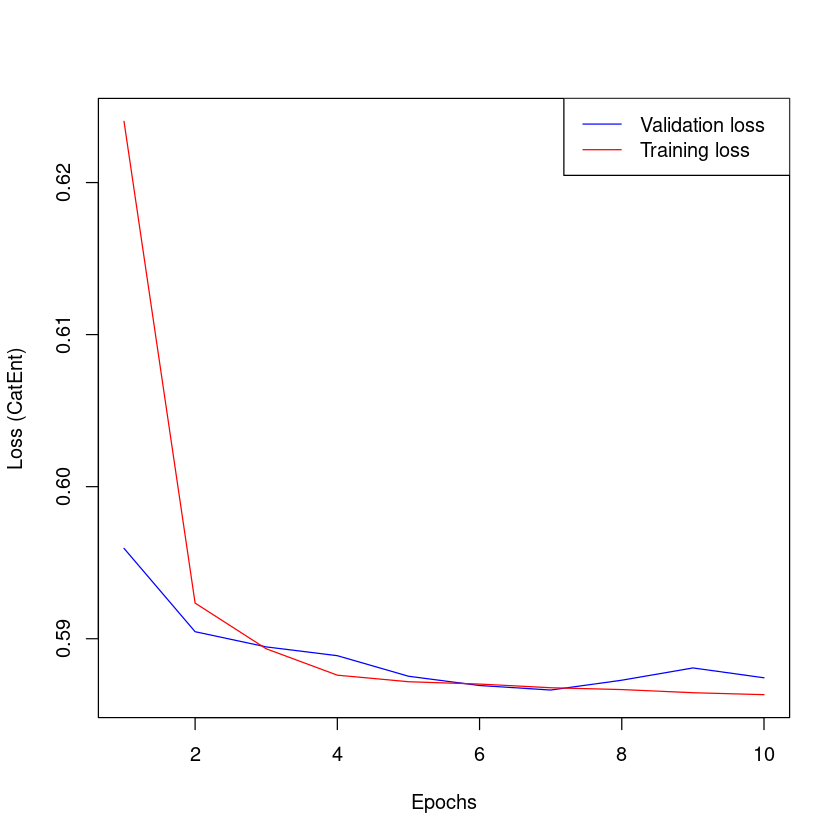

In [40]:
matplot(x = 1:history$params$epochs,
        y = cbind(history$metrics$val_loss, history$metrics$loss),
        type = "l",
        xlab = "Epochs",
        ylab = "Loss (CatEnt)",
        col = c("blue", "red"),
        lty = 1)
legend("topright",
       legend = c("Validation loss", "Training loss"),
       col = c("blue", "red"),
       lty = 1)

Testing and accuracy:

In [41]:
prediction <- model %>% predict(as.matrix(X_test)) 
y_true <- max.col(X_test)
y_hat <- max.col(prediction)

F1_Score_micro(y_true, y_hat)

[1] 0.5502772

The F1 score is really not good. It is not clear for us where to start in order to improve the Neural Network, as it is a less intuitive model for us. There are plenty of options: increase the number of layers, modify the number of units per layer, change the number of epochs, the batch size, the activation function, the loss function, the learning rate, the optimizer, etc... Since we don't have unlimited time and ressources to build this model, we decided to only vary the number of layers, keeping other parameters unchanged.   

**Hypertuning the number of layers**

In [5]:
number_layers <- seq(10,200,30)
number_layers
length(number_layers)

[1]  10  40  70 100 130 160 190

[1] 7

In [9]:
set.seed(43)

pb <- txtProgressBar(min = 0, max = 21, style = 3, label = "Progress:")  #progress bar
progress <- 0   #setting up progress

n <- ncol(dataset)
N <- nrow(dataset)
CV_folds <- 3     
size_CV <-floor(N/CV_folds)

#Create a matrix to encode the F1_score obtained for each number of layers
CV_score_NN<-matrix(0,nrow=length(number_layers),ncol=CV_folds+2)
colnames(CV_score_NN) <- c('number of layer','F1_score_CV1','F1_score_CV2','F1_score_CV3','F1_score_mean')
row <- 0  #row of the CV_score_NN matrix

normalizer <- layer_normalization(axis = -1L)

for (nb in number_layers){       #We start with the loop on nb_layer 
    row <- row + 1
    CV_score_NN[row,1] <- nb        #Assign the first columns to the nb we are tuning

    for (i in 1:CV_folds){          #Cross-Validation Loop

        set.seed(43)                   #We put a seed at each loop to ensure you have the very same result
        progress <- progress + 1                #Progress bar

        idx_ts<-(((i-1)*size_CV+1):(i*size_CV)) 
        idx_tr<-setdiff(1:N,idx_ts)

        #Validation set
        X_train <- dataset[idx_ts,] %>% select(-damage_grade)
        X_test <- dataset[idx_tr,] %>% select(-damage_grade)
        Y_train <- dataset[idx_ts,] %>% select(damage_grade) %>% to_categorical()
        Y_train <- Y_train[,-1]
        Y_test <- dataset[idx_tr,] %>% select(damage_grade)  %>% to_categorical()
        Y_test <- Y_test[,-1]


        #Model
        normalizer %>% adapt(as.matrix(X_train))
        model <- keras_model_sequential() %>%
            normalizer() %>%
            layer_dense(units = 4, activation = "relu", input_shape = c(n-1)) 

        for (j in range(1:nb)){
            model %>% layer_dense(units = 4, activation = "relu")      #We add nb layers to our model
        }

        model %>% layer_dense(units = 3, activation = "softmax")

        model %>% compile(
            optimizer = optimizer_adam(learning_rate = 0.001),    
            loss = 'categorical_crossentropy',
            metrics= ('categorical_accuracy')       
            )

        #Train

        history <- model %>% fit(
            x= as.matrix(X_train), y=Y_train,
            epochs = 10,
            verbose = 0,
            validation_data= list(as.matrix(X_test), Y_test),
            batch_size = 32
            )
            
        #Predict
         
        prediction <- model %>% predict(as.matrix(X_test)) 
        y_true <- max.col(X_test)
        y_hat <- max.col(prediction)

        #CV_fold i
        CV_score_NN[row,i+1] <-F1_Score_micro(y_true, y_hat)     #Store F1_score in our matrix
        #store it into CV_score_NN matrix
        setTxtProgressBar(pb, progress)
    }
}


# Close the progress bar
close(pb)

CV_score_NN[,5] <- rowMeans(CV_score_NN[,2:4])  #Assign last colums of CV_score_NN to average of F1_score over CV fold
CV_score_NN

  |======================================================================| 100%


number of layer,F1_score_CV1,F1_score_CV2,F1_score_CV3,F1_score_mean
10,0.5322044,0.5585147,0.5460301,0.5455831
40,0.5558670,0.5483037,0.5527876,0.5523194
70,0.5347946,0.5326591,0.5589061,0.5421199
100,0.5394338,0.5480965,0.5309496,0.5394933
130,0.5484764,0.5522638,0.5337182,0.5448195
160,0.5505831,0.5403203,0.5525056,0.5478030
190,0.5417132,0.5414599,0.5551763,0.5461165


The results are very low, this is not really satisfactory.

**Conclusion**

This is not really encouraging. Our NN seems to be stucked at 0.54, probably because of its structure and because of all the hyperparamters we put aside. Again, we have little intuition for this model, and we don't want to loose too much time in finding all the best hyperparameters (in addition to the fact that there are many of them). Since RF has already given us a very satisfying accuracy, we decided to moove on to the next step, and take on a new, very promising learning model: XGBoost.

[back to the contents](#Contents)

***

## Other model : XGBoost

Xgboost stands for Extreme Gradient Boosting, and is a gradient-boosted decision tree that combine, as its name suggests, decision trees, ensemble learning, and gradient boosting. It is to some extent an analogy to Random Forest, altough the ensemble learning process of adding new weak models (decision trees) is formalized as the minization of an objective function, using gradient descent algorithm techniques. 
Contrarely to Random Forest that minimize variance and overfitting, Gradien Boosting Trees minimize the bias and underfitting.

The choice for this model was first due to its reputation: in the last few years, Xgboost has been recognized as one of the best/most efficient library for classification/regression/ranking tasks. One of the reason for this is that it has won many Machine Learning contests as a supervised learning method; as we're currently engaged in one, it would be a shame not to test it. Furthermore, its similarities with Random Forest make us believe that we'll get good F1_score too, as we've seen with RF. 

**Data encoding**

We use the same dataset as before, with the same encoding : target encoding for `geo_level_id` and dummy (one-hot) encoding for other categorical features (For the discussion of one-hot see the first part of the [Neural network](#Neural-network) section).

In [42]:
dataset <- read.csv('Data/training_values_cleaned_encoded.csv',header = TRUE,sep = ',')
train_labels <- read.csv('Data/train_labels.csv',header = TRUE,sep = ',')
dataset <- as.data.frame(cbind(dataset,train_labels)) %>% select(-c(building_id))

categorical_features_one_hot <- c('land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration')

for (feature in categorical_features_one_hot){
    dataset[,feature]  <- as.factor(dataset[,feature] )         #Change the type of column to factor
}

dataset <- as.data.frame(one_hot(as.data.table(dataset)))    #One hot encoding of all factor columns

**XGBoost: a first hand on**

Let us first have a try on the model. The problem here is that we don't have a good idea on the right hyperparameters to use,as they are many features for Xgboost; our first ideas was to look for documentation online and find the best hyperparamters to begin with. It is not an easy task since it is our first time handling a xgboost model, hence a lot of hyperparameters we'll consider are simply guessed.

For the documentation we consulted, see [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/parameter.html) and on the site of [Toward Data Science](https://towardsdatascience.com/selecting-optimal-parameters-for-xgboost-model-training-c7cd9ed5e45e)

In [19]:
set.seed(42)


params <- list(
	booster = "gbtree",        #default
	eta = 0.2,                 # alias learning rate, default = .3; usually between .01 and .3
	max_depth = 7,              #default = 6, 
	gamma = 4,                  #default = 0
	subsample = 0.75,           #default = 1, usually between 0.5 and 1
	colsample_bytree = 0.8,     #default = 1
	objective = "multi:softprob",    #seems a good learning task for our problem according to documentation
	eval_metric = "mlogloss",         #multi-class logistic-loss (or cross entropy loss) seems to a a good evaluation-metric for our problem
	num_class = 3                   #needs to be specified for 'multi:softprob', we have three level of damages
	)

Validation set:

In [22]:
set.seed(42)

split <- initial_split(dataset, 0.9)
train_dataset <- training(split)
test_dataset <- testing(split)

X_train <- train_dataset %>% select(-damage_grade)
X_test <- test_dataset %>% select(-damage_grade)
Y_train <- train_dataset %>% select(damage_grade) 
Y_train <- Y_train - 1
Y_test <- test_dataset %>% select(damage_grade) 



Training the models, with nrounds=500 (also called n_estimators in the XGboost package), is the number of runs XGBoost will try to learn

In [26]:
## Running time: ~5min

set.seed(42)
xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = Y_train$damage_grade)
xgb_test <- xgb.DMatrix(data = as.matrix(X_test), label = Y_test$damage_grade-1)
watchlist <- list(train =xgb_train, test = xgb_test)

xgb_model <- xgb.train(
	params = params,
	data = xgb_train,
	watchlist = watchlist,
	nrounds = 500, 
	verbose = 1
	)

[1]	train-mlogloss:0.973361	test-mlogloss:0.972714 
[2]	train-mlogloss:0.884574	test-mlogloss:0.883549 
[3]	train-mlogloss:0.818809	test-mlogloss:0.817724 
[4]	train-mlogloss:0.768982	test-mlogloss:0.767920 
[5]	train-mlogloss:0.730822	test-mlogloss:0.729669 
[6]	train-mlogloss:0.701133	test-mlogloss:0.700095 
[7]	train-mlogloss:0.677635	test-mlogloss:0.676639 
[8]	train-mlogloss:0.658937	test-mlogloss:0.658266 
[9]	train-mlogloss:0.643889	test-mlogloss:0.643438 
[10]	train-mlogloss:0.631738	test-mlogloss:0.631471 
[11]	train-mlogloss:0.621686	test-mlogloss:0.621634 
[12]	train-mlogloss:0.613238	test-mlogloss:0.613319 
[13]	train-mlogloss:0.606096	test-mlogloss:0.606524 
[14]	train-mlogloss:0.599885	test-mlogloss:0.600857 
[15]	train-mlogloss:0.594723	test-mlogloss:0.595991 
[16]	train-mlogloss:0.590114	test-mlogloss:0.591729 
[17]	train-mlogloss:0.586068	test-mlogloss:0.588136 
[18]	train-mlogloss:0.582514	test-mlogloss:0.584877 
[19]	train-mlogloss:0.579402	test-mlogloss:0.582076 
[2

Graphic of log-loss function during ``n_round=500``

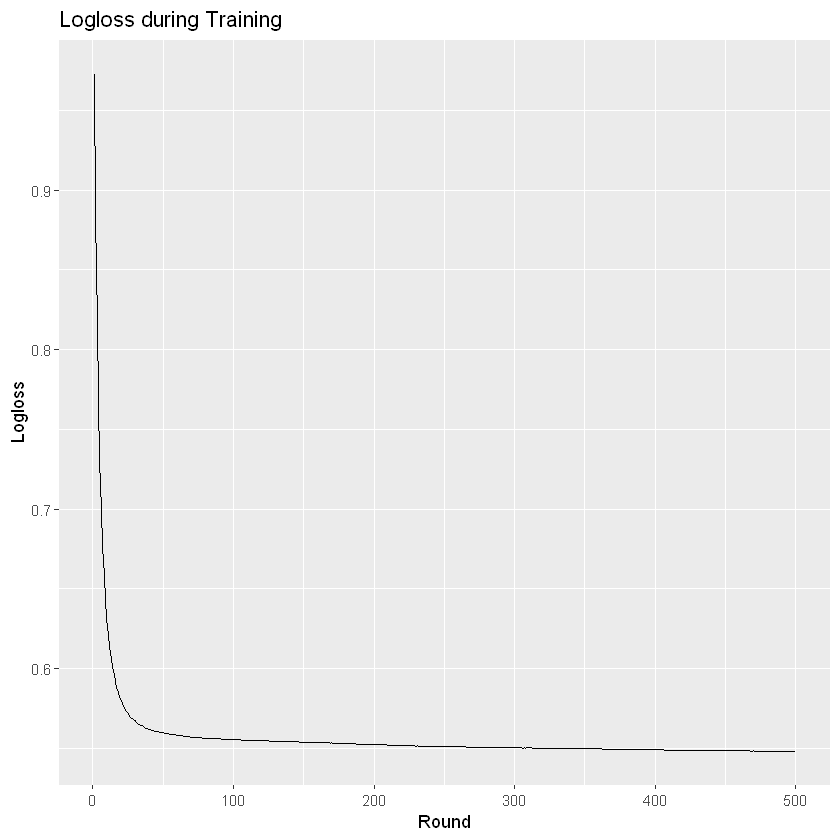

In [30]:
logloss <- xgb_model$evaluation_log$test

# Plot the logloss values
plot_data <- data.frame(round = seq_along(logloss), logloss = logloss)
ggplot(plot_data, aes(x = round, y = logloss)) +
  geom_line() +
  xlab("Round") +
  ylab("Logloss") +
  ggtitle("Logloss during Training")

Prediction and F1_score:

In [15]:
xgb_preds <- predict(xgb_model, as.matrix(X_test), reshape = TRUE)
xgb_preds <- as.data.frame(xgb_preds)

F1_Score_micro(Y_test$damage,max.col(xgb_preds))

[1] 0.7542305

This is already a very good score, especially compared to the ones obtained with a Neural Network. XGboost lives up to its reputation: without even tuning any hyperparameters, we manage to score 75% on the training data. But we should not forget that a Cross-Validation is necessary to validate this F1_score, and also to assess the choice of hyperparameters.

Unfortunately, we don't have the necessary ressources to tune all the hyperparameters. In the following, we'll see that it costs at lot of processing time to try new parameters, together with a Cross-Validation, which is necessary. Again, we do not aim to tune the best xboogst nor neural network model to get the best F1_score. We spent the majority of our time and ressources in the data pre-process, as we believe that it is the most crucial part of the work. We can get good accuracy with great data pre-processing and sub-tuned xgboost/NN model, but the contrary is less true. (Altough XGBoost did quite good with the rawdataset (around 73% accuracy), but at this point 1-2% is a major difference). We put our trust in the ability of our data pre-processing treatement to give us good accuracy score with a lightly tune model.

We will focus on the two of the most importants hyper-parameters for XGBoost : `eta`, which is equivalent to `learning_rate`, and `n_round` which represents the number of time XGBoost try to learn. The code below tries 4 different values for both `eta` and `n_round`, respectively $\{ 0.12,0.15,0.17,0.19\}$ and $\{ 1500,2000,2250,2500\}$. The strategy for hypertuning is the coordinate descent: we keep one parameter constant and we vary the other; we have volontary increased the range of `n_round` (with respect to the first example) because naively we think it might increase the perfomance. We also lowered the range of learning rate as we don't want it to be too big. We did 3-fold for Cross-Validation as the processing time is quite long:

**Hypertuning `eta` and `n_round`: 1st round**

In [5]:
df_parameters <- data.frame(eta = c(0.12,0.15,0.17,0.19),
                        n_round = c(1500,2000,2250,2500))

In [6]:
#Running time : ~140min

#Coordinate descent (CD) tuning for hyperparameters

set.seed(43)

pb <- txtProgressBar(min = 0, max = 12, style = 3, label = "Progress:")  #progress bar
progress <- 0   #setting up progress

n <- ncol(dataset)
N <- nrow(dataset)
CV_folds <- 3     
size_CV <-floor(N/CV_folds)

#Create a matrix to encode the F1_score obtained for each doubles (eta,n_round) of hyper-parameters
CV_score_xgboost<-matrix(0,nrow=nrow(df_parameters)*ncol(df_parameters),ncol=CV_folds+3)
colnames(CV_score_xgboost) <- c('eta','n_round','F1_score_CV1','F1_score_CV2','F1_score_CV3','F1_score_mean')
row <- 0  #row of the CV_score_xgboost matrix

for (eta_value in df_parameters$eta){       #We start with a loop on eta 
    row <- row + 1
    CV_score_xgboost[row,1] <- eta_value        #Assign the first columns to the value of eta
    CV_score_xgboost[row,2] <- 1000                #We will run xgboost with n_round=1000
    for (i in 1:CV_folds){
        progress <- progress + 1                #Progress bar
        set.seed(43)
        #Validation set
        idx_ts<-(((i-1)*size_CV+1):(i*size_CV)) 
        idx_tr<-setdiff(1:N,idx_ts)
        X_train <- dataset[idx_ts,] %>% select(-c(damage_grade)) #Train set
        Y_train <- dataset[idx_ts,] %>% select(c(damage_grade))  #Train set
        Y_train <- Y_train - 1  #Because xgboost encode categories starting to 0
        X_test <- dataset[idx_tr,] %>% select(-c(damage_grade)) #Test set 
        Y_test <- dataset[idx_tr,] %>% select(c(damage_grade)) #Test set 

        #Model
        xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = Y_train$damage_grade)
        xgb_test <- xgb.DMatrix(data = as.matrix(X_test), label = Y_test$damage_grade)

        params <- list(
            booster = "gbtree",
            eta = eta_value,       #parameter being tuned
            max_depth = 7,          
            gamma = 4,
            subsample = 0.75,
            colsample_bytree = 0.8,
            objective = "multi:softprob",
            eval_metric = "mlogloss",
            num_class = 3
            )
        
        #Train the model
        xgb_model <- xgb.train(
        params = params,
        data = xgb_train,
        nrounds = 1000,  #parameters to be tuned
        verbose = 1
	    )

        #F1 score
        xgb_preds <- predict(xgb_model, as.matrix(X_test), reshape = TRUE)
        xgb_preds <- as.data.frame(xgb_preds)  
        # output of xgb_preds is a dataframe with class-probabilities for each label 1,2,3
        # to transform it into a simple list, we take the maximum bewteen columns (highest prob) for each rows
        # with max.col()

        #CV_fold i
        CV_score_xgboost[row,i+2] <-F1_Score_micro(Y_test$damage,max.col(xgb_preds))
        #store it into CV_score_xgboost matrix
        setTxtProgressBar(pb, progress)
    }
}
print(max(rowMeans(CV_score_xgboost[1:4,3:5])))   #print the highest averaged F1_score 

best_eta_value <- CV_score_xgboost[which.max(rowMeans(CV_score_xgboost[1:4,3:5])),1]
progress <- 0

for (nb_tree in df_parameters$n_round){      #We do the same for n_round now
    row <- row + 1
    CV_score_xgboost[row,1] <- best_eta_value           #Now we keep the best eta_value we found
    CV_score_xgboost[row,2] <- nb_tree                  #We vary the n_round
    for (i in 1:CV_folds){
        progress<- progress + 1
        set.seed(43)
        #Validation set 
        idx_ts<-(((i-1)*size_CV+1):(i*size_CV)) 
        idx_tr<-setdiff(1:N,idx_ts)
        X_train <- dataset[idx_ts,] %>% select(-c(damage_grade))    #Train set
        Y_train <- dataset[idx_ts,] %>% select(c(damage_grade))     #Train set
        Y_train <- Y_train - 1  #Because xgboost encode categories starting to 0 
        X_test <- dataset[idx_tr,] %>% select(-c(damage_grade))     #Test set
        Y_test <- dataset[idx_tr,] %>% select(c(damage_grade))      #Test set

        #Model
        xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = Y_train$damage_grade)
        xgb_test <- xgb.DMatrix(data = as.matrix(X_test), label = Y_test$damage_grade)

        params <- list(
            booster = "gbtree",
            eta = best_eta_value,       #parameters tuned
            max_depth = 7,         
            gamma = 4,
            subsample = 0.75,
            colsample_bytree = 0.8,
            objective = "multi:softprob",
            eval_metric = "mlogloss",
            num_class = 3
            )
        
        #Train the model
        xgb_model <- xgb.train(
        params = params,
        data = xgb_train,
        nrounds = nb_tree,  #parameters being tuned
        verbose = 1
	    )

        #F1 score
        xgb_preds <- predict(xgb_model, as.matrix(X_test), reshape = TRUE)
        xgb_preds <- as.data.frame(xgb_preds)
        #same commentary as before
        CV_score_xgboost[row,i+2] <-F1_Score_micro(Y_test$damage,max.col(xgb_preds))
        setTxtProgressBar(pb, progress)
    }
}
print(max(rowMeans(CV_score_xgboost[5:8,3:5])))


# Close the progress bar
close(pb)

CV_score_xgboost[,6] <- rowMeans(CV_score_xgboost[,3:5])  #Assign last colums of CV_score_xgboost to average of F1_score over CV fold
CV_score_xgboost

  |======================================================================| 100%[1] 0.7456207
  |======================================================================| 100%[1] 0.7454922



eta,n_round,F1_score_CV1,F1_score_CV2,F1_score_CV3,F1_score_mean
0.12,1000,0.7464687,0.7449607,0.7454327,0.7456207
0.15,1000,0.7452715,0.7445002,0.7440800,0.7446173
0.17,1000,0.7457435,0.7443736,0.7440340,0.7447170
0.19,1000,0.7450010,0.7439592,0.7439476,0.7443026
0.12,1500,0.7458586,0.7449549,0.7456629,0.7454922
0.12,2000,0.7456399,0.7449492,0.7454212,0.7453367
0.12,2250,0.7453809,0.7446038,0.7452658,0.7450835
0.12,2500,0.7452255,0.7444829,0.7450816,0.7449300


We see here that `eta=12` seems to be the best parameters. In the `n_round` set $\{ 1500,2000,2250,2500\}$ with `eta=12`, it is `n_round=2250` that perfoms the better. However, if one watches closely, we see that `F1_score_mean` is even better is the first row, where `n_round=1000` and `eta=12`. We will start thus to train the model with theses values on the full dataset !

However, this puts into question our choice of set $\{ 1500,2000,2250,2500\}$ for tuning. We thus decided to redo another round of CV tuning, using now $\{ 500,750,1000,2250\}$ and $\{ 0.1,0.11,0.12,0.13\}$ , which is more close to `n_round = 1000` which performed the best. After that, we'll check what parameters give us the better `F1_score_mean` and we'll train another model with these.

**Hypertuning `eta` and `n_round`: 2nd round**

Let us start with the second round of hypertuning-CV with $\{ 0.1,0.11,0.12,0.13\}$ and $\{ 500,750,1000,2250\}$.

In [7]:
df_parameters_round2 <- data.frame(eta = c(0.1,0.11,0.12,0.13),
                        n_round = c(500,750,1000,2250))

In [8]:
#Running time : ~102min

#Coordinate descent (CD) tuning for hyperparameters

set.seed(43)

pb <- txtProgressBar(min = 0, max = 12, style = 3, label = "Progress:")  #progress bar
progress <- 0   #setting up progress

n <- ncol(dataset)
N <- nrow(dataset)
CV_folds <- 3     
size_CV <-floor(N/CV_folds)

#Create a matrix to encode the F1_score obtained for each doubles (eta,n_round) of hyper-parameters
CV_score_xgboost_round2<-matrix(0,nrow=nrow(df_parameters_round2)*ncol(df_parameters_round2),ncol=CV_folds+3)
colnames(CV_score_xgboost_round2) <- c('eta','n_round','F1_score_CV1','F1_score_CV2','F1_score_CV3','F1_score_mean')
row <- 0  #row of the CV_score_xgboost matrix

for (eta_value in df_parameters_round2$eta){       #We start with a loop on eta 
    row <- row + 1
    CV_score_xgboost_round2[row,1] <- eta_value        #Assign the first columns to the value of eta
    CV_score_xgboost_round2[row,2] <- 1000                #We will run xgboost with n_round=1000
    for (i in 1:CV_folds){
        progress <- progress + 1                #Progress bar
        set.seed(43)
        #Validation set
        idx_ts<-(((i-1)*size_CV+1):(i*size_CV)) 
        idx_tr<-setdiff(1:N,idx_ts)
        X_train <- dataset[idx_ts,] %>% select(-c(damage_grade)) #Train set
        Y_train <- dataset[idx_ts,] %>% select(c(damage_grade))  #Train set
        Y_train <- Y_train - 1  #Because xgboost encode categories starting to 0
        X_test <- dataset[idx_tr,] %>% select(-c(damage_grade)) #Test set 
        Y_test <- dataset[idx_tr,] %>% select(c(damage_grade)) #Test set 

        #Model
        xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = Y_train$damage_grade)
        xgb_test <- xgb.DMatrix(data = as.matrix(X_test), label = Y_test$damage_grade)

        params <- list(
            booster = "gbtree",
            eta = eta_value,       #parameter being tuned
            max_depth = 7,          
            gamma = 4,
            subsample = 0.75,
            colsample_bytree = 0.8,
            objective = "multi:softprob",
            eval_metric = "mlogloss",
            num_class = 3
            )
        
        #Train the model
        xgb_model <- xgb.train(
        params = params,
        data = xgb_train,
        nrounds = 1000,  #parameters to be tuned
        verbose = 1
	    )

        #F1 score
        xgb_preds <- predict(xgb_model, as.matrix(X_test), reshape = TRUE)
        xgb_preds <- as.data.frame(xgb_preds)  
        # output of xgb_preds is a dataframe with class-probabilities for each label 1,2,3
        # to transform it into a simple list, we take the maximum bewteen columns (highest prob) for each rows
        # with max.col()

        #CV_fold i
        CV_score_xgboost_round2[row,i+2] <-F1_Score_micro(Y_test$damage,max.col(xgb_preds))
        #store it into CV_score_xgboost_round2 matrix
        setTxtProgressBar(pb, progress)
    }
}
print(max(rowMeans(CV_score_xgboost_round2[1:4,3:5])))   #print the highest averaged F1_score 

best_eta_value <- CV_score_xgboost_round2[which.max(rowMeans(CV_score_xgboost_round2[1:4,3:5])),1]
progress <- 0

for (nb_round in df_parameters_round2$n_round){      #We do the same for n_round now
    row <- row + 1
    CV_score_xgboost_round2[row,1] <- best_eta_value           #Now we keep the best eta_value we found
    CV_score_xgboost_round2[row,2] <- nb_round                  #We vary the n_round
    for (i in 1:CV_folds){
        progress<- progress + 1
        set.seed(43)
        #Validation set 
        idx_ts<-(((i-1)*size_CV+1):(i*size_CV)) 
        idx_tr<-setdiff(1:N,idx_ts)
        X_train <- dataset[idx_ts,] %>% select(-c(damage_grade))    #Train set
        Y_train <- dataset[idx_ts,] %>% select(c(damage_grade))     #Train set
        Y_train <- Y_train - 1  #Because xgboost encode categories starting to 0 
        X_test <- dataset[idx_tr,] %>% select(-c(damage_grade))     #Test set
        Y_test <- dataset[idx_tr,] %>% select(c(damage_grade))      #Test set

        #Model
        xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = Y_train$damage_grade)
        xgb_test <- xgb.DMatrix(data = as.matrix(X_test), label = Y_test$damage_grade)

        params <- list(
            booster = "gbtree",
            eta = best_eta_value,       #parameters tuned
            max_depth = 7,         
            gamma = 4,
            subsample = 0.75,
            colsample_bytree = 0.8,
            objective = "multi:softprob",
            eval_metric = "mlogloss",
            num_class = 3
            )
        
        #Train the model
        xgb_model <- xgb.train(
        params = params,
        data = xgb_train,
        nrounds = nb_round,  #parameters being tuned
        verbose = 1
	    )

        #F1 score
        xgb_preds <- predict(xgb_model, as.matrix(X_test), reshape = TRUE)
        xgb_preds <- as.data.frame(xgb_preds)
        #same commentary as before
        CV_score_xgboost_round2[row,i+2] <-F1_Score_micro(Y_test$damage,max.col(xgb_preds))
        setTxtProgressBar(pb, progress)
    }
}
print(max(rowMeans(CV_score_xgboost_round2[5:8,3:5])))


# Close the progress bar
close(pb)

CV_score_xgboost_round2[,6] <- rowMeans(CV_score_xgboost_round2[,3:5])  #Assign last colums of CV_score_xgboost_round2 to average of F1_score over CV fold
CV_score_xgboost_round2

  |======================================================================| 100%[1] 0.745826
  |======================================================================| 100%[1] 0.745826



eta,n_round,F1_score_CV1,F1_score_CV2,F1_score_CV3,F1_score_mean
0.10,1000,0.7465551,0.7457953,0.7451276,0.7458260
0.11,1000,0.7463191,0.7456169,0.7454096,0.7457819
0.12,1000,0.7464687,0.7449607,0.7454327,0.7456207
0.13,1000,0.7458356,0.7450758,0.7444311,0.7451142
0.10,500,0.7458126,0.7460198,0.7449607,0.7455977
0.10,750,0.7463421,0.7458298,0.7451334,0.7457684
0.10,1000,0.7465551,0.7457953,0.7451276,0.7458260
0.10,2250,0.7463651,0.7455478,0.7444714,0.7454615


This tuning suggest to choose `eta = 0.1` altough 0.12 is not that far. For `n_round`, 750 is best altough 1000 has a very close `F1_score_mean`. Let us train both of these models, and save them for submission on Data Driven !

Note that here, we have the best `F1_score_mean` is still less than the best we found in the subsection Hypertuning `eta` and `n_round`: 1st round. We expect to have thus still beter result with `eta =0.12` and `n_round=1000` ! 

**XGBoost training on full dataset with `eta = 0.12` and `n_round=1000`**

In [ ]:
set.seed(43)

#Full dataset
X_train <- dataset %>% select(-damage_grade)
Y_train <- dataset %>% select(damage_grade) 
Y_train <- Y_train - 1

#Set up
xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = Y_train$damage_grade)

params <- list(
	booster = "gbtree",
	eta = 0.12,
	max_depth = 7,
	gamma = 4,
	subsample = 0.75,
	colsample_bytree = 0.8,
	objective = "multi:softprob",
	eval_metric = "mlogloss",
	num_class = 3
)

Training:

In [ ]:
#Running time: ~10min

set.seed(43)

xgb_model <- xgb.train(
	params = params,
	data = xgb_train,
	nrounds = 1000,  #initial 5000
	verbose = 1
)

Prediction:

In [ ]:
#Loading test_features dataset, cleaned and encoded

testset <- read.csv('Data/test_values_cleaned_encoded.csv',header = T,sep=',')

#We also need to one-hot encode the remaining categorical features

categorical_features <- c('land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration')

for (feature in categorical_features){
    testset[,feature]  <- as.factor(testset[,feature] )
}

testset <- as.data.frame(one_hot(as.data.table(testset)))

In [ ]:
xgb_preds <- as.data.frame(predict(xgb_model, as.matrix(testset), reshape = TRUE))
pred123 <- c(max.col(xgb_preds))
prediction <- data.frame(damage_grade=pred123)
prediction <- cbind(building_id=rawtestset$building_id,prediction)

In [ ]:
#Saving .csv for submission

#write.csv(prediction, 'Data/Prediction4_xgboost.csv',quote=F,row.names=F,fileEncoding = "UTF-8")

_Score of the submission on DrivenData:_

 - 0.7468

**XGBoost training on full dataset with `eta = 0.1` and `n_round=1000`**

In [10]:
set.seed(43)

#Full dataset
X_train <- dataset %>% select(-damage_grade)
Y_train <- dataset %>% select(damage_grade) 
Y_train <- Y_train - 1

#Set up
xgb_train <- xgb.DMatrix(data = as.matrix(X_train), label = Y_train$damage_grade)

params <- list(
	booster = "gbtree",
	eta = 0.1,
	max_depth = 7,
	gamma = 4,
	subsample = 0.75,
	colsample_bytree = 0.8,
	objective = "multi:softprob",
	eval_metric = "mlogloss",
	num_class = 3
)

Training: 

In [11]:
#Running time: ~11min

set.seed(43)

xgb_model <- xgb.train(
	params = params,
	data = xgb_train,
	nrounds = 1000,  
	verbose = 1
)

Prediction:

In [21]:
set.seed(43)

xgb_preds <- as.data.frame(predict(xgb_model, as.matrix(testset), reshape = TRUE))
pred123 <- c(max.col(xgb_preds))
prediction <- data.frame(damage_grade=pred123)
prediction <- cbind(building_id=rawtestset$building_id,prediction)

In [23]:
#Saving .csv for submission

#write.csv(prediction, 'Data/Prediction6_xgboost.csv',quote=F,row.names=F,fileEncoding = "UTF-8")

*Score of the submission on DrivenData:*

 - 0.7461

**Conclusion**

Thanks to XGBoost, we were able to score **0.7468** (ranking 511/6817) for the config `eta=.12` and `n_round = 1000`. The config `eta=.1` and `n_round = 1000` scored a bit less with **0.7461**. This is a bit surprising, as we noticed that best `F1_score_mean` was better in the second round than in the first one (0.7456207 vs 0.7458260). Maybe this was due to some little influence of overfitting.

XGBoost is known to usually perfoms better than Random Forest, and we do verify this during the project, even if the difference is minor.

We are quite happy with the results obtained here. The amout of effort we put in the data pre-processing treatement paid us back: with little model tuning we were able to still generate good accuracy result, according to Data Driven ! 

[back to the contents](#Contents)

***

## Feature relevance via entropy

In order to rank the features in terms of relevance, one computes the difference between the conditional entropies $$H(y|X^{-i}) - H(y|X)$$ where $H(y|X)$ is the conditional entropy of the target $y$ given $X$. In other words, it is the entropy of the target $y$ predicted by the classifier that uses all the variables $x_i$ of $X$. Hence, $H(y|X^{-i})$ is the entropy of the target $y$ predicted by the classifier that uses all the variables $x_j$ of $X$, $\forall j \neq i$.
The entropy of a discrete random variable $y$ is given by $$H(y) = - \sum_{y_i \in \mathcal{Y}} p(y_i) \log_{10}{p(y_i)} \, , $$
where the probabilites of the categories $y_i$ are computed via frequence counting. Note that our notation can be confusing here : $y_i$ are the target classes and $x_i$ are the input variables, they have nothing to do with each other.

What are we exactly looking for ? Following section 10.8.3 of the handbook, the ideal subset of variables is the one that minimizes $ H(y|X)$. Since what we want to do is to rank the features based on how much removing them shifts the target entropy from $ H(y|X)$, the most relevant feature will be the one that maximizes the difference $H(y|X^{-i}) - H(y|X)$. Indeed, the maximum of $H(y|X^{-i}) - H(y|X)$ is related to worst possible subset of variables, hence the associated removed variable $x_i$ is the more relevant. An important thing to note is that we are dealing with predicted target here and that the entropy of reference $ H(y|X)$ is not necessarily the smallest possible, i.e. the $X$ with start with is not necessarily the ideal set of variables. It will sometimes happen that $H(y|X^{-i}) - H(y|X)<0$. At the end, we want will want to minimize is $|H(y|X^{-i}) - H(y|X)|$, i.e. the distance between the two entropies.


We choose to rank the $32$ variables that we have been working with, i.e. the features of the cleaned, encoded dataset. We will use as a classifier the optimal decision tree that we found, since it is the less time-consuming model among the four models that we used in this work. We can already put a disclaimer : a single decision tree (and especially our optimal decision tree) does not use all the variables in order to predict the target. Hence, we already know that removing some variables won't change anything in the computation of the target entropy. This limit our answer to the question. Hopefully, these "forgotten" variables are supposedly less relevant.


Let us first define a function that returns the entropy from an array of target predictions, knowing that the categories of $y$ are $y_i = 1,2,3$. 

In [82]:
#-- input : y = array of predictions 1,2,3
entropy <- function(y){
    H <- 0
    
    #loop over the 3 target categories
    for (i in 1:3){ 
        #Indices of the category i 
        ind_i <- y==i
        
        #Probability = frequency
        p_i <- sum(ind_i)/length(y)
        
        #Computation of the entropy
        H <- H - (p_i * log10(p_i))
        }
    return(H)
    }

Then we compute the entropy of reference, namely $ H(y|X)$, with our decision tree:

In [34]:
model <- rpart(Y[,] ~ ., method="class",data=X, cp = 1.2017e-04)

In [31]:
pred <- predict(model,X_test, type='class')

In [40]:
ref <- entropy(pred)

In [41]:
ref

[1] 0.3553302

It is computed from the following classe repartition:

In [33]:
table(pred)

pred
    1     2     3 
 6105 56950 23813 

Now we launch the process! We loop over the $32$ features and for each feature, we remove it from the training dataset and we train a decision tree on the resulting dataset. Then, we predict the targets on the test set (so that it does not lead us to overly optimistic results, since the model has already been trained on the training set) and we save the absolute value of the difference between the entropy and the reference entropy.

In [46]:
#Array to save the entropy differences
entropies <- array(0,ncol(X))

#Loop over the features
for (i in 1:ncol(X)){
    
    #Removing the i^th feature
    X_i <- X %>% select(-colnames(X)[i])
    
    #Training the decision tree
    model <- rpart(Y[,] ~ ., method="class",data=X_i, cp = 1.2017e-04)
    
    #Predicting targets on the test set
    pred <- predict(model,X_test, type='class')
    
    #Saving the abs of the difference 
    entropies[i] <- abs(entropy(pred)-ref)
    }

In [60]:
entr <- data.frame(entropies)

In [61]:
entr <- cbind(colnames(X),entr)

Ranking in terms of relevance:

In [69]:
entr[order(entr$entropies, decreasing=TRUE),]

,colnames(X),entropies
,<chr>,<dbl>
2,age,2.545878e-03
8,ground_floor_type,2.062479e-03
16,has_superstructure_cement_mortar_brick,1.837685e-03
13,has_superstructure_mud_mortar_stone,1.560637e-03
3,area_percentage,1.429780e-03
30,enc_geo_level_3_id_tar_damage_grade_X1,1.406013e-03
29,enc_geo_level_2_id_tar_damage_grade_X3,1.342025e-03
20,count_families,1.278639e-03
31,enc_geo_level_3_id_tar_damage_grade_X2,1.238022e-03


As expected, some features don't shift the conditional entropy because they are not used par the decision tree (i.e. they are seen as irrelevant by a decision tree of this size). We still see the geographical zones highly ranked, and other categorical features such as age and area_percentage. However there is not much more we can say about this ranking. The values are very close and we are aware that this ranking will depend a lot on the decision tree used.

Remark : We forgot the set a seed before calling the various decision trees, hence the entropies might be a little different after a new run of the cells.

[back to the contents](#Contents)

***

## Final score and conclusion

The first part of this work was to preprocess the dataset. We explored it in details, so that this overview allowed us to get rid of some features and to replace outliers. We also spent some time on feature engineering, especially on the fact that we wanted to convert categorical features into numerical ones. More precisely, the geographical zones have been target encoded, and we used one-hot encoding for the remaining categorical features when the model needed it.

Then, we trained 4 machine learning models in order to generate the best classifier possible. Our goal here was not to find the perfeclty tuned hyperparameters, but to find hyperparameters that allowed the models to perform reasonably well.
We started with a basic decision tree, whose prediction score was not so bad (partly due a good preprocessing!), but it was smaller than an ensembling of independent decision trees, namley Random Forest. The Neural network was more complicated to handle, as we didn't find the optimal way to tune the hyperparameters. At the end, our best prediction score was reached with XGBoost, after a small grid search in the hyperparameter space. With this, we got a prediction micro F1 score of 0.7468 on DrivenData.

Finally, we had a glimpse of how entropy and information-theoretic notions could help us in the ranking of the feature relevance, even if we chose to use a classifier which was too simple for this task.

[back to the contents](#Contents)

***